# Youtube URL Linked to News

In [1]:
import psycopg2
import pandas as pd
import config
from matplotlib import pylab as plt
import seaborn as sns
import numpy as np
from IPython.display import display, HTML
import re
from urllib.parse import parse_qs,urlparse
import

color_palette = sns.color_palette(palette='muted', n_colors=None, desat=.75)
sns.set(context='notebook', palette=color_palette, style='whitegrid', font='sans-serif', font_scale=1.5, color_codes=False, rc=None)
pd.set_option('display.max_colwidth', -1)
table_styles = [{'selector': 'td',
                 'props': [('min-width', '100px'), ('text-align', 'center')]},
                {'selector': 'tr',
                 'props': [('border-bottom', '1px dotted black')]},
                {'selector': 'th',
                 'props': [('text-align', 'center')]}
               ]

%matplotlib inline

directory = "url_top_lists/"
stream = "comparison"

/media/raid/home/pflugmacher/virtualenv/twitterenvold/lib/python3.4/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)
/media/raid/home/pflugmacher/virtualenv/twitterenvold/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
conn = None
try:
    # read connection parameters
    paramsS17 = config.cfgAzureS17()
    paramsS03 = config.cfgAzureS03()

    paramsF17 = config.cfgAzureF17()
    paramsF03 = config.cfgAzureF03()
    
    # connect to the PostgreSQL server
    print('Connecting to the PostgreSQL database...')
    connS17 = psycopg2.connect(**paramsS17)
    connS03 = psycopg2.connect(**paramsS03)
    
    connF17 = psycopg2.connect(**paramsF17)
    connF03 = psycopg2.connect(**paramsF03)

    # create a cursor
    curS17 = connS17.cursor()
    curS03 = connS03.cursor()
    
    curF17 = connF17.cursor()
    curF03 = connF03.cursor()

    # execute a statement
    print('PostgreSQL database version:')
    
    curS17.execute('SELECT version()')
    curS03.execute('SELECT version()')
    curF17.execute('SELECT version()')
    curF03.execute('SELECT version()')
    
    # display the PostgreSQL database server version
    db_version_curS17 = curS17.fetchone()
    db_version_curS03 = curS03.fetchone()
    db_version_curF17 = curF17.fetchone()
    db_version_curF03 = curF03.fetchone()
    
    print(db_version_curS17)
    print(db_version_curS03)
    print(db_version_curF17)
    print(db_version_curF03)

    # close the communication with the PostgreSQL
    curS17.close()
    curS03.close()
    curF17.close()
    curF03.close()

except (Exception, psycopg2.DatabaseError) as error:
    print(error)

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 9.6.9, compiled by Visual C++ build 1800, 64-bit',)
('PostgreSQL 9.6.9, compiled by Visual C++ build 1800, 64-bit',)
('PostgreSQL 9.6.9, compiled by Visual C++ build 1800, 64-bit',)
('PostgreSQL 9.6.9, compiled by Visual C++ build 1800, 64-bit',)


## Util Methods

In [3]:
def compareRows(row, df_to_compare, column_name):
    comparison_row = df_to_compare.loc[df_to_compare[column_name] == row[column_name]]
    if comparison_row.empty:
        comparison = " - "
    else:
        percentage_dif = row['percentage'] - comparison_row['percentage'].values[0]
        difference = "(%s. / %.3f%% / %.3f%%)" % (comparison_row['rank'].values[0], comparison_row['percentage'].values[0], percentage_dif)
        if comparison_row['rank'].values[0] == row['rank']:
            comparison = " = <br>" + difference
        else:
            if comparison_row['rank'].values[0] > row['rank']:
                comparison = " v <br>" + difference
            else:
                comparison = " ^ <br>" + difference
    return comparison

def getOpacity(val):
    value = abs(float(re.findall(r"[-+]?\d*\.\d+|\d+", val.split("/")[2])[0]))
    if value < 0.005:
        return 1
    if value < 0.01:
        return 0.95
    if value < 0.05:
        return 0.8
    if value < 0.1:
        return 0.7
    if value < 0.5:
        return 0.6
    if value < 1:
        return 0.5
    if value < 10:
        return 0.3
    if value < 40:
        return 0.2
    if value < 80:
        return 0.1
    if value < 100:
        return 0.05

def colorComparisonField(val):
    
    if isinstance(val, str):
        if ' ^ ' in val or ' v ' in val:
            return 'background-color: rgba(246, 185, 59, %s)' %getOpacity(val)
        if ' = ' in val:
            return 'background-color: rgba(184, 233, 148, %s)' %getOpacity(val)
        if ' - ' in val and len(val) == 3:
            return 'background-color: #e55039' 
    return ''

def generateRankingDataframe(series, attribute_name):
    size = series.sum()
    rank = []
    parameter = []
    count = []
    percentage = []

    i = 1
    for index, value in series.iteritems():
        rank.append(i)
        parameter.append(index)
        count.append(value)
        percentage.append((value/size)*100)
        i += 1

    data = {'rank': rank, attribute_name: parameter, 'value': count, 'percentage': percentage}
    return pd.DataFrame(data=data)

def generateComparisonDataframes(df1, df2, column_name, size):
    compare_list = []
    for index, row in df1.iterrows():
        if row['rank'] <= size:
            compare_list.append(compareRows(row, df2, column_name))

    data = {'rank': df1['rank'][:size], column_name: df1[column_name][:size], 'value': df1['value'][:size], 'percentage': df1['percentage'][:size],
            'difference (rank / percentage / diff)': compare_list}
    
    df1_compared = pd.DataFrame(data=data)
    df1_compared.set_index(keys='rank', inplace=True)
    
    compare_list = []
    for index, row in df2.iterrows():
        if row['rank'] <= size:
            compare_list.append(compareRows(row, df1, column_name))

    data = {'rank': df2['rank'][:size], column_name: df2[column_name][:size], 'value': df2['value'][:size], 'percentage': df2['percentage'][:size],
            'difference (rank / percentage / diff)': compare_list}
    
    df2_compared = pd.DataFrame(data=data)
    df2_compared.set_index(keys='rank', inplace=True)
    
    return df1_compared, df2_compared

def getPrettyComparisonDataframe(df, title):
    s = df.style.applymap(colorComparisonField)
    s.set_caption(title)
    s.set_table_styles(table_styles)
    return s

## Query URLs - Sampled

In [4]:
urlsS03 = pd.read_sql_query("SELECT * FROM tweets_urls;", connS03 )
print("# of URLs sampled 03: %s" %len(urlsS03))

urlsS17 = pd.read_sql_query("SELECT * FROM tweets_urls;", connS17 )
print("# of URLs sampled 17: %s" %len(urlsS17))

urlsS = urlsS17.append(urlsS03)
print("# of URLs sampled: %s" %len(urlsS))

urlsS.head()

# of URLs sampled 03: 40339
# of URLs sampled 17: 35687
# of URLs sampled: 76026


tweet_id  \
0  989097603664138240   
1  988175933659021318   
2  988176164358361088   
3  988176403412766720   
4  988176415995592704   

                                                                  short_url  \
0  http://arte.tv/abgedreht                                                   
1  https://twitter.com/piersmorgan/status/987388203593322496                  
2  https://www.journal.koeln/pol-ham-fahrradfahrer-verletzt-sich-bei-sturz/   
3  http://www.radionomy.com/erika1                                            
4  https://twitter.com/JanLatten/status/988161845205913600                    

                                                               resolved_url  \
0  https://www.arte.tv/de/videos/RC-014033/abgedreht/                         
1  https://twitter.com/piersmorgan/status/987388203593322496                  
2  https://www.journal.koeln/pol-ham-fahrradfahrer-verletzt-sich-bei-sturz/   
3  https://www.radionomy.com/en/radio/erika1                                  
4  https://twitter.com/JanLatten/status/988161845205913600                    

   response_code                      domain top_level_domain  is_twitter_url  \
0  200.0          https://www.arte.tv/        arte.tv          False            
1  200.0          https://twitter.com/        twitter.com      True             
2  200.0          https://www.journal.koeln/  journal.koeln    False            
3  200.0          https://www.radionomy.com/  radionomy.com    False            
4  200.0          https://twitter.com/        twitter.com      True             

  is_media  is_processed  failed  
0  False    True          False   
1  False    True          False   
2  False    True          False   
3  False    True          False   
4  False    True          False

## Query Hashtags - Sampled

In [5]:
hashtagsS03 = pd.read_sql_query("SELECT * FROM tweets_hashtags;", connS03 )
print("# of hashtags sampled 03: %s" %len(hashtagsS03))

hashtagsS17 = pd.read_sql_query("SELECT * FROM tweets_hashtags;", connS17 )
print("# of hashtags sampled 17: %s" %len(hashtagsS17))

hashtagsS = hashtagsS17.append(hashtagsS03)
print("# of URLs sampled: %s" %len(hashtagsS))

hashtagsS.head()

# of hashtags sampled 03: 84203
# of hashtags sampled 17: 73935
# of URLs sampled: 158138


tweet_id               hashtag
0  988175614908788736  wetter              
1  988176244029251584  MTVBRPETNUGGET      
2  988176244029251584  MTVBRSHADETAYLORKATY
3  988176244029251584  PremiosMTVMiaw      
4  988176244029251584  MTVLAINSTAGLCAMILAC

## Query URLs - Filtered

In [5]:
urlsF03 = pd.read_sql_query("SELECT * FROM tweets_urls;", connF03 )
print("# of URLs filtered 03: %s" %len(urlsF03))

urlsF17 = pd.read_sql_query("SELECT * FROM tweets_urls;", connF17 )
print("# of URLs filtered 17: %s" %len(urlsF17))

urlsF = urlsF17.append(urlsF03)
print("# of URLs filtered: %s" %len(urlsF))

urlsF.head()

# of URLs filtered 03: 2411523
# of URLs filtered 17: 2107279
# of URLs filtered: 4518802


tweet_id  \
0  988437985363406853   
1  988437986797916160   
2  988437989712957440   
3  988437989704568832   
4  988437990732128256   

                                                                                                                              short_url  \
0  https://www.facebook.com/nadjashah/posts/10215947002527277                                                                             
1  https://www.facebook.com/StageSchoolHamburg/posts/1934173349947359                                                                     
2  http://www.faz.net/aktuell/rhein-main/frankfurt/frankfurter-gutleutviertel-landgericht-erlaubt-drohende-zwangsraeumung-15556433.html   
3  http://vera-lengsfeld.de/2018/04/22/buergerprotest-ueberall-wie-lange-wird-das-noch-verschwiegen/                                      
4  https://ift.tt/2Jm4wnp                                                                                                                 

                                                                                                                                                                                                                                                                                  resolved_url  \
0  https://www.facebook.com/nadjashah/posts/10215947002527277                                                                                                                                                                                                                                    
1  https://www.facebook.com/StageSchoolHamburg/posts/1934173349947359                                                                                                                                                                                                                            
2  http://www.faz.net/aktuell/rhein-main/frankfurt/frankfurter-gutleutviertel-landgericht-erlaubt-drohende-zwangsraeumung-15556433.html                                                                                                                                                          
3  http://vera-lengsfeld.de/2018/04/22/buergerprotest-ueberall-wie-lange-wird-das-noch-verschwiegen/                                                                                                                                                                                             
4  https://news.google.com/?sa=t&fd=R&ct2=de&usg=AFQjCNFSz3Yf_fDFIytLtnNe8JNGM2BPZg&clid=c3a7d30bb8a4878e06b80cf16b898331&ei=O_rdWqDIHNCT3QHCyJDQAg&url=https://www.waz.de/kultur/fuer-silke-j-raebiger-ist-es-das-letzte-frauen-filmfestival-id214100661.html&taa=1&hl=en-US&gl=US&ceid=US:en   

   response_code                     domain   top_level_domain is_twitter_url  \
0  200            https://www.facebook.com/  facebook.com       False           
1  200            https://www.facebook.com/  facebook.com       False           
2  200            http://www.faz.net/        faz.net            False           
3  200            http://vera-lengsfeld.de/  vera-lengsfeld.de  False           
4  200            https://news.google.com/   google.com         False           

  is_media is_processed failed  
0  False    True         False  
1  False    True         False  
2  False    True         False  
3  False    True         False  
4  False    True         False

## Query Hashtags - Filtered

In [7]:
hashtagsF03 = pd.read_sql_query("SELECT * FROM tweets_hashtags;", connF03 )
print("# of hashtags filtered 03: %s" %len(hashtagsS03))

hashtagsF17 = pd.read_sql_query("SELECT * FROM tweets_hashtags;", connF17 )
print("# of hashtags filtered 17: %s" %len(hashtagsS17))

hashtagsF = hashtagsF17.append(hashtagsF03)
print("# of URLs filtered: %s" %len(hashtagsF))

hashtagsF.head()

# of hashtags filtered 03: 84203
# of hashtags filtered 17: 73935
# of URLs filtered: 8158028


tweet_id        hashtag
0  988175612497063936  Mercedes     
1  988175612497063936  Perkasie     
2  988175612497063936  carsforsale  
3  988175612945854465  reiseagentur 
4  988175612945854465  cancelflights

## Youtube Links with Hashtags

In [6]:
youtube_urls_s = urlsS[urlsS['top_level_domain'] == 'youtube.com']
print("# of URLs in Dataframe: %s" %len(youtube_urls_s))

youtube_value_dict_s = {}
for url, count in youtube_urls_s['resolved_url'].value_counts().iteritems():
    video_tweets_url = youtube_urls_s[youtube_urls_s['resolved_url'] == url]
    hashtags = hashtagsS[hashtagsS['tweet_id'].isin(video_tweets_url['tweet_id'])]

    hashtags_ranking = hashtags['hashtag'].value_counts()
    hashtag_with_values = {}
    for tag, value in hashtags_ranking.iteritems():
        hashtag_with_values[tag] = value
    
    youtube_value_dict_s[url] = hashtag_with_values


# of URLs in Dataframe: 6223


In [89]:
len(youtube_value_dict_s.keys())

5175

## Most Popular official news publishers

In [7]:
top_publisher = ['welt.de', 'spiegel.de', 'focus.de', 'bild.de', 'faz.net', 
                 'sueddeutsche.de', 'zeit.de', 'tagesschau.de', 'presseportal.de', 'tagesspiegel.de',
                 'heise.de', 'n-tv.de', 'epochtimes.de', 'handelsblatt.com', 'derstandard.at',
                 'philosophia-perennis.com', 'journalistenwatch.com', 'tichyseinblick.de', 'taz.de', 'rp-online.de']

## Most Shared Articles with Hashtags

In [8]:
urls_by_publisher_s = urlsS[urlsS['top_level_domain'].isin(top_publisher)]

In [9]:
article_x_yt_matches = {}

for url, count in urls_by_publisher_s['resolved_url'].value_counts().iteritems():
    article_tweets_url = urls_by_publisher_s[urls_by_publisher_s['resolved_url'] == url]
    hashtags = hashtagsS[hashtagsS['tweet_id'].isin(article_tweets_url['tweet_id'])]

    hashtags_ranking = hashtags['hashtag'].value_counts()
    
    matched_urls = []
    matched_values = []
    
    for yt_url, yt_tag_value_dict in youtube_value_dict_s.items():
        yt_url_rating = {}
        matches = 0

        for tag, value in hashtags_ranking.iteritems():
            if tag in yt_tag_value_dict:
                yt_tag_value = yt_tag_value_dict[tag]
                
                if value <= yt_tag_value:
                    matches += value
                else:
                    matches += yt_tag_value

        if matches > 0:
            matched_urls.append(yt_url)
            matched_values.append(matches)
        
    article_x_yt_matches[url] = pd.Series(data=matched_values, index=matched_urls)
            

In [224]:
len(article_x_yt_matches)

3

In [104]:
youtube_value_dict_s['https://www.youtube.com/watch?v=JXZFCQXApEY']

{'AfD': 2,
 'AfDwirkt': 2,
 'Bundestag': 1,
 'Hampel': 1,
 'Landtag': 1,
 'Retweet': 1,
 'Syrien': 2,
 'Syrienreise': 2,
 'Wendezeit': 2}

## Articles x Videos by Hashtag co-occurences

In [10]:
def getHashtagsFromURL(url, urls, hashtags):
    return hashtags[ hashtags['tweet_id'].isin(urls[urls['resolved_url'] == url]['tweet_id'])]

In [151]:
", ".join(getHashtagsFromURL("https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html", urlsS, hashtagsS)['hashtag'].unique())

'FluechtlingsIndustrie, Sozialverbände, Altparteien, Staatsmedien, FakeNews, Welt, Inzucht, taz, AfD, Anfrage, Fakten, Doppelmoral'

In [11]:
rank=1
for publisher in top_publisher[:1]:
    all_urls_by_publisher = urlsS[urlsS['top_level_domain'] == publisher]
    
    articles_counted_s = all_urls_by_publisher['resolved_url'].value_counts()
    
    print("rank", "publisher", "# shares", "# unique", "% unique", sep="\t")
    
    print(rank, publisher,
          len(all_urls_by_publisher),
          len(articles_counted_s),
          "%.2f%%" %(len(articles_counted_s)/len(all_urls_by_publisher)*100), 
          
          sep='\t')
    rank+=1
    print("", "#", "%", "article", "hashtags", sep="\t")
    
    for article, count in articles_counted_s[:5].iteritems():
        print("",
              count, 
              "%.2f%%" %(count/sum(articles_counted_s)*100), 
              article,
              ", ".join(getHashtagsFromURL(article, urlsS, hashtagsS)['hashtag'].unique()),
              sep='\t')
        
        if article in article_x_yt_matches:
            article_x_yt_matches[article].sort(ascending=False)
            print("", "", "#", "Youtube URL", "Hashtags", sep="\t")
            for matched_yt_url, count in article_x_yt_matches[article][:5].iteritems():
                print("",
                      "",
                      count,
                      matched_yt_url,
                      ", ".join(getHashtagsFromURL(matched_yt_url, urlsS, hashtagsS)['hashtag'].unique()),
                      sep="\t")
        else:
            print("", "", "", "", "", sep="\t")

rank	publisher	# shares	# unique	% unique
1	welt.de	1222	739	60.47%
	#	%	article	hashtags
	12	0.98%	https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html	FluechtlingsIndustrie, Sozialverbände, Altparteien, Staatsmedien, FakeNews, Welt, Inzucht, taz, AfD, Anfrage, Fakten, Doppelmoral


AttributeError: 'Series' object has no attribute 'sort'

In [25]:
no_articles_with_yt_urls_list = []
no_articles_without_yt_urls_list = []
no_articles_list = []
publisher_list = []
percentage_articles_with_yt_links_list = []
mean_yt_links_per_article_list = []
top10_mean_yt_links_per_article_list = []

yt_links_temp = []

for publisher in top_publisher[:20]:
    all_urls_by_publisher = urlsS[urlsS['top_level_domain'] == publisher]
    
    articles_counted_s = all_urls_by_publisher['resolved_url'].value_counts()
    
    youtube_links_found = 0
    youtube_links_not_found = 0
    sum_yt_links_per_article = 0
    sum_top_yt_links_per_article = 0
    top_limit = 10
    
    for article, count in articles_counted_s.iteritems():
        
        sum_yt_links_per_article += len(article_x_yt_matches[article])
        
        if len(article_x_yt_matches[article]) == 0:
            youtube_links_not_found += 1
        else:
            youtube_links_found += 1
    
    for article, count in articles_counted_s[:top_limit].iteritems():
        
        sum_top_yt_links_per_article += len(article_x_yt_matches[article])
        
    
    article_links_sum = youtube_links_not_found + youtube_links_found
    mean_yt_links_per_article = sum_yt_links_per_article / article_links_sum 
    mean_top_yt_links_per_article = sum_top_yt_links_per_article / top_limit
    
    print(youtube_links_found, 
          youtube_links_not_found, 
          "%.2f" %(youtube_links_found/(article_links_sum) * 100),
          "%.2f" %(mean_yt_links_per_article),
          "%.2f" %(mean_top_yt_links_per_article),
         publisher)
    
    no_articles_with_yt_urls_list.append(youtube_links_found)
    no_articles_without_yt_urls_list.append(youtube_links_not_found)
    no_articles_list.append(article_links_sum)
    publisher_list.append(publisher)
    percentage_articles_with_yt_links_list.append(youtube_links_found/(article_links_sum) * 100)
    mean_yt_links_per_article_list.append(mean_yt_links_per_article)
    top10_mean_yt_links_per_article_list.append(mean_top_yt_links_per_article)
    
    
    if publisher == "philosophia-perennis.com":
        for article, count in articles_counted_s.iteritems():
            print(len(article_x_yt_matches[article]))
            print(article_x_yt_matches[article])
             
data = {'publisher': publisher_list, 
        '# articles': no_articles_list,
        '# articles with yt links': no_articles_with_yt_urls_list,
        '# articles without yt links': no_articles_without_yt_urls_list,
        '% articles with yt links': percentage_articles_with_yt_links_list,
        'mean yt links per article': mean_yt_links_per_article_list,
        'mean top 10 links per article': top10_mean_yt_links_per_article_list,
       }

article_x_yt_df = pd.DataFrame(data=data)

137 602 18.54 2.28 22.30 welt.de
77 485 13.70 1.52 20.30 spiegel.de
75 399 15.82 1.48 7.40 focus.de
69 299 18.75 1.95 19.90 bild.de
91 327 21.77 1.71 3.50 faz.net
44 271 13.97 1.21 9.20 sueddeutsche.de
79 284 21.76 1.62 4.80 zeit.de
74 155 32.31 2.66 10.00 tagesschau.de
42 321 11.57 0.69 1.00 presseportal.de
77 147 34.38 3.13 11.40 tagesspiegel.de
45 151 22.96 1.00 7.80 heise.de
29 164 15.03 2.30 7.00 n-tv.de
26 146 15.12 1.46 3.50 epochtimes.de
35 156 18.32 1.38 0.60 handelsblatt.com
9 145 5.84 0.19 0.00 derstandard.at
40 33 54.79 7.40 17.10 philosophia-perennis.com
0
Series([], dtype: float64)
53
https://www.youtube.com/watch?v=ON6lah4m2yE&t=4s                                               1
https://www.youtube.com/watch?v=GoaVQ8dOEEw&feature=youtu.be                                   3
https://www.youtube.com/channel/UCNz-EGSd5BXEoTcLcYCGsig/                                      2
https://www.youtube.com/watch?v=5Jx_cxzW6ak                                                    1
https:

In [43]:
mean_top_normal = pd.concat([article_x_yt_df['mean top 10 links per article'], article_x_yt_df['mean yt links per article']])
publisher_temp = pd.concat([article_x_yt_df['publisher'], article_x_yt_df['publisher']])
type_data = (len(article_x_yt_df['mean top 10 links per article']) * ["top 10 articles"] +
             len(article_x_yt_df['mean yt links per article']) * ["all articles"])

compare_yt_article_df = pd.DataFrame({"publisher":publisher_temp,"value":mean_top_normal, "type":type_data})


In [44]:
compare_yt_article_df

publisher             type      value
0   welt.de                   top 10 articles  22.300000
1   spiegel.de                top 10 articles  20.300000
2   focus.de                  top 10 articles  7.400000 
3   bild.de                   top 10 articles  19.900000
4   faz.net                   top 10 articles  3.500000 
5   sueddeutsche.de           top 10 articles  9.200000 
6   zeit.de                   top 10 articles  4.800000 
7   tagesschau.de             top 10 articles  10.000000
8   presseportal.de           top 10 articles  1.000000 
9   tagesspiegel.de           top 10 articles  11.400000
10  heise.de                  top 10 articles  7.800000 
11  n-tv.de                   top 10 articles  7.000000 
12  epochtimes.de             top 10 articles  3.500000 
13  handelsblatt.com          top 10 articles  0.600000 
14  derstandard.at            top 10 articles  0.000000 
15  philosophia-perennis.com  top 10 articles  17.100000
16  journalistenwatch.com     top 10 articles  2.900000 
17  tichyseinblick.de         top 10 articles  9.800000 
18  taz.de                    top 10 articles  5.100000 
19  rp-online.de              top 10 articles  6.000000 
0   welt.de                   all articles     2.278755 
1   spiegel.de                all articles     1.519573 
2   focus.de                  all articles     1.476793 
3   bild.de                   all articles     1.945652 
4   faz.net                   all articles     1.705742 
5   sueddeutsche.de           all articles     1.209524 
6   zeit.de                   all articles     1.622590 
7   tagesschau.de             all articles     2.663755 
8   presseportal.de           all articles     0.694215 
9   tagesspiegel.de           all articles     3.133929 
10  heise.de                  all articles     1.000000 
11  n-tv.de                   all articles     2.300518 
12  epochtimes.de             all articles     1.459302 
13  handelsblatt.com          all articles     1.376963 
14  derstandard.at            all articles     0.188312 
15  philosophia-perennis.com  all articles     7.397260 
16  journalistenwatch.com     all articles     0.910714 
17  tichyseinblick.de         all articles     3.582418 
18  taz.de                    all articles     1.109489 
19  rp-online.de              all articles     0.706294

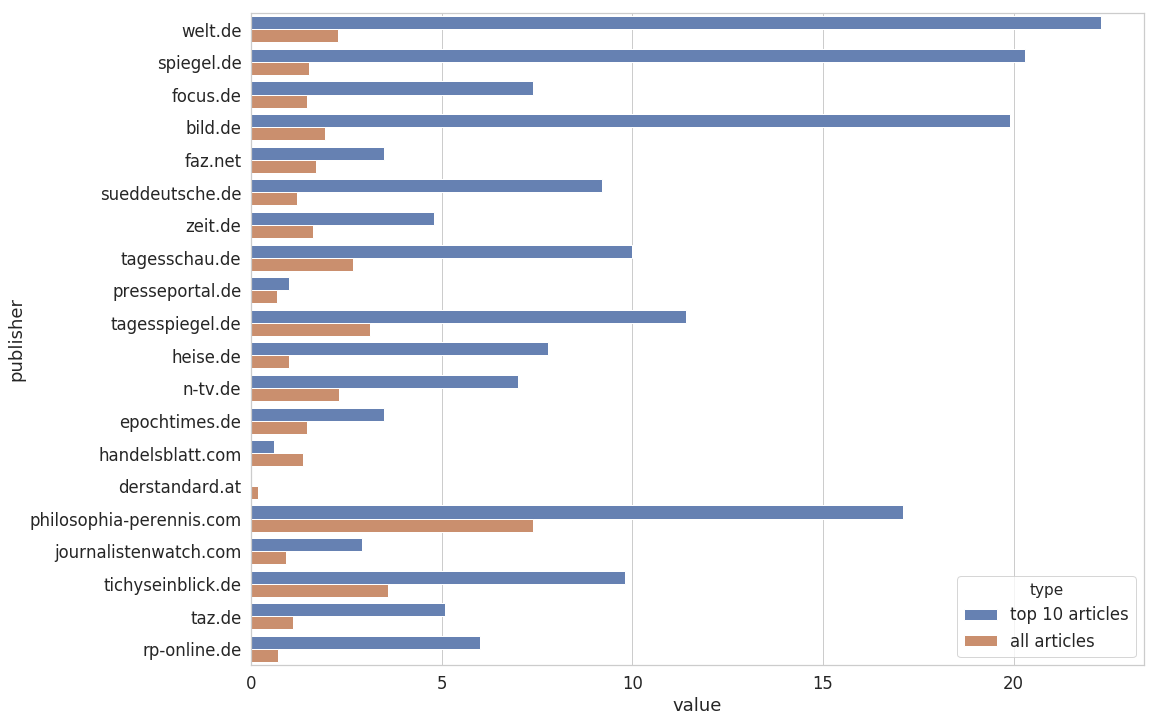

In [54]:
plt.figure(figsize=(16,12))

sns.barplot(y="publisher", x="value", hue="type",  data=compare_yt_article_df);

Text(0.5,0,'mean top 10 links per article')

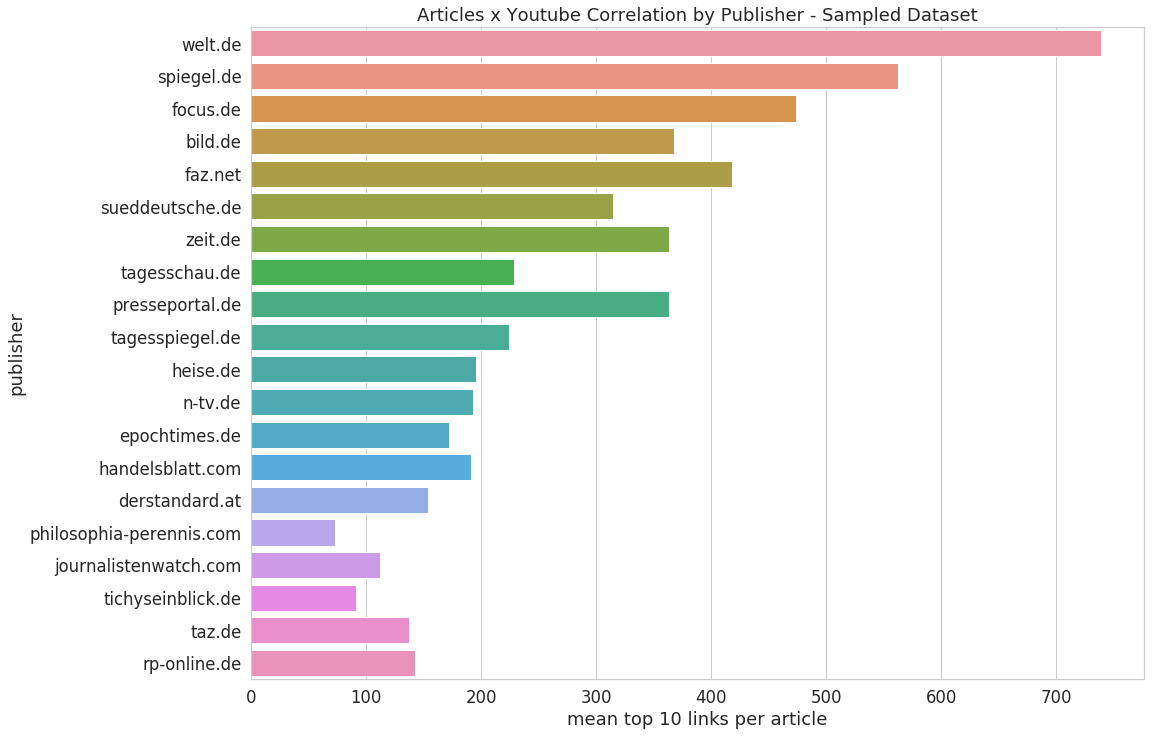

In [55]:
plt.figure(figsize=(16,12))
ax = sns.barplot(y=article_x_yt_df['publisher'], x=article_x_yt_df['# articles'])
ax.set_title("Articles x Youtube Correlation by Publisher - Sampled Dataset")
ax.set_xlabel("mean top 10 links per article")

Text(0.5,0,'mean top 10 links per article')

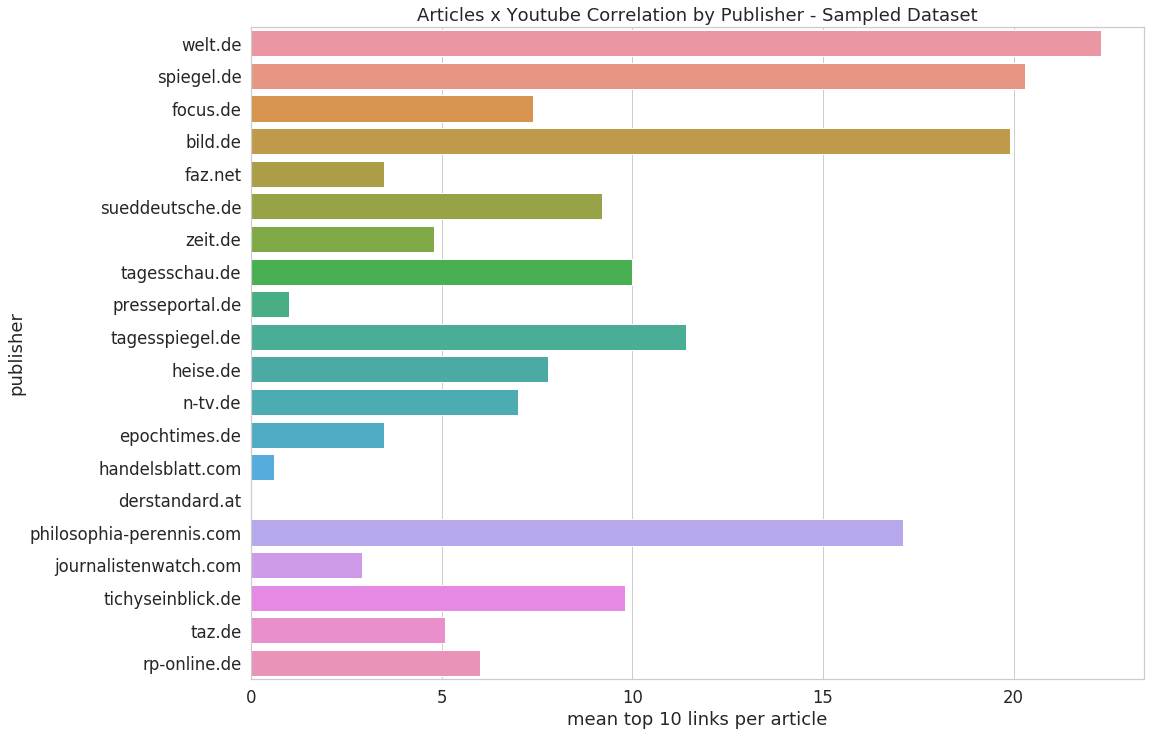

In [29]:
plt.figure(figsize=(16,12))
ax = sns.barplot(y=article_x_yt_df['publisher'], x=article_x_yt_df['mean top 10 links per article'])
ax.set_title("Articles x Youtube Correlation by Publisher - Sampled Dataset")
ax.set_xlabel("mean top 10 links per article")

Text(0.5,0,'mean links per article')

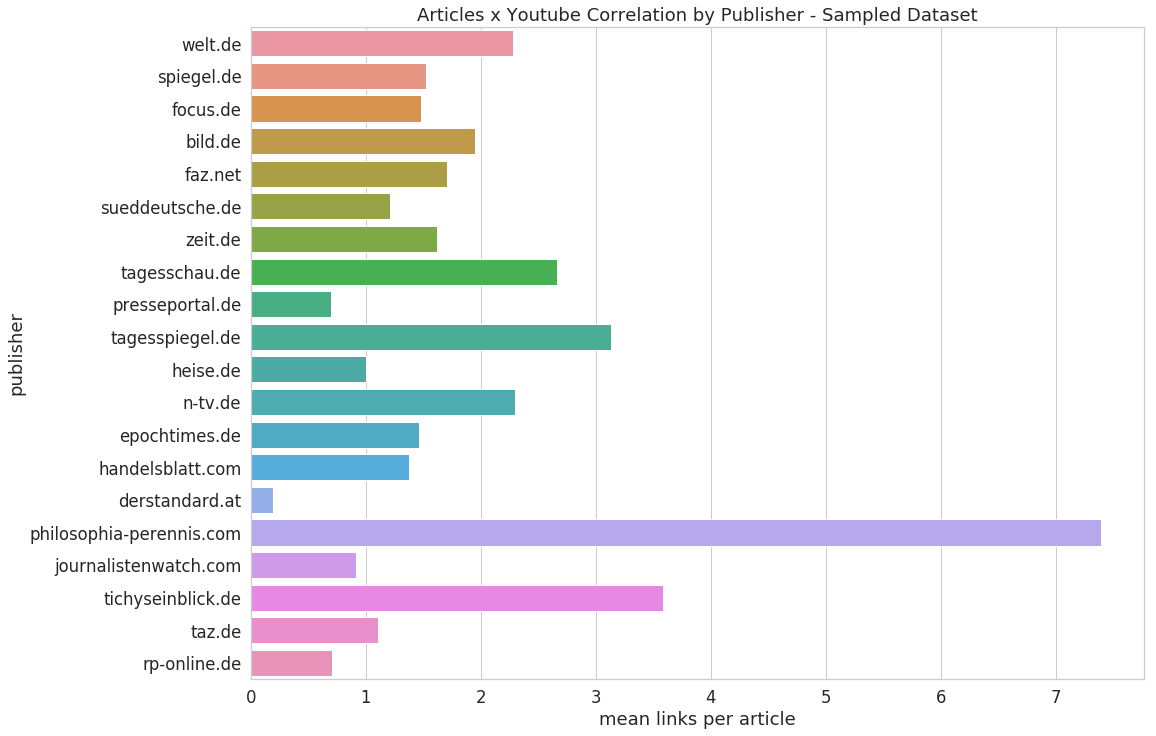

In [31]:
plt.figure(figsize=(16,12))
ax = sns.barplot(y=article_x_yt_df['publisher'], x=article_x_yt_df['mean yt links per article'])
ax.set_title("Articles x Youtube Correlation by Publisher - Sampled Dataset")
ax.set_xlabel("mean links per article")

Text(0.5,0,'articles that can be assigned to youtube links by hashtags (mean) ')

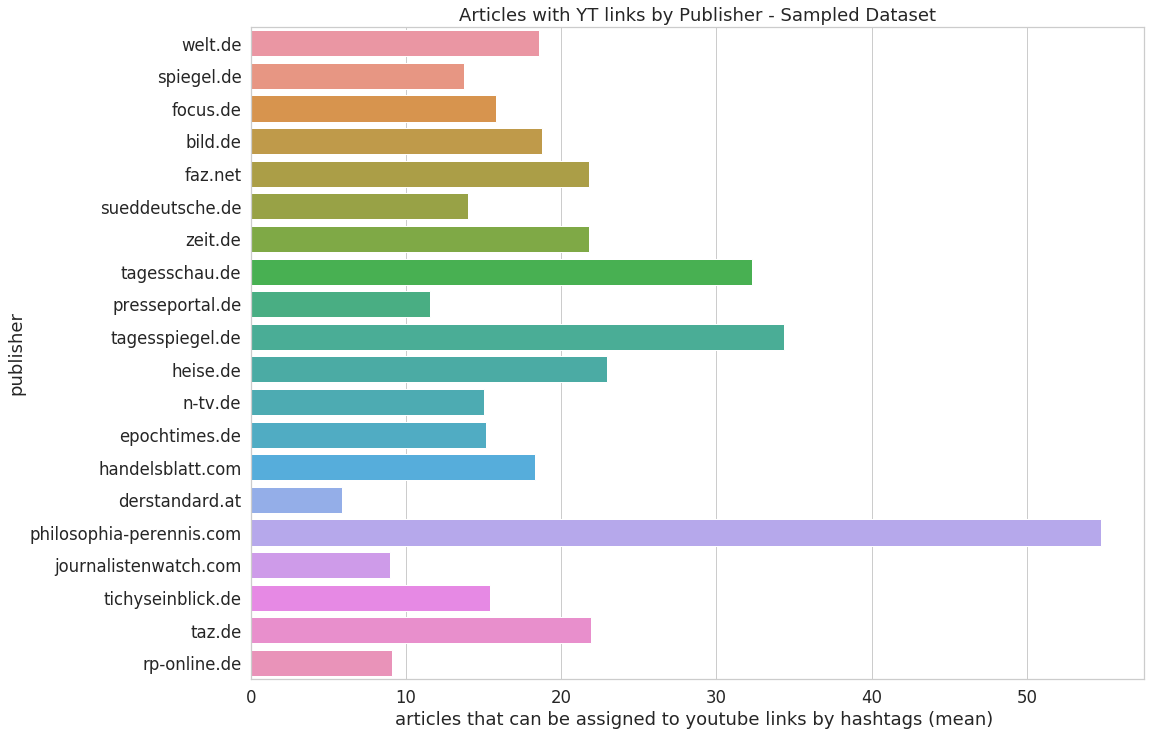

In [33]:
plt.figure(figsize=(16,12))
ax = sns.barplot(y=article_x_yt_df['publisher'], x=article_x_yt_df['% articles with yt links'])
ax.set_title("Articles with YT links by Publisher - Sampled Dataset")
ax.set_xlabel("articles that can be assigned to youtube links by hashtags (mean) ")

## Youtube URLs with Articles by Hashtags

In [158]:
def compareHashtags(hashtags_a_dict, hashtags_b_dict):
    matches = 0
    for hashtag_a in hashtags_a_dict.keys():
        if hashtag_a in hashtags_b_dict:
            if hashtags_a_dict[hashtag_a] <= hashtags_b_dict[hashtag_a]:
                matches += hashtags_a_dict[hashtag_a]
            else:
                matches += hashtags_b_dict[hashtag_a]
    return matches
    if matches > 0:
        print(matches)
        print(hashtags_a_dict, hashtags_b_dict)

def common_member(a, b):
    
    a_set = set(a)
    b_set = set(b)
    #print(a_set, b_set)
    if (a_set & b_set):
        return True
    else:
        return False

In [66]:
urls_by_publisher = urlsS[urlsS['top_level_domain'].isin(top_publisher)]
print(len(urls_by_publisher))

8217


In [114]:
hashtags_by_article_url = {}
distinct_urls = urls_by_publisher['resolved_url'].unique()
print(len(distinct_urls))
for article in distinct_urls:
    hashtags = getHashtagsFromURL(article, urlsS, hashtagsS)
    
    if len(hashtags>0):
        hashtags_by_article_url[article] = hashtags['hashtag'].value_counts().to_dict()
    

5517


In [115]:
len(hashtags_by_article_url)

2190

In [142]:
len(distinct_urls)

5517

In [147]:
hashtags_by_article_url['http://www.spiegel.de/spiegel/print/index-2018-17.html']

{'AfD': 1, 'Bundestag': 1, 'Deutschland': 1, 'Hamburg': 1, 'Spiegel': 1}

In [213]:
def getHashtagsFromURL(url, urls, hashtags):
    return hashtags[ hashtags['tweet_id'].isin(urls[urls['resolved_url'] == url]['tweet_id'])]

youtube_with_article_matches = {}

for yt_url, count in youtube_urls_s['resolved_url'].value_counts().iteritems():
    #print(yt_url, count)
    hashtags_yt_url = getHashtagsFromURL(yt_url, urlsS, hashtagsS)
    #print(hashtags_yt_url['hashtag'].value_counts())
    if len(hashtags_yt_url > 0):
        article_matched = []
        article_match_count = []
        for article_url in distinct_urls:
            
            #print(article_url)
            if article_url in hashtags_by_article_url.keys():
                #print(article_url)
                #print(hashtags_article_url)
                hashtags_article_url = hashtags_by_article_url[article_url]
                #print(article_url)
                #print(hashtags_article_url['hashtag'].value_counts().to_dict())
                if common_member(hashtags_yt_url['hashtag'].values,
                                 hashtags_article_url.keys()):
                    print(yt_url)
                    print(article_url)
                    print(hashtags_yt_url['hashtag'].value_counts())
                    print(hashtags_article_url)
                    matches = compareHashtags(hashtags_yt_url['hashtag'].value_counts().to_dict(), 
                                              hashtags_article_url)
                    article_matched.append(article_url)
                    article_match_count.append(matches)
                    
                    print(matches)
        article_x_yt_matches = pd.Series(data=article_match_count, index=article_matched)
        
        youtube_with_article_matches[yt_url] = article_x_yt_matches.sort_values(ascending=False)

https://www.youtube.com/watch?v=zvKjfWSPI7s
http://faktenfinder.tagesschau.de/ausland/toronto-131.html
Funk                    2
dankechico              2
faktenfinder            1
ReconquistaInternet     1
ReconquistaGermanica    1
Hass                    1
Name: hashtag, dtype: int64
{'faktenfinder': 2}
1
https://www.youtube.com/watch?v=zvKjfWSPI7s
http://faktenfinder.tagesschau.de/hintergrund/antisemitismus-147.html
Funk                    2
dankechico              2
faktenfinder            1
ReconquistaInternet     1
ReconquistaGermanica    1
Hass                    1
Name: hashtag, dtype: int64
{'PMK': 1, 'Statistik': 1, 'PKS': 1, 'Antisemitismus': 1, 'faktenfinder': 1}
1
https://www.youtube.com/watch?v=zvKjfWSPI7s
http://faktenfinder.tagesschau.de/ausland/trumps-aeusserungen-101.html
Funk                    2
dankechico              2
faktenfinder            1
ReconquistaInternet     1
ReconquistaGermanica    1
Hass                    1
Name: hashtag, dtype: int64
{'Rassismus': 1

https://www.welt.de/politik/deutschland/article175922511/Emnid-Umfrage-Union-sinkt-in-Waehlerumfrage-auf-Jahrestief.html
AfD                10
Bundestag          8 
Diesel             1 
Volksverhetzung    1 
BAMF               1 
Bremen             1 
UNWRA              1 
Otten              1 
Israel             1 
Russland           1 
G7                 1 
Name: hashtag, dtype: int64
{'Nahles': 1, 'Sicherheit': 1, 'Flüchtlinge': 1, 'AfD': 1, 'CSU': 1, 'Merkel': 1}
1
https://www.youtube.com/channel/UC_dZp8bZipnjntBGLVHm6rw/about?sub_confirmation=1
https://www.zeit.de/news/2018-04/13/deutschland-union-kritisiert-afd-anfrage-zu-behinderten-komplett-menschenverachtend-13171402
AfD                10
Bundestag          8 
Diesel             1 
Volksverhetzung    1 
BAMF               1 
Bremen             1 
UNWRA              1 
Otten              1 
Israel             1 
Russland           1 
G7                 1 
Name: hashtag, dtype: int64
{'AfD': 1, 'Merkel': 2}
1
https://www.youtub

https://www.youtube.com/watch?v=fAYjSLtz6wQ&feature=youtu.be
http://www.sueddeutsche.de/muenchen/freising/soziale-netzwerke-freisinger-afd-politiker-posierten-mit-hitlergruss-auf-der-zugspitze-1.3956117
ReconquistaInternet    4
DankeChico             2
dankechico             1
noafd                  1
Name: hashtag, dtype: int64
{'noafd': 2}
1
https://www.youtube.com/watch?v=fAYjSLtz6wQ&feature=youtu.be
https://www.taz.de/Identitaeren-Kader-als-AfD-Mitarbeiter/!5498788/
ReconquistaInternet    4
DankeChico             2
dankechico             1
noafd                  1
Name: hashtag, dtype: int64
{'noafd': 1, 'netzwerkafd': 1, 'afd': 1}
1
https://www.youtube.com/watch?v=fAYjSLtz6wQ&feature=youtu.be
http://amp.tagesspiegel.de/berlin/uebergriffe-bei-demo-in-cottbus-rechte-beschimpfen-und-attackieren-journalisten/20870410.html
ReconquistaInternet    4
DankeChico             2
dankechico             1
noafd                  1
Name: hashtag, dtype: int64
{'noafd': 1, 'Rechtsextremismus': 1, 

https://www.youtube.com/watch?v=xsarQ8O58YM&feature=youtu.be
https://www.zeit.de/news/2018-01/17/telekommunikation-kaspersky-entdeckt-maechtige-android-spionagesoftware-17105602
Zagg             1
Android          1
Displayschutz    1
AmazonDE         1
Schutzglass      1
Belkin           1
Name: hashtag, dtype: int64
{'Android': 1}
1
https://www.youtube.com/watch?v=xsarQ8O58YM&feature=youtu.be
https://www.heise.de/developer/meldung/App-Marktanalyse-2017-Umsaetze-und-Nutzung-nehmen-deutlich-zu-3945999.html
Zagg             1
Android          1
Displayschutz    1
AmazonDE         1
Schutzglass      1
Belkin           1
Name: hashtag, dtype: int64
{'Android': 2, 'iOS': 2}
1
https://www.youtube.com/watch?v=xsarQ8O58YM&feature=youtu.be
https://m.heise.de/newsticker/meldung/XprivacyLua-Android-Anwendungen-mit-falschen-Daten-fuettern-3946079.html
Zagg             1
Android          1
Displayschutz    1
AmazonDE         1
Schutzglass      1
Belkin           1
Name: hashtag, dtype: int64
{'And

https://www.youtube.com/watch?v=C5_PLHGBFv0&feature=youtu.be
http://www.faz.net/aktuell/wissen/medizin-ernaehrung/homoeopathie-die-zeit-des-gegeneinanders-ist-vorbei-14357551.html
Homöopathie    3
Arthritis      3
Homeopathy     3
homöopathie    1
Name: hashtag, dtype: int64
{'Homöopathie': 2}
2
https://www.youtube.com/watch?v=C5_PLHGBFv0&feature=youtu.be
https://www.welt.de/politik/deutschland/article175639519/Therapie-von-Fluechtlingen-Mit-Globuli-gegen-Kriegstraumata.html
Homöopathie    3
Arthritis      3
Homeopathy     3
homöopathie    1
Name: hashtag, dtype: int64
{'Homöopathie': 1}
1
https://www.youtube.com/watch?v=C5_PLHGBFv0&feature=youtu.be
https://rp-online.de/leben/gesundheit/medizin/wie-aerzte-ihre-patienten-gefaehrden_aid-14458949
Homöopathie    3
Arthritis      3
Homeopathy     3
homöopathie    1
Name: hashtag, dtype: int64
{'Arzneimittelnebenwirkungen': 1, 'Verschwendung': 1, 'Gesundheitssystem': 1, 'Antibiotikaresistenzen': 1, 'Skeptiker': 1, 'Homöopathie': 1}
1
https:/

Name: hashtag, dtype: int64
{'Spione': 1, 'Wirtschaft': 1, 'Iran': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=BKaq-SWIh7c&feature=youtu.be
https://www.tichyseinblick.de/feuilleton/medien/maischberger-eine-kurz-geschichte/
Dessau           1
Windhose         1
Tornado          1
Sturm            1
Orkan            1
Sachsen          1
Unwetter         1
Hurrican         1
SachsenAnhalt    1
Deutschland      1
Name: hashtag, dtype: int64
{'ARD': 1, 'AfDwirkt': 1, 'Bundeskanzler': 1, 'Hayali': 1, 'Moma': 1, 'AfD': 1, 'Maischberger': 2, 'Kurz': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=BKaq-SWIh7c&feature=youtu.be
http://www.taz.de/!5478465/
Dessau           1
Windhose         1
Tornado          1
Sturm            1
Orkan            1
Sachsen          1
Unwetter         1
Hurrican         1
SachsenAnhalt    1
Deutschland      1
Name: hashtag, dtype: int64
{'Survivor': 1, 'Sachsen': 1, 'wasfehlt': 1}
1
https://www.youtube.com/watch?v=BKaq-SWIh7c&feature=youtu.be
htt

https://www.youtube.com/watch?v=bcbO7p0i4hw&feature=youtu.be
https://www.presseportal.de/blaulicht/pm/69788/3845126?utm_source=dlvr.it&utm_medium=twitter
Themengärten        2
Baumsc              2
Gärten              2
Gartenideen         1
Gartenblog          1
Saarlouis           1
Hülzweiler          1
Gartengestaltung    1
Langhirt            1
Schwalbachsaar      1
Garten              1
Gartenbau           1
Saarland            1
Gartenliebe         1
Name: hashtag, dtype: int64
{'Saarland': 1, 'Blaulicht': 1}
1
https://www.youtube.com/watch?v=bcbO7p0i4hw&feature=youtu.be
https://www.bild.de/bild-plus/regional/saarland/adam-sucht-eva-gestrandet-im-paradies/belaestigungs-vorwuerfe-gegen-nackt-jesse-54531794,view=conversionToLogin.bild.html
Themengärten        2
Baumsc              2
Gärten              2
Gartenideen         1
Gartenblog          1
Saarlouis           1
Hülzweiler          1
Gartengestaltung    1
Langhirt            1
Schwalbachsaar      1
Garten              1
Gar

https://www.youtube.com/watch?v=KptXX_3BKbY
https://www.presseportal.de/blaulicht/pm/70116/3924028
Geschwindigkeit    2
DB                 2
Hotelzug           1
Friederike         1
BR103              1
Name: hashtag, dtype: int64
{'Dortmund': 1, 'DB': 1}
1
https://www.youtube.com/watch?v=KptXX_3BKbY
http://www.spiegel.de/spiegel/print/d-43064135.html
Geschwindigkeit    2
DB                 2
Hotelzug           1
Friederike         1
BR103              1
Name: hashtag, dtype: int64
{'Bonn': 1, 'Friederike': 1, 'Adenauer': 1, 'Fernverkehr': 1}
1
https://www.youtube.com/watch?v=KptXX_3BKbY
https://www.focus.de/regional/wettervorhersage-fuer-deutschland-160-km-h-sturm-wuetet-weiter-hier-schlaegt-orkan-friederike-jetzt-als-naechstes-zu_id_8323519.html
Geschwindigkeit    2
DB                 2
Hotelzug           1
Friederike         1
BR103              1
Name: hashtag, dtype: int64
{'Wetter': 4, 'Sturm': 4, 'Friederike': 4, 'Wettervorhersage': 4}
1
https://www.youtube.com/watch?v=KptXX_3B

Weidel    2
AfD       2
Name: hashtag, dtype: int64
{'CDU': 1, 'FDP': 1, 'Narragonien': 1, 'AfD': 1, 'SPD': 1, 'CSU': 1}
1
https://www.youtube.com/watch?v=eKrc5ripDbU&feature=youtu.be
http://www.faz.net/aktuell/politik/inland/kein-weiterer-wahlgang-fuer-afd-kandidat-glaser-15405915.html?utm_content=buffer88ccb&utm_medium=social&utm_source=twitter.com&utm_campaign=GEPC%253Ds30
Weidel    2
AfD       2
Name: hashtag, dtype: int64
{'Glaser': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=eKrc5ripDbU&feature=youtu.be
https://www.welt.de/politik/ausland/article172351048/Weltverfolgungsindex-von-Open-Doors-Christenverfolgung-wird-zur-Saeuberung.html
Weidel    2
AfD       2
Name: hashtag, dtype: int64
{'Islam': 1, 'AfD': 1, 'Christen': 1, 'Weltverfolgungsindex': 1}
1
https://www.youtube.com/watch?v=eKrc5ripDbU&feature=youtu.be
https://www.tichyseinblick.de/kolumnen/schaefflers-freisinn/juncker-spielt-ueber-bande-und-oekonomen-fallen-um/
Weidel    2
AfD       2
Name: hashtag, dtype: int64
{'Ill

https://www.youtube.com/watch?v=6VM5nPea9cw
https://www.tagesspiegel.de/politik/nach-neonazi-festival-in-ostritz-das-halbherzige-vorgehen-gegen-den-thueringer-npd-chef-thorsten-heise/21211104.html
Ostritz    2
Name: hashtag, dtype: int64
{'Neonazi': 1, 'NPD': 1, 'Ostritz': 1}
1
https://www.youtube.com/watch?v=6VM5nPea9cw
https://blog.zeit.de/stoerungsmelder/2018/04/22/ostritz-die-propaganda-show-der-npd_26165?wt_zmc=sm.ext.zonaudev.twitter.ref.zeitde.dskshare.link.x&utm_medium=sm&utm_source=twitter_zonaudev_ext&utm_campaign=ref&utm_content=zeitde_dskshare_link_x&t=Ostritz%3A+die+Propagandashow+der+NPD+-+St%C3%B6rungsmelder
Ostritz    2
Name: hashtag, dtype: int64
{'Ostritz': 1, 'Sachsen': 1}
1
https://www.youtube.com/watch?v=uwwdpnh7Uq4
http://www.faz.net/aktuell/wissen/medizin-ernaehrung/homoeopathie-die-zeit-des-gegeneinanders-ist-vorbei-14357551.html
Homöopathie    2
homeopathy     2
Name: hashtag, dtype: int64
{'Homöopathie': 2}
2
https://www.youtube.com/watch?v=uwwdpnh7Uq4
https:/

https://www.youtube.com/watch?v=H-CU49tGfyw
http://www.sueddeutsche.de/politik/kolumne-gemeinnutz-1.3832600
NEINzuNoBillag    2
NoBillag          2
servicepublic     2
Abst18            2
Name: hashtag, dtype: int64
{'probillag': 1, 'NoBillag': 2, 'Rundfunk': 2}
2
https://www.youtube.com/watch?v=DIchZhLYQZ0
http://www.spiegel.de/politik/deutschland/bjoern-hoecke-von-opel-beschaeftigen-bei-demo-abgedraengt-a-1204720.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'IGM': 1, 'Eisenach': 1, 'Opel': 3, 'AfD': 1, 'IGMetall': 1, 'Höcke': 2, 'SPD': 1}
1
https://www.youtube.com/watch?v=DIchZhLYQZ0
https://mobil.n-tv.de/politik/Kriminalitaet-sinkt-Unsicherheit-steigt-article20400082.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'SPD': 1}
1
https://www.youtube.com/watch?v=DIchZhLYQZ0
https://www.focus.de/politik/deutschland/aktueller-wahltrend-unionsparteien-rutschen-in-umfrage-zwei-punkte-ab-spd-legt-wieder-zu_id_8829924.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'

http://www.tagesschau.de/ausland/feinstaub-deutschland-eu-101.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'climatechange': 1, 'SPD': 1, 'contractofparis': 1, 'Besseres': 1, 'Streit': 1}
1
https://www.youtube.com/watch?v=DIchZhLYQZ0
http://www.tagesschau.de/multimedia/video/video-366391.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'NoGroKo': 1, 'Groko': 1, 'SPD': 1}
2
https://www.youtube.com/watch?v=DIchZhLYQZ0
http://www.tagesschau.de/kommentar/groko-hassel-101.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'SPD': 2, 'Union': 2, 'GroKo': 2}
2
https://www.youtube.com/watch?v=DIchZhLYQZ0
https://www.focus.de/finanzen/steuern/betrifft-millionen-abschaffung-der-abgeltungssteuer-groko-will-sparer-weiter-schroepfen_id_8318199.html
SPD      2
Groko    2
Name: hashtag, dtype: int64
{'Pack': 1, 'SPD': 1, 'Merkel': 1}
1
https://www.youtube.com/watch?v=DIchZhLYQZ0
https://www.journalistenwatch.com/2018/01/18/es-geht-voran-spd-nur-noch-bei-18-prozent/
SPD      2
Gro

https://www.youtube.com/watch?v=mmALd_IZe_U&feature=youtu.be
https://www.n-tv.de/panorama/Bocuse-war-ein-Jahrhundertkoch-article20242585.html
food           2
foodblogger    1
foodgasm       1
foodie         1
foodlover      1
Foodporn       1
foodstagram    1
barbecue       1
lecker         1
wochenende     1
grill          1
BBQ            1
foodpic        1
foodblog       1
foodpics       1
bier           1
essen          1
cooking        1
kochen         1
Name: hashtag, dtype: int64
{'Bocuse': 1, 'Gourmet': 1, 'Lyon': 1, 'france': 1, 'frankreich': 1, 'michelin': 1, 'food': 1, 'Essen': 1}
1
https://www.youtube.com/watch?v=Wl-pRxqg9UA&feature=youtu.be&a
http://www.tagesschau.de/ausland/molenbeek-141.html
letsplay      2
aberration    2
deutsch       2
Name: hashtag, dtype: int64
{'deutsch': 1}
1
https://www.youtube.com/watch?v=Wl-pRxqg9UA&feature=youtu.be&a
http://www.tagesschau.de/kommentar/macron-391.html
letsplay      2
aberration    2
deutsch       2
Name: hashtag, dtype: int64


Wendezeit      2
AfD            2
Syrien         2
Syrienreise    2
AfDwirkt       2
Retweet        1
Bundestag      1
Hampel         1
Landtag        1
Name: hashtag, dtype: int64
{'CDU': 1, 'AfD': 1, 'CSU': 1}
1
https://www.youtube.com/watch?v=JXZFCQXApEY
https://www.tichyseinblick.de/feuilleton/medien/maischberger-eine-kurz-geschichte/
Wendezeit      2
AfD            2
Syrien         2
Syrienreise    2
AfDwirkt       2
Retweet        1
Bundestag      1
Hampel         1
Landtag        1
Name: hashtag, dtype: int64
{'ARD': 1, 'AfDwirkt': 1, 'Bundeskanzler': 1, 'Hayali': 1, 'Moma': 1, 'AfD': 1, 'Maischberger': 2, 'Kurz': 1, 'Deutschland': 1}
2
https://www.youtube.com/watch?v=JXZFCQXApEY
https://www.focus.de/politik/deutschland/wie-sicher-fuehlen-sich-frauen-in-deutschland-entsetzt-schob-ich-die-haende-weg-dieses-bild-hat-sich-eingebrannt_id_6462730.html
Wendezeit      2
AfD            2
Syrien         2
Syrienreise    2
AfDwirkt       2
Retweet        1
Bundestag      1
Hampel         

https://www.youtube.com/watch?v=z1YbplD-lNA
https://www.welt.de/politik/deutschland/article175796502/Joschka-Fischer-Ex-Aussenminister-Angela-Merkel-ist-ein-Glueck-fuer-das-Land.html
lanz    1
Name: hashtag, dtype: int64
{'senil': 1, 'Kreuz': 1, 'Merkelmussweg': 2, 'kippa': 1, 'Schenkelklopfer': 1, 'lanz': 1, 'AfD': 1, 'Merkel': 2, 'Grünen': 1}
1
https://www.youtube.com/watch?v=z1YbplD-lNA
https://www.focus.de/politik/ausland/neues-gesetz-der-regierung-millionen-geflohenen-syrern-droht-die-enteignung-und-damit-das-exil_id_8802617.html
lanz    1
Name: hashtag, dtype: int64
{'Syrer': 1, 'fdp': 1, 'zdf': 1, 'Flüchtlinge': 1, 'csu': 1, 'lanz': 1, 'Syrien': 1, 'cdu': 1, 'afd': 1, 'Aleppo': 1, 'syrien': 1, 'annewill': 1}
1
https://www.youtube.com/watch?v=NKrLmeJXoHc&feature=youtu.be
http://www.handelsblatt.com/technik/hannovermesse/hannover-messe-siemens-chef-kaeser-warnt-vor-kasino-kapitalismus/21197260.html?social=tw-hb_hk-li-ne-or-
HM18    2
Name: hashtag, dtype: int64
{'HM18': 1, 'Kaeser

https://www.youtube.com/watch?v=IK9XMdi6VvU&feature=youtu.be
https://www.welt.de/politik/ausland/article173471518/Daenemark-Sozialdemokraten-wollen-Asylrecht-abschaffen.html?wtmc=socialmedia.twitter.shared.web
Apple       2
Canon       1
Dänemark    1
Name: hashtag, dtype: int64
{'Dänemark': 1}
1
https://www.youtube.com/watch?v=IK9XMdi6VvU&feature=youtu.be
https://www.heise.de/mac-and-i/meldung/Apple-Chef-Tim-Cook-Angela-Merkel-ist-phaenomenale-Fuehrungspersoenlichkeit-3943989.html
Apple       2
Canon       1
Dänemark    1
Name: hashtag, dtype: int64
{'TimCook': 2, 'Apple': 2}
2
https://www.youtube.com/watch?v=IK9XMdi6VvU&feature=youtu.be
https://www.heise.de/mac-and-i/meldung/BMW-Apples-CarPlay-schon-jetzt-nur-als-Abo-3944683.html
Apple       2
Canon       1
Dänemark    1
Name: hashtag, dtype: int64
{'CarPlay': 2, 'Apple': 2}
2
https://www.youtube.com/watch?v=IK9XMdi6VvU&feature=youtu.be
https://www.heise.de/mac-and-i/meldung/HomePod-naht-Auftragsfertiger-beginnt-angeblich-mit-Lieferu

1
https://www.youtube.com/channel/UCNz-EGSd5BXEoTcLcYCGsig/
https://www.heise.de/tp/features/AfD-Die-Masken-fallen-3830717.html
Bundestag    2
Wildberg     2
AfD          2
AfDwirkt     2
Name: hashtag, dtype: int64
{'AfD': 1, 'bundestag': 1}
1
https://www.youtube.com/channel/UCNz-EGSd5BXEoTcLcYCGsig/
https://amp.welt.de/amp/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html?__twitter_impression=true
Bundestag    2
Wildberg     2
AfD          2
AfDwirkt     2
Name: hashtag, dtype: int64
{'Verwandtenehen': 1, 'AfD': 1, 'Migration': 1, 'Inzest': 1}
1
https://www.youtube.com/channel/UCNz-EGSd5BXEoTcLcYCGsig/
http://m.faz.net/aktuell/politik/inland/nach-der-wahl-von-nahles-die-spd-in-der-sackgasse-15554857.html
Bundestag    2
Wildberg     2
AfD          2
AfDwirkt     2
Name: hashtag, dtype: int64
{'SPD': 1, 'AfD': 1, 'Schandmaul': 1}
1
https://www.youtube.com/channel/UCNz-EGSd5BXEoTcLcYCGsig/
https://www.bild.de/politik/ausland/aserbaidschan/korruptionsverdacht-im-eur

https://www.youtube.com/watch?v=ROshnEJOk6I
http://www.faz.net/aktuell/rhein-main/wirtschaft/savedroid-staatsanwaltschaft-prueft-verdacht-auf-betrug-15551048.html?GEPC=s3
ICO               2
Business          1
DDoS              1
Ethereum          1
Technology        1
Security          1
Crypto            1
Cryptocurrency    1
Blockchain        1
Startup           1
Name: hashtag, dtype: int64
{'ICO': 1}
1
https://www.youtube.com/watch?v=ROshnEJOk6I
http://www.sueddeutsche.de/geld/messe-mipim-tanz-am-ausgang-1.3906258#redirectedFromLandingpage
ICO               2
Business          1
DDoS              1
Ethereum          1
Technology        1
Security          1
Crypto            1
Cryptocurrency    1
Blockchain        1
Startup           1
Name: hashtag, dtype: int64
{'Blockchain': 1}
1
https://www.youtube.com/watch?v=ROshnEJOk6I
https://www.heise.de/security/meldung/Satori-Botnetz-hat-es-auf-Ethereum-Miner-abgesehen-3946840.html
ICO               2
Business          1
DDoS          

Bundestag    1
AfD          1
Reusch       1
Name: hashtag, dtype: int64
{'CDU': 1, 'D': 1, 'Flüchtlingskrise': 2, 'EU': 1, 'SPD': 1, 'ZDF': 1, 'AfD': 2, 'GroKo': 1, 'CSU': 1}
1
https://www.youtube.com/watch?v=H6ag6iNKp1o
https://www.welt.de/wirtschaft/article172370913/Viktor-Orban-Ungarns-Ministerpraesident-erinnert-Deutschland-an-seine-Fuehrungsaufgaben.html
Bundestag    1
AfD          1
Reusch       1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=H6ag6iNKp1o
http://www.epochtimes.de/politik/deutschland/soeder-fordert-haertere-gangart-gegen-die-afd-union-war-bisher-zu-zurueckhaltend-a2320839.html
Bundestag    1
AfD          1
Reusch       1
Name: hashtag, dtype: int64
{'Islam': 1, 'Bayern': 1, 'LtwBy': 1, 'AfDwirkt': 1, 'AfD': 1, 'CSU': 1, 'Söder': 1}
1
https://www.youtube.com/watch?v=H6ag6iNKp1o
https://www.welt.de/newsticker/dpa_nt/infoline_nt/brennpunkte_nt/article172453750/Soeder-fordert-haertere-Gangart-gegen-die-AfD.html?wtmc=socialmedia.twitter.share

https://www.youtube.com/watch?v=Frb0s6ppZlo&feature=youtu.be&a
https://www.heise.de/newsticker/meldung/Nintendo-Labo-bei-der-USK-Ist-das-Kunst-oder-kann-das-weg-3946740.html
MarioKart    2
Nintendo     2
Youtube      2
Letsplay     2
Smutur       2
Name: hashtag, dtype: int64
{'WTF': 2, 'Nintendo': 2}
2
https://www.youtube.com/watch?v=RTIQPE6M1hg&feature=youtu.be&a
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
gaming           2
letsplay         2
GermanMediaRT    2
rpg              2
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=KJal1InlLgE
https://www.welt.de/politik/deutschland/article175796502/Joschka-Fischer-Ex-Aussenminister-Angela-Merkel-ist-ein-Glueck-fuer-das-Land.html
lanz    1
Name: hashtag, dtype: int64
{'senil': 1, 'Kreuz': 1, 'Merkelmussweg': 2, 'kippa': 1, 'Schenkelklopfer': 1, 'lanz': 1, 'AfD': 1, 'Merkel': 2, 'Grünen': 1}
1
https://www.youtube.com/watch?v=KJ

Name: hashtag, dtype: int64
{'Islamisierung': 1, 'AfDimBundestag': 1, 'Kandel': 1, 'Merkel': 1, 'AfDwirkt': 1}
1
https://www.youtube.com/watch?v=r6hvOcIlS4M
http://www.spiegel.de/politik/deutschland/afd-erzwingt-abbruch-von-sitzung-im-bundestag-a-1188688.html
Bundestag    2
Wildberg     2
AfD          2
AfDwirkt     2
Name: hashtag, dtype: int64
{'AfD': 1, 'Bundestag': 1}
2
https://www.youtube.com/watch?v=r6hvOcIlS4M
https://www.zeit.de/gesellschaft/zeitgeschehen/2018-01/freital-prozess-terrorismus-rechtsextremismus
Bundestag    2
Wildberg     2
AfD          2
AfDwirkt     2
Name: hashtag, dtype: int64
{'Terror': 1, 'Freital': 1, 'Jährling': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=r6hvOcIlS4M
https://m.bild.de/regional/muenchen/abschiebung/nuernberger-arzt-meine-frau-wurde-nach-thailand-abgeschoben-54521452.bildMobile.html
Bundestag    2
Wildberg     2
AfD          2
AfDwirkt     2
Name: hashtag, dtype: int64
{'CDU': 1, 'DuGlaubstEsNicht': 1, 'spdbpt18': 1, 'AfD': 1, 'Groko': 1,

https://www.youtube.com/watch?v=z-tdAHh-ztw&feature=youtu.be
http://m.spiegel.de/politik/deutschland/tuerkischer-aussenminister-mevluet-cavusoglu-will-in-solingen-reden-a-1204335.html
Nazis    2
Name: hashtag, dtype: int64
{'Faschist': 1, 'Tuerkei': 1, 'Nazis': 1}
1
https://www.youtube.com/watch?v=z-tdAHh-ztw&feature=youtu.be
https://philosophia-perennis.com/2018/04/26/buchlesung-mit-dr-weissmann-ueber-die-68-er-fuehrt-in-muenster-zu-linksradikalen-tumulten/
Nazis    2
Name: hashtag, dtype: int64
{'Antifa': 1, 'Rechts': 1, 'Nazis': 1}
1
https://www.youtube.com/watch?v=z-tdAHh-ztw&feature=youtu.be
https://philosophia-perennis.com/2018/01/21/rechte-cottbus/
Nazis    2
Name: hashtag, dtype: int64
{'Cottbus': 1, 'Nazis': 1, 'AufdieStrasse': 1}
1
https://www.youtube.com/watch?v=OneZIwi-M4U
https://www.tagesspiegel.de/berlin/30-jahre-oppositionelle-luxemburg-demo-kampf-um-die-freiheit-der-andersdenkenden/20844624.html
Luxemburg     1
LLL           1
b1401         1
Liebknecht    1
LLDemo    

https://www.youtube.com/watch?v=xwNlmcRuPdI&feature=youtu.be
http://www.sueddeutsche.de/wirtschaft/altersvorsorge-rentenplaene-der-koalition-sind-unbezahlbar-1.3955885
GroKo    1
Name: hashtag, dtype: int64
{'Rente': 1, 'Rentenpläne': 1, 'generationengerecht': 1, 'GroKo': 1, 'enkelfit': 1}
1
https://www.youtube.com/watch?v=xwNlmcRuPdI&feature=youtu.be
http://www.tagesschau.de/inland/sofortprogramm-pflege-101.html
GroKo    1
Name: hashtag, dtype: int64
{'Pflege': 3, 'Pflegenotstand': 1, 'GroKo': 2}
1
https://www.youtube.com/watch?v=xwNlmcRuPdI&feature=youtu.be
https://m.bild.de/politik/inland/ursula-von-der-leyen/streitet-mit-scholz-um-12-milliarden-55543692.bildMobile.html
GroKo    1
Name: hashtag, dtype: int64
{'Militär': 1, 'AbrüstenstattAufrüsten': 1, 'GroKo': 1}
1
https://www.youtube.com/watch?v=xwNlmcRuPdI&feature=youtu.be
https://www.focus.de/politik/deutschland/groko-im-news-ticker-barley-draengt-auf-aenderung-von-paragraf-219a-kauder-weist-spd-beschluss-als-nicht-akzeptabel-zur

https://www.youtube.com/watch?v=1x0QZFBAyhs&feature=youtu.be
https://www.focus.de/wissen/mensch/echo-echo_id_8829419.html
Echo        1
Heuchler    1
Name: hashtag, dtype: int64
{'Skandal': 1, 'abgeschafft': 1, 'Musikpreis': 1, 'EchoVerleihung': 1, 'Echo': 1}
1
https://www.youtube.com/watch?v=1x0QZFBAyhs&feature=youtu.be
https://www.welt.de/politik/deutschland/article175825527/Berlin-Neukoelln-Angriffe-bei-Demo-gegen-Antisemitismus-Veranstalter-brechen-ab.html
Echo        1
Heuchler    1
Name: hashtag, dtype: int64
{'herrmannplatz': 1, 'berlintraegtkippa': 1, 'Antisemitismus': 2, 'Heuchler': 1}
1
https://www.youtube.com/watch?v=1x0QZFBAyhs&feature=youtu.be
http://www.spiegel.de/kultur/musik/echo-wird-nach-skandal-um-kollegah-und-farid-bang-komplett-abgeschafft-a-1204745.html
Echo        1
Heuchler    1
Name: hashtag, dtype: int64
{'Echo': 1}
1
https://www.youtube.com/watch?v=1x0QZFBAyhs&feature=youtu.be
https://www.zeit.de/kultur/musik/2018-04/musikpreis-echo-wird-abgeschafft?utm_conte

https://www.youtube.com/watch?v=wvwYp8mPzDM&feature=youtu.be&a
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
switchRTs        1
gaming           1
gaming4life      1
letsplay         1
germanmediaRT    1
youtuber         1
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=FN1vHm1LPzw
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
AlternativeMitte      1
AM                    1
AfD                   1
Deutschlandtreffen    1
Deutschlandtagung     1
Dinslaken             1
AfDwirkt              1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=FN1vHm1LPzw
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die

https://philosophia-perennis.com/2018/01/20/netzdg-eu/
AlternativeMitte      1
AM                    1
AfD                   1
Deutschlandtreffen    1
Deutschlandtagung     1
Dinslaken             1
AfDwirkt              1
Name: hashtag, dtype: int64
{'EU': 1, 'AfD': 1, 'NetzDG': 1, 'DDR2': 1, 'Zensur': 1}
1
https://www.youtube.com/watch?v=FN1vHm1LPzw
https://www.welt.de/politik/article172675144/Berlin-Fluechtling-soll-4-jaehrige-Tochter-seiner-Pflegefamilie-missbraucht-haben.html
AlternativeMitte      1
AM                    1
AfD                   1
Deutschlandtreffen    1
Deutschlandtagung     1
Dinslaken             1
AfDwirkt              1
Name: hashtag, dtype: int64
{'umf': 1, 'Kika': 1, 'Selbstmord': 1, 'Kandel': 1, 'Flüchtling': 1, 'Altersfeststellung': 2, 'UMF': 1, 'Berlin': 1, 'Wahnsinn': 1, 'Rechtsstaat': 1, 'Straftäter': 1, 'RefugeesWelcome': 3, 'Asylbewerber': 1, 'Deutschland': 1, 'Missbrauch': 2, 'AfD': 1, 'Krminalität': 1, 'spdbt18': 1, 'mufl': 1, 'kindesmissbrauch': 1}

https://www.youtube.com/watch?v=ZMA2BS1r3aM&feature=youtu.be
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
dersorbus      1
letsplay       1
GodofWar       1
dersorbusyt    1
RETWEEET       1
gaming         1
GoW            1
retweet        1
zocken         1
youtube        1
sorbport       1
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=_v2Uz91gxNA&feature=youtu.be
http://www.tagesschau.de/wirtschaft/google-youtube-eltern-app-101.html
YouTube    1
Name: hashtag, dtype: int64
{'YouTube': 2}
1
https://www.youtube.com/watch?v=_v2Uz91gxNA&feature=youtu.be
https://www.heise.de/newsticker/meldung/Twitch-Streams-Gronkh-bekommt-eine-Rundfunklizenz-3941102.html
YouTube    1
Name: hashtag, dtype: int64
{'Politik': 1, 'Piraten': 2, 'YouTube': 3, 'Rundfunk': 3, 'Gronkh': 2, 'Netzpolitik': 2, 'Twitch': 2, 'Rundfunklizenz': 2}
1
https://www.youtube.com/watch?v=c0HOCEOPUNI&feature=youtu.b

2
https://www.youtube.com/watch?v=-ogD1dHucnE
https://www.epochtimes.de/politik/deutschland/samstag-15-uhr-es-reicht-frauenmarsch-zum-kanzleramt-wir-wollen-keine-schwedischen-verhaeltnisse-in-deutschland-a2325594.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=-ogD1dHucnE
http://www.tagesschau.de/kommentar/afd-bundestag-103.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 1, 'Kommentar': 1}
1
https://www.youtube.com/watch?v=-ogD1dHucnE
http://www.faz.net/aktuell/politik/inland/afd-und-geheimdienste-kindisch-15406966.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 1, 'Demokratie': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=-ogD1dHucnE
https://www.focus.de/politik/deutschland/afd-provoziert-der-rest-springt-drauf-auf-jetzt-zeigt-sich-die-afd-strategie-im-bundestag-und-alle-fallen-darauf-herein_id_8332563.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD'

https://www.youtube.com/watch?v=jlMe5rQQtgY
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
youtubegaming    1
letsplay         1
smallyoutuber    1
youtube          1
gaming           1
letsplayers      1
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=lKHHP5_7XyA&feature=youtu.be
https://www.presseportal.de/blaulicht/pm/74168/3924528
SachsenAnhalt    1
Koch             1
KeniaLSA         1
CDU              1
Name: hashtag, dtype: int64
{'3um3': 1, 'Magdeburg': 1, 'Dieb': 1, 'SachsenAnhalt': 1, 'bpol': 1}
1
https://www.youtube.com/watch?v=lKHHP5_7XyA&feature=youtu.be
https://www.n-tv.de/politik/Deutsche-Gefaengnisse-sind-voll-article20403661.html
SachsenAnhalt    1
Koch             1
KeniaLSA         1
CDU              1
Name: hashtag, dtype: int64
{'CDU': 1, 'CSU': 1}
1
https://www.youtube.com/watch?v=lKHHP5_7XyA&feature=youtu.be
https://www.welt.de/politik/deutschland/article

https://www.youtube.com/watch?v=2kIOvQjBtAw
https://www.focus.de/politik/deutschland/minister-mueller-fordert-mehr-etat-sollen-nicht-glauben-fluchtproblematik-sei-ueberwunden_id_8809654.html
ltby       1
CSU        1
Kreuz      1
Landtag    1
Name: hashtag, dtype: int64
{'CSU': 1}
1
https://www.youtube.com/watch?v=2kIOvQjBtAw
https://www.welt.de/politik/deutschland/article175796502/Joschka-Fischer-Ex-Aussenminister-Angela-Merkel-ist-ein-Glueck-fuer-das-Land.html
ltby       1
CSU        1
Kreuz      1
Landtag    1
Name: hashtag, dtype: int64
{'senil': 1, 'Kreuz': 1, 'Merkelmussweg': 2, 'kippa': 1, 'Schenkelklopfer': 1, 'lanz': 1, 'AfD': 1, 'Merkel': 2, 'Grünen': 1}
1
https://www.youtube.com/watch?v=2kIOvQjBtAw
http://www.spiegel.de/politik/deutschland/bayern-in-jeder-behoerde-muss-kuenftig-ein-kreuz-haengen-a-1204523.html
ltby       1
CSU        1
Kreuz      1
Landtag    1
Name: hashtag, dtype: int64
{'bullshit': 1, 'Bayern': 2, 'Mittelalter': 1, 'religionsfreiheit': 2, 'ekelhaft': 1, '

https://www.youtube.com/watch?v=nmDoUsk2f2U
https://www.presseportal.de/blaulicht/pm/4971/3923791
Dortmund    1
Sex         1
Name: hashtag, dtype: int64
{'Dortmund': 2, 'MeToo': 1}
1
https://www.youtube.com/watch?v=nmDoUsk2f2U
http://www.spiegel.de/spiegel/unispiegel/fh-dortmund-bietet-neuen-studiengang-fluechtlingshilfe-an-a-1196053.html
Dortmund    1
Sex         1
Name: hashtag, dtype: int64
{'Dortmund': 1, 'Flüchtlingshelfer': 2, 'bunt': 1, 'Migranten': 1, 'EinLandAmAbgrund': 1, 'Asyl': 1, 'Merkel': 1, 'CDU': 1, 'Germoney': 1, 'Abschiebungen': 1, 'AfD': 2, 'Groko': 1, 'Fakefugees': 1}
1
https://www.youtube.com/watch?v=nmDoUsk2f2U
https://www.presseportal.de/blaulicht/pm/4971/3923986
Dortmund    1
Sex         1
Name: hashtag, dtype: int64
{'Dortmund': 1, 'Amtsgerichts': 1}
1
https://www.youtube.com/watch?v=nmDoUsk2f2U
https://www.presseportal.de/blaulicht/pm/70116/3924028
Dortmund    1
Sex         1
Name: hashtag, dtype: int64
{'Dortmund': 1, 'DB': 1}
1
https://www.youtube.com/watch

https://www.youtube.com/watch?v=AnmaDERLTEU&feature=youtu.be
https://www.zeit.de/politik/2018-01/regierungsbildung-grosse-koalition-neuauflage-leserumfrage?sort=desc&page=1
GroKo            1
Jamaika          1
Tagesgespaech    1
Sondierungen     1
Name: hashtag, dtype: int64
{'SPD': 2, 'GroKo': 2}
1
https://www.youtube.com/watch?v=AnmaDERLTEU&feature=youtu.be
https://www.zeit.de/kultur/2018-01/martin-schulz-wahlkampf-wurst-deutschstunde
GroKo            1
Jamaika          1
Tagesgespaech    1
Sondierungen     1
Name: hashtag, dtype: int64
{'SPD': 1, 'MartinSchulz': 1, 'GroKo': 1}
1
https://www.youtube.com/watch?v=AnmaDERLTEU&feature=youtu.be
http://www.spiegel.de/politik/deutschland/spd-parteitag-in-bonn-das-grosse-zaehlen-und-zittern-a-1188415.html
GroKo            1
Jamaika          1
Tagesgespaech    1
Sondierungen     1
Name: hashtag, dtype: int64
{'knapp': 1, 'Parteitag': 1, 'SPD': 1, 'GroKo': 1, 'Abstimmung': 1}
1
https://www.youtube.com/watch?v=AnmaDERLTEU&feature=youtu.be
http

https://www.youtube.com/watch?v=vMJS0gEpXTU&feature=youtu.be
https://www.n-tv.de/wirtschaft/Porsche-blockiert-Abgas-Ermittlungen-article20403549.html
Tour         1
GTSRoutes    1
Community    1
GTS          1
Porsche      1
Ausfahrt     1
Name: hashtag, dtype: int64
{'Porsche': 1, 'Dieselskandal': 1}
1
https://www.youtube.com/watch?v=vMJS0gEpXTU&feature=youtu.be
https://www.tagesschau.de/inland/strafzahlungen-diesel-manipulation-101.html
Tour         1
GTSRoutes    1
Community    1
GTS          1
Porsche      1
Ausfahrt     1
Name: hashtag, dtype: int64
{'BMW': 1, 'Audi': 1, 'Dieselgate': 1, 'Autolobby': 1, 'Porsche': 1, 'Daimler': 1, 'VW': 1, 'Opel': 1}
1
https://www.youtube.com/watch?v=vMJS0gEpXTU&feature=youtu.be
https://www.zeit.de/wirtschaft/unternehmen/2018-04/abgasskandal-dieselauto-porsche-volkswagen-ermittlungen?utm_content=zeitde_redpost+_link_sf&utm_medium=sm&wt_zmc=sm.int.zonaudev.twitter.ref.zeitde.redpost.link.sf&utm_source=twitter_zonaudev_int&utm_campaign=ref
Tour     

1
https://www.youtube.com/watch?v=0yuU7TTuPLQ&feature=youtu.be
https://www.welt.de/politik/deutschland/article172672229/Angela-Merkel-ueber-Regierungsbildung-Versuche-meine-Pflichten-zu-erfuellen.html
MerkelTrump    1
Merkel         1
Trump          1
trumpvisit     1
Name: hashtag, dtype: int64
{'Merkel': 1}
1
https://www.youtube.com/watch?v=0yuU7TTuPLQ&feature=youtu.be
http://www.faz.net/aktuell/wirtschaft/ein-jahr-praesidentschaft-trump-in-zahlen-15407097.html
MerkelTrump    1
Merkel         1
Trump          1
trumpvisit     1
Name: hashtag, dtype: int64
{'Nachrichten': 1, 'Trump': 1}
1
https://www.youtube.com/watch?v=0yuU7TTuPLQ&feature=youtu.be
http://www.spiegel.de/politik/ausland/tuerkei-bodentruppen-marschieren-in-syrien-ein-a-1189000.html
MerkelTrump    1
Merkel         1
Trump          1
trumpvisit     1
Name: hashtag, dtype: int64
{'BuReg': 1, 'Syrien': 2, 'Kurden': 2, 'Gabriel': 1, 'YPG': 1, 'IS': 1, 'Afrin': 2, 'Erdogan': 2, 'Merkel': 1}
1
https://www.youtube.com/watch?v=0

https://www.youtube.com/watch?v=_a8FLUkZ4vw&feature=youtu.be
https://www.bild.de/sport/fussball/vfb-stuttgart/daten-panne-kegelt-stuttgart-profi-aus-startelf-54540276.bild.html?utm_source=dlvr.it&utm_medium=twitter
VfB       1
Thommy    1
Name: hashtag, dtype: int64
{'VfB': 2}
1
https://www.youtube.com/watch?v=sQiN2HmBwc0
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
youtubegaming    1
letsplay         1
smallyoutuber    1
youtube          1
gaming           1
letsplayers      1
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=VPffCJj6y9g&feature=youtu.be
http://www.spiegel.de/politik/deutschland/bjoern-hoecke-von-opel-beschaeftigen-bei-demo-abgedraengt-a-1204720.html
GroKo       1
SPD         1
spdbpt18    1
Name: hashtag, dtype: int64
{'IGM': 1, 'Eisenach': 1, 'Opel': 3, 'AfD': 1, 'IGMetall': 1, 'Höcke': 2, 'SPD': 1}
1
https://www.youtube.com/watch?v=VPffCJj6y9g&feature=youtu

{'SPD': 1, 'spdbpt18': 1}
2
https://www.youtube.com/watch?v=VPffCJj6y9g&feature=youtu.be
https://www.bild.de/politik/inland/martin-schulz/analyse-spd-ja-54547298.bild.html
GroKo       1
SPD         1
spdbpt18    1
Name: hashtag, dtype: int64
{'chocolates': 1, 'Schulz': 1, 'Tempo': 1, 'Djokovic': 1, 'farewell': 1, 'tissues': 1, 'GroKo': 1}
1
https://www.youtube.com/watch?v=VPffCJj6y9g&feature=youtu.be
https://www.welt.de/politik/deutschland/plus172672565/Deutsche-Fluechtlingspolitik-Ausgeblendete-Realitaeten.html?wtmc=socialmedia.twitter.shared.web
GroKo       1
SPD         1
spdbpt18    1
Name: hashtag, dtype: int64
{'GroKo': 1, 'Obergrenze': 1}
1
https://www.youtube.com/watch?v=VPffCJj6y9g&feature=youtu.be
http://www.handelsblatt.com/politik/deutschland/groko-streit-cdu-arbeitnehmer-schwenken-auf-spd-kurs/20869592.html
GroKo       1
SPD         1
spdbpt18    1
Name: hashtag, dtype: int64
{'SPD': 1, 'spdbpt18': 1, 'GroKo': 1}
3
https://www.youtube.com/watch?v=VPffCJj6y9g&feature=youtu.

https://www.youtube.com/watch?v=d7EHw4nqUYc&feature=youtu.be
http://www.spiegel.de/panorama/gesellschaft/mahnwache-fuer-hund-chico-in-hannover-unser-held-a-1204224.html
Chico        1
freechico    1
RIPChico     1
Name: hashtag, dtype: int64
{'Chico': 1}
1
https://www.youtube.com/watch?v=d7EHw4nqUYc&feature=youtu.be
http://www.spiegel.de/politik/ausland/jemen-mindestens-20-tote-bei-luftangriff-auf-eine-hochzeit-a-1204314.html
Chico        1
freechico    1
RIPChico     1
Name: hashtag, dtype: int64
{'Jemen': 1, 'Chico': 1}
1
https://www.youtube.com/watch?v=hUFPooqKllA&feature=youtu.be
https://www.zeit.de/kultur/musik/2018-01/dolores-o-riordan-saengerin-the-cranberries-gestorben
Cranberries    1
Name: hashtag, dtype: int64
{'Cranberries': 2}
1
https://www.youtube.com/watch?v=hUFPooqKllA&feature=youtu.be
https://www.focus.de/kultur/musik/weltweit-erfolgreiche-rockband-dolores-oriordan-cranberries-saengerin-stirbt-mit-46-jahren_id_8303189.html
Cranberries    1
Name: hashtag, dtype: int64
{

https://www.tagesspiegel.de/themen/agenda/betriebsratswahlen-im-fruehjahr-rechte-kandidaten-streben-in-die-betriebsraete/20849470.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=iGxfdoU_IEE
https://www.presseportal.de/blaulicht/pm/70238/3841113
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'Einzelfall': 1, 'Asyl': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=iGxfdoU_IEE
https://www.heise.de/tp/features/Oesterreich-Mit-permanenten-Tabubruechen-wird-eine-neue-Normalitaet-geschaffen-3943554.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 2}
1
https://www.youtube.com/watch?v=iGxfdoU_IEE
http://amp.handelsblatt.com/politik/deutschland/bundestagsausschuesse-gerangel-um-wichtige-posten-fuer-die-afd/20852088.html?__twitter_impression=true
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 1, 'Haushaltsausschuss': 1}
1
https://www.youtube.com/watch?v=iGxfdoU_IEE
https://www.tagesspie

https://www.presseportal.de/blaulicht/nr/11554
Speyer            1
GroKo             1
Höchst            1
Vergewaltigung    1
AfD               1
Zensur            1
NetzDG            1
Name: hashtag, dtype: int64
{'Nordstadt': 1, 'AfD': 1, 'Braunschweig': 1, 'Wolfenbüttel': 1}
1
https://www.youtube.com/watch?v=31hHmj2IpTI
http://www.faz.net/aktuell/politik/inland/steinmeier-gegen-volksabstimmungen-auf-bundesebene-15561953.html
Speyer            1
GroKo             1
Höchst            1
Vergewaltigung    1
AfD               1
Zensur            1
NetzDG            1
Name: hashtag, dtype: int64
{'DirekteDemokratie': 1, 'AfD': 1, 'Volksabstimmung': 1}
1
https://www.youtube.com/watch?v=31hHmj2IpTI
https://www.tichyseinblick.de/meinungen/das-eugh-urteil-c-15715-und-seine-kreative-umsetzung-in-deutschland/
Speyer            1
GroKo             1
Höchst            1
Vergewaltigung    1
AfD               1
Zensur            1
NetzDG            1
Name: hashtag, dtype: int64
{'Islamisierung': 2

https://www.youtube.com/watch?v=31hHmj2IpTI
http://www.tagesschau.de/inland/umfrage-spd-101.html
Speyer            1
GroKo             1
Höchst            1
Vergewaltigung    1
AfD               1
Zensur            1
NetzDG            1
Name: hashtag, dtype: int64
{'Sondierungen': 1, 'Union': 1, 'SPD': 1, 'GroKo': 1}
1
https://www.youtube.com/watch?v=31hHmj2IpTI
https://www.zeit.de/politik/2018-01/regierungsbildung-grosse-koalition-neuauflage-leserumfrage?sort=desc&page=1
Speyer            1
GroKo             1
Höchst            1
Vergewaltigung    1
AfD               1
Zensur            1
NetzDG            1
Name: hashtag, dtype: int64
{'SPD': 2, 'GroKo': 2}
1
https://www.youtube.com/watch?v=31hHmj2IpTI
https://www.presseportal.de/blaulicht/pm/70238/3841113
Speyer            1
GroKo             1
Höchst            1
Vergewaltigung    1
AfD               1
Zensur            1
NetzDG            1
Name: hashtag, dtype: int64
{'Einzelfall': 1, 'Asyl': 1, 'AfD': 1}
1
https://www.youtube.co

https://www.youtube.com/watch?v=uLP4SjGVefs
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
Bundestag                1
Meister                  1
Berufsbildungsbericht    1
AfD                      1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=uLP4SjGVefs
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
Bundestag                1
Meister                  1
Berufsbildungsbericht    1
AfD                      1
Name: hashtag, dtype: int64
{'PolizelicheKriminalstatistik': 1, 'HatEhKeinerGeglaubt': 1, 'AfD': 1, 'DPolGHH': 1, 'PKS': 2}
1
https://www.youtube.com/watch?v=uLP4SjGVefs
https://www.welt.de/politik/deutschland/article175520894/AfD-Politiker-

http://www.spiegel.de/politik/deutschland/afd-erzwingt-abbruch-von-sitzung-im-bundestag-a-1188688.html
Bundestag                1
Meister                  1
Berufsbildungsbericht    1
AfD                      1
Name: hashtag, dtype: int64
{'AfD': 1, 'Bundestag': 1}
2
https://www.youtube.com/watch?v=uLP4SjGVefs
https://www.zeit.de/gesellschaft/zeitgeschehen/2018-01/freital-prozess-terrorismus-rechtsextremismus
Bundestag                1
Meister                  1
Berufsbildungsbericht    1
AfD                      1
Name: hashtag, dtype: int64
{'Terror': 1, 'Freital': 1, 'Jährling': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=uLP4SjGVefs
https://m.bild.de/regional/muenchen/abschiebung/nuernberger-arzt-meine-frau-wurde-nach-thailand-abgeschoben-54521452.bildMobile.html
Bundestag                1
Meister                  1
Berufsbildungsbericht    1
AfD                      1
Name: hashtag, dtype: int64
{'CDU': 1, 'DuGlaubstEsNicht': 1, 'spdbpt18': 1, 'AfD': 1, 'Groko': 1, 'SPD': 1}
1


https://www.youtube.com/watch?v=CXV0gfqtGzA&feature=youtu.be
https://www.heise.de/mac-and-i/meldung/Apple-Chef-Tim-Cook-Angela-Merkel-ist-phaenomenale-Fuehrungspersoenlichkeit-3943989.html
Canon    1
Apple    1
Name: hashtag, dtype: int64
{'TimCook': 2, 'Apple': 2}
1
https://www.youtube.com/watch?v=CXV0gfqtGzA&feature=youtu.be
https://www.heise.de/mac-and-i/meldung/BMW-Apples-CarPlay-schon-jetzt-nur-als-Abo-3944683.html
Canon    1
Apple    1
Name: hashtag, dtype: int64
{'CarPlay': 2, 'Apple': 2}
1
https://www.youtube.com/watch?v=CXV0gfqtGzA&feature=youtu.be
https://www.heise.de/mac-and-i/meldung/HomePod-naht-Auftragsfertiger-beginnt-angeblich-mit-Lieferung-3944867.html
Canon    1
Apple    1
Name: hashtag, dtype: int64
{'Siri': 2, 'Apple': 2}
1
https://www.youtube.com/watch?v=CXV0gfqtGzA&feature=youtu.be
http://www.tagesschau.de/wirtschaft/apple-steuerreform-101.html
Canon    1
Apple    1
Name: hashtag, dtype: int64
{'Apple': 1}
1
https://www.youtube.com/watch?v=CXV0gfqtGzA&feature=yout

http://www.handelsblatt.com/politik/deutschland/vera-jourova-bundesregierung-veraergert-ueber-netzdg-kritik-von-eu-kommissarin/20868642.html
GrueneWoche    1
NetzDG         1
Name: hashtag, dtype: int64
{'eu': 1, 'AfDimBundestag': 1, 'NetzDG': 2, 'govera': 1}
1
https://www.youtube.com/watch?v=Qm9H0RblFI8
https://www.heise.de/newsticker/meldung/NetzDG-Beitraege-der-bekannten-Street-Art-Kuenstlerin-Barbara-geloescht-3940941.html?hg=1&hgi=0&hgf=false
GrueneWoche    1
NetzDG         1
Name: hashtag, dtype: int64
{'NetzDG': 1}
1
https://www.youtube.com/watch?v=Qm9H0RblFI8
http://www.spiegel.de/netzwelt/web/barbara-facebook-und-instagram-loeschen-street-art-bilder-a-1187894.html
GrueneWoche    1
NetzDG         1
Name: hashtag, dtype: int64
{'NetzDG': 1, 'Barbara': 1}
1
https://www.youtube.com/watch?v=Qm9H0RblFI8
https://www.heise.de/amp/meldung/Auch-Google-kaempft-mit-kuenstlicher-Intelligenz-gegen-Terror-Inhalte-3746472.html
GrueneWoche    1
NetzDG         1
Name: hashtag, dtype: int64
{'Ne

https://www.youtube.com/watch?v=hYGMncBrGQ8&feature=youtu.be
https://www.focus.de/regional/hamburg/hamburg-horror-unfall-79-jaehrige-verliert-kontrolle-ueber-ihr-auto-sieben-verletzte_id_8822432.html
LetsPlay        1
TheNightfall    1
horror          1
indiedev        1
indiegame       1
HorrorFriday    1
indie           1
indiehorror     1
Name: hashtag, dtype: int64
{'hamburg': 1, 'Unfall': 1, 'Mutter': 1, 'kinderwagen': 1, 'horror': 1, 'schrecklich': 1}
1
https://www.youtube.com/watch?v=hpcOOrkv6K8
https://philosophia-perennis.com/2018/01/20/mit-oder-ohne-groko/
pulseofeurope    1
spdbpt18         1
Name: hashtag, dtype: int64
{'SPD': 6, 'spdbpt18': 6, 'AfD': 2, 'GroKo': 6}
1
https://www.youtube.com/watch?v=hpcOOrkv6K8
https://rp-online.de/politik/deutschland/das-sind-zutiefst-sozialdemokratische-werte_aid-17759319
pulseofeurope    1
spdbpt18         1
Name: hashtag, dtype: int64
{'spdbpt18': 2}
1
https://www.youtube.com/watch?v=hpcOOrkv6K8
http://www.tagesschau.de/inland/spd-vor-p

https://www.presseportal.de/blaulicht/nr/11554
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'Nordstadt': 1, 'AfD': 1, 'Braunschweig': 1, 'Wolfenbüttel': 1}
1
https://www.youtube.com/watch?v=FzHVIKzwGyQ&feature=youtu.be
http://www.faz.net/aktuell/politik/inland/steinmeier-gegen-volksabstimmungen-auf-bundesebene-15561953.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'DirekteDemokratie': 1, 'AfD': 1, 'Volksabstimmung': 1}
1
https://www.youtube.com/watch?v=FzHVIKzwGyQ&feature=youtu.be
https://www.tichyseinblick.de/meinungen/das-eugh-urteil-c-15715-und-seine-kreative-umsetzung-in-deutschland/
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'Islamisierung': 2, 'EuGH': 2, 'NichtOhneMeinKopftuch': 1, 'EU': 2, 'AfD': 2, 'Deutschland': 2}
1
https://www.youtube.com/watch?v=FzHVIKzwGyQ&feature=youtu.be
https://www.journalistenwatch.com/2018/04/29/cdu-demo-gegen-linksradikale-gewalt-wegen-linksradikaler-gewalt-abgesagt/
AfD          1
Bundestag    1
Name: 

https://www.youtube.com/watch?v=mosEtKuy4YQ
https://www.zeit.de/gesellschaft/2018-04/robert-habeck-alles-gesagt?utm_medium=sm&wt_zmc=sm.int.zonaudev.twitter.ref.zeitde.redpost.link.sf&utm_campaign=ref&utm_source=twitter_zonaudev_int&utm_content=zeitde_redpost+_link_sf
Politik    1
Video      1
Name: hashtag, dtype: int64
{'NeueZeiten': 1, 'Podcast': 1, 'Grüne': 1, 'AllesGesagt': 2, 'Politik': 1}
1
https://www.youtube.com/watch?v=mosEtKuy4YQ
https://www.tagesspiegel.de/berlin/berlin-kreuzberg-zu-heikel-doch-keine-cdu-demo-am-1-mai/21220094.html
Politik    1
Video      1
Name: hashtag, dtype: int64
{'Parteienmuessenweg': 2, 'VV': 1, 'FDP': 1, 'BRDmussweg': 2, 'Antifa': 1, 'DieLinke': 1, 'CSU': 1, 'Die_Gruenen': 1, 'Bundestag': 1, 'Menschen': 1, 'Politik': 1, 'SPD': 1, 'Kandel': 1, 'r1mb': 1, 'Pressemitteilung': 1, '1Mai': 1, 'Berlinhasfallen': 2, 'Identitaere': 1, 'Berlin': 2, 'ddbnetzwerk': 2, 'BRD': 1, 'CDU': 3, 'Merkelmussweg': 2, 'AfD': 1, 'OliverJanich': 1}
1
https://www.youtube.com

Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=csA3Ie-VIbs
http://www.handelsblatt.com/politik/international/hilfskonferenz-eu-und-un-rufen-geberlaender-zu-mehr-spenden-fuer-syrien-auf/21207722.html
CapitalBra    1
AfD           1
Name: hashtag, dtype: int64
{'Aleppo': 1, 'EU': 1, 'AfD': 1, 'Syrien': 1, 'Syrienreise': 1}
1
https://www.youtube.com/watch?v=csA3Ie-VIbs
https://www.tichyseinblick.de/meinungen/blitzlicht-bayern-csu-42-prozent-und-spd-13/
CapitalBra    1
AfD           1
Name: hashtag, dtype: int64
{'AfD': 2}
1
https://www.youtube.com/watch?v=csA3Ie-VIbs
https://www.zeit.de/politik/ausland/2018-04/g7-treffen-aussenminister-russland-einmischung-kritik
CapitalBra    1
AfD           1
Name: hashtag, dtype: int64
{'Russland': 1, 'FriedenmitRussland': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=csA3Ie-VIbs
http://www.spiegel.de/politik/deutschland/ditib-bundesregierung-genehmigte-einreise-von-350-imamen-a-1204640.html
CapitalBra    1
AfD           1
Na

https://www.youtube.com/watch?v=mEi2R54lCmo
https://www.welt.de/kultur/literarischewelt/article175632430/Oskar-Roehler-Dass-Thor-Kunkel-sich-ausgegrenzt-fuehlt-kann-ich-schon-verstehen.html?wtmc=socialmedia.twitter.shared.web
hartaberfair    1
Name: hashtag, dtype: int64
{'hartaberfair': 1, 'OskarRoehler': 1, 'HERRlicheZeiten': 1, 'Subs': 1}
1
https://www.youtube.com/watch?v=mEi2R54lCmo
http://www.faz.net/aktuell/feuilleton/medien/tv-kritik-hart-aber-fair-auf-grund-gesetzt-15401040.html?GEPC=s30
hartaberfair    1
Name: hashtag, dtype: int64
{'Sondierungen': 1, 'hartaberfair': 1, 'SPD': 1}
1
https://www.youtube.com/watch?v=mEi2R54lCmo
https://www.tichyseinblick.de/feuilleton/medien/hart-aber-fair-erst-verhandeln-dann-zerreden-und-in-der-groko-weiter-so/
hartaberfair    1
Name: hashtag, dtype: int64
{'hartaberfair': 1}
1
https://www.youtube.com/watch?v=mEi2R54lCmo
https://www.welt.de/politik/deutschland/article170281634/In-Deutschland-werden-Hunderttausende-Untergetauchte-vermutet.html
h

https://www.welt.de/wirtschaft/article172515532/Strompreis-Irrsinn-der-Energiewende-wird-von-GroKo-irgnoriert.html#Comments
TV                1
Deutschland       1
Musiktheater      1
Opertwitter       1
Vorschau          1
Video             1
tkomp             1
Theaterkompass    1
Trailer           1
Oper              1
Name: hashtag, dtype: int64
{'Deutschland': 1}
1
https://www.youtube.com/watch?v=eyjW0WIdmE4
http://www.handelsblatt.com/my/politik/international/neuer-euro-gruppen-chef-mrio-centeno-der-status-quo-ist-keine-option/20851092.html?social=twitter&mbnl=17012018&ticket=ST-4136262-1K9KKoPi0Ju2FrWiw9Rz-ap4
TV                1
Deutschland       1
Musiktheater      1
Opertwitter       1
Vorschau          1
Video             1
tkomp             1
Theaterkompass    1
Trailer           1
Oper              1
Name: hashtag, dtype: int64
{'Handelsblatt': 1, 'Italien': 1, 'Euro': 1, 'Banken': 1, 'Sparen': 1, 'EU': 1, 'Zinsen': 1, 'Finanzminister': 1, 'Haftung': 1, 'Deutschland': 1, '

https://www.youtube.com/watch?v=HMS6gZ5ynI8
https://www.heise.de/newsticker/meldung/Gesundheitsakte-TK-Safe-geht-in-den-erweiterten-Anwendertest-4032568.html
Piraten    1
BGE        1
Name: hashtag, dtype: int64
{'Datenschutz': 2, 'Piraten': 2, 'eGK': 2, 'TKApp': 1, 'Krankenkassen': 1, 'TKSafe': 1, 'CCC': 2, 'eGesundheitskarte': 2, 'Medizin': 2}
1
https://www.youtube.com/watch?v=HMS6gZ5ynI8
https://www.heise.de/newsticker/meldung/Kuenstliche-Intelligenz-Google-Gruender-Sergey-Brin-ueber-Vorteile-und-Gefahren-4037400.html
Piraten    1
BGE        1
Name: hashtag, dtype: int64
{'Google': 2, 'AI': 2, 'Piraten': 2, 'Technik': 2, 'ML': 2, 'Automatisierung': 1, 'Digitalisierung': 1, 'Politik': 1, 'KI': 2}
1
https://www.youtube.com/watch?v=HMS6gZ5ynI8
https://www.heise.de/newsticker/meldung/Twitch-Streams-Gronkh-bekommt-eine-Rundfunklizenz-3941102.html
Piraten    1
BGE        1
Name: hashtag, dtype: int64
{'Politik': 1, 'Piraten': 2, 'YouTube': 3, 'Rundfunk': 3, 'Gronkh': 2, 'Netzpolitik': 2, 

{'Islamisierung': 1, 'Islam': 1, 'Kika': 1, 'Dresden': 2, 'AfDimBundestag': 1, 'AfD': 1, 'Burka': 2}
1
https://www.youtube.com/watch?time_continue=1&v=RsjUBwsWcz8
https://www.welt.de/politik/deutschland/article170281634/In-Deutschland-werden-Hunderttausende-Untergetauchte-vermutet.html
AfD         1
AfDwirkt    1
Name: hashtag, dtype: int64
{'Eberbach': 1, 'Asylsuchende': 1, 'hartaberfair': 1, 'Kandel': 1, 'Neuwahlen': 1, 'Cottbus': 1, 'AfD': 1, 'Groko': 1, 'Merkel': 1}
1
https://www.youtube.com/watch?time_continue=1&v=RsjUBwsWcz8
http://www.epochtimes.de/politik/deutschland/afd-will-familiennachzug-fuer-fluechtlinge-mit-subsidiaerem-schutz-abschaffen-a2322751.html
AfD         1
AfDwirkt    1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?time_continue=1&v=RsjUBwsWcz8
https://www.tagesspiegel.de/themen/agenda/betriebsratswahlen-im-fruehjahr-rechte-kandidaten-streben-in-die-betriebsraete/20849470.html
AfD         1
AfDwirkt    1
Name: hashtag, dtype: int64
{'AfD'

https://www.youtube.com/watch?v=tfdPh0UVf6M&feature=youtu.be
https://www.welt.de/politik/deutschland/article175922511/Emnid-Umfrage-Union-sinkt-in-Waehlerumfrage-auf-Jahrestief.html
Sondierungsgespraeche    1
Nahles                   1
Name: hashtag, dtype: int64
{'Nahles': 1, 'Sicherheit': 1, 'Flüchtlinge': 1, 'AfD': 1, 'CSU': 1, 'Merkel': 1}
1
https://www.youtube.com/watch?v=tfdPh0UVf6M&feature=youtu.be
http://www.faz.net/aktuell/politik/inland/nach-der-wahl-von-nahles-die-spd-in-der-sackgasse-15554857.html?utm_content=bufferd148c&utm_medium=social&utm_source=twitter.com&utm_campaign=GEPC%253Ds30
Sondierungsgespraeche    1
Nahles                   1
Name: hashtag, dtype: int64
{'Nahles': 1, 'SPD': 1}
1
https://www.youtube.com/watch?v=tfdPh0UVf6M&feature=youtu.be
https://www.welt.de/politik/deutschland/article175638984/SPD-Fast-die-Haelfte-glaubt-nicht-an-Andrea-Nahles-Partei-rutscht-in-Umfrage-ab.html?wtmc=socialmedia.twitter.shared.web
Sondierungsgespraeche    1
Nahles              

http://www.tagesschau.de/ausland/apple-eu-us-steuerreform-101.html
Freihandel         1
Merkel             1
Macron             1
Trump              1
EU                 1
Strafzölle         1
Protektionismus    1
Name: hashtag, dtype: int64
{'EU': 1, 'Steuern': 1, 'Apple': 1, 'Trump': 1}
2
https://www.youtube.com/watch?v=1TTVGV8w5cU
https://www.welt.de/politik/deutschland/article172672229/Angela-Merkel-ueber-Regierungsbildung-Versuche-meine-Pflichten-zu-erfuellen.html
Freihandel         1
Merkel             1
Macron             1
Trump              1
EU                 1
Strafzölle         1
Protektionismus    1
Name: hashtag, dtype: int64
{'Merkel': 1}
1
https://www.youtube.com/watch?v=1TTVGV8w5cU
https://philosophia-perennis.com/2018/01/20/netzdg-eu/
Freihandel         1
Merkel             1
Macron             1
Trump              1
EU                 1
Strafzölle         1
Protektionismus    1
Name: hashtag, dtype: int64
{'EU': 1, 'AfD': 1, 'NetzDG': 1, 'DDR2': 1, 'Zensur': 1}
1
ht

https://www.youtube.com/watch?v=zA7mNRG9GHc&feature=youtu.be
https://www.zeit.de/politik/ausland/2018-04/europaeische-union-investition-kuenstliche-intelligenz-technologie
Deutschland    1
Sanktionen     1
Russland       1
EU             1
Österreich     1
Name: hashtag, dtype: int64
{'EU': 1, 'KI': 1}
1
https://www.youtube.com/watch?v=zA7mNRG9GHc&feature=youtu.be
http://www.spiegel.de/spiegel/print/index-2018-17.html
Deutschland    1
Sanktionen     1
Russland       1
EU             1
Österreich     1
Name: hashtag, dtype: int64
{'Hamburg': 1, 'AfD': 1, 'Spiegel': 1, 'Bundestag': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=zA7mNRG9GHc&feature=youtu.be
https://www.tagesspiegel.de/politik/verkuerzte-fristen-fuer-antraege-fdp-chef-lindner-begruesst-verschaerfung-von-franzoesischem-asylgesetz/21204202.html
Deutschland    1
Sanktionen     1
Russland       1
EU             1
Österreich     1
Name: hashtag, dtype: int64
{'FDP': 1, 'EU': 1, 'Frankreich': 1}
1
https://www.youtube.com

https://www.youtube.com/watch?v=43bEPhlFSds&feature=youtu.be
https://philosophia-perennis.com/2018/01/20/mit-oder-ohne-groko/
spdbpt18    1
Name: hashtag, dtype: int64
{'SPD': 6, 'spdbpt18': 6, 'AfD': 2, 'GroKo': 6}
1
https://www.youtube.com/watch?v=43bEPhlFSds&feature=youtu.be
https://rp-online.de/politik/deutschland/das-sind-zutiefst-sozialdemokratische-werte_aid-17759319
spdbpt18    1
Name: hashtag, dtype: int64
{'spdbpt18': 2}
1
https://www.youtube.com/watch?v=43bEPhlFSds&feature=youtu.be
http://www.tagesschau.de/inland/spd-vor-parteitag-105.html
spdbpt18    1
Name: hashtag, dtype: int64
{'deutsch': 1, 'Union': 1, 'GroKo': 2, 'Nahles': 1, 'spd': 1, 'SPD': 1, 'spdbpt18': 1, 'Sozialdemokratie': 1}
1
https://www.youtube.com/watch?v=43bEPhlFSds&feature=youtu.be
http://www.sueddeutsche.de/politik/regierungsbildung-merkels-ohnmacht-1.3833549
spdbpt18    1
Name: hashtag, dtype: int64
{'nogroko': 1, 'minderheitsregierung': 1, 'groko': 1, 'spd': 1, 'Minderheitsregierung': 1, 'spdbpt18': 1, 

https://www.youtube.com/watch?v=kq8hy1q3C7U&app=desktop
https://www.journalistenwatch.com/2018/01/15/eilt-schulz-als-volksverraeter-beschimpft/
AfrinUnderAttack    1
Video               1
Name: hashtag, dtype: int64
{'Video': 1, 'Dortmund': 1, 'Schulz': 2, 'Volksverräter': 1, 'Würselen': 1, 'NoGroko': 1}
1
https://www.youtube.com/watch?v=yit9Xb3Oswg
http://www.handelsblatt.com/finanzen/maerkte/devisen-rohstoffe/krypto-comeback-die-bitcoin-rally-ist-zurueck-diese-3-trends-koennten-den-kurs-weiter-anheizen/21208794.html?share=twitter
Bitcoin    1
Name: hashtag, dtype: int64
{'SEC': 1, 'crypto': 2, 'Wertpapieren': 1, 'Bitcoin': 3, 'Ripple': 1}
1
https://www.youtube.com/watch?v=yit9Xb3Oswg
https://www.welt.de/wirtschaft/article172631820/Kaspersky-Gruenderin-Kryptowaehrung-Bitcoin-ist-Erfindung-von-US-Geheimdiensten.html?promio=81557.804778.25&r=68690457700778&lid=804778&pm_ln=25
Bitcoin    1
Name: hashtag, dtype: int64
{'Bitcoin': 1}
1
https://www.youtube.com/watch?v=yit9Xb3Oswg
https://de

https://www.youtube.com/watch?v=0SnWkUv-kdw&feature=youtu.be
https://www.bild.de/unterhaltung/tv/dschungelcamp/erste-pruefung-dschungelschule-bild-verteilt-antrittsnoten-54533384.bild.html
KiKaGate             1
spdbpt18             1
dschungelcamp2018    1
IBES                 1
Jusos                1
Name: hashtag, dtype: int64
{'IBES': 4}
1
https://www.youtube.com/watch?v=0SnWkUv-kdw&feature=youtu.be
https://philosophia-perennis.com/2018/01/20/mit-oder-ohne-groko/
KiKaGate             1
spdbpt18             1
dschungelcamp2018    1
IBES                 1
Jusos                1
Name: hashtag, dtype: int64
{'SPD': 6, 'spdbpt18': 6, 'AfD': 2, 'GroKo': 6}
1
https://www.youtube.com/watch?v=0SnWkUv-kdw&feature=youtu.be
https://rp-online.de/politik/deutschland/das-sind-zutiefst-sozialdemokratische-werte_aid-17759319
KiKaGate             1
spdbpt18             1
dschungelcamp2018    1
IBES                 1
Jusos                1
Name: hashtag, dtype: int64
{'spdbpt18': 2}
1
https://www.you

https://www.youtube.com/watch?v=77_RMFtQ-ks&feature=youtu.be
https://philosophia-perennis.com/2018/01/16/ahmed-der-syrer/
Caritas        1
SPIEGELTV      1
Sigmaringen    1
Name: hashtag, dtype: int64
{'Terror': 1, 'Staatsversagen': 1, 'Bataclan': 1, 'Sprengstoffgürtel': 1, 'Islam': 1, 'Flüchtlinge': 1, 'Massenmörder': 1, 'Staatszersetzung': 1, 'Caritas': 1, 'Willkommenskultur': 1}
1
https://www.youtube.com/watch?v=z6GtIheHtoM
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
GEZ            1
AfD            1
Datteltäter    1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=z6GtIheHtoM
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
GEZ            1
Af

https://www.youtube.com/watch?v=horDHXFVoD8
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
Volksverhetzung    1
AfD                1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=horDHXFVoD8
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
Volksverhetzung    1
AfD                1
Name: hashtag, dtype: int64
{'PolizelicheKriminalstatistik': 1, 'HatEhKeinerGeglaubt': 1, 'AfD': 1, 'DPolGHH': 1, 'PKS': 2}
1
https://www.youtube.com/watch?v=horDHXFVoD8
https://www.welt.de/politik/deutschland/article175520894/AfD-Politiker-Jan-Nolte-wittert-Verweichlichung-von-Bundeswehr-Soldaten.html
Volksverhetzung    1
AfD                1
Name: hashtag, dtype: int64

https://www.youtube.com/watch?v=horDHXFVoD8
https://www.zeit.de/politik/deutschland/2018-01/parlamentarisches-kontrollgremium-roman-reusch-afd-abgelehnt
Volksverhetzung    1
AfD                1
Name: hashtag, dtype: int64
{'CDU': 1, 'FDP': 1, 'Narragonien': 1, 'AfD': 1, 'SPD': 1, 'CSU': 1}
1
https://www.youtube.com/watch?v=horDHXFVoD8
http://www.faz.net/aktuell/politik/inland/kein-weiterer-wahlgang-fuer-afd-kandidat-glaser-15405915.html?utm_content=buffer88ccb&utm_medium=social&utm_source=twitter.com&utm_campaign=GEPC%253Ds30
Volksverhetzung    1
AfD                1
Name: hashtag, dtype: int64
{'Glaser': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=horDHXFVoD8
https://www.welt.de/politik/ausland/article172351048/Weltverfolgungsindex-von-Open-Doors-Christenverfolgung-wird-zur-Saeuberung.html
Volksverhetzung    1
AfD                1
Name: hashtag, dtype: int64
{'Islam': 1, 'AfD': 1, 'Christen': 1, 'Weltverfolgungsindex': 1}
1
https://www.youtube.com/watch?v=horDHXFVoD8
https://www.t

https://www.youtube.com/watch?v=-XN4z6dcJe8
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
AfD          1
Bundestag    1
BAMF         1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=-XN4z6dcJe8
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
AfD          1
Bundestag    1
BAMF         1
Name: hashtag, dtype: int64
{'PolizelicheKriminalstatistik': 1, 'HatEhKeinerGeglaubt': 1, 'AfD': 1, 'DPolGHH': 1, 'PKS': 2}
1
https://www.youtube.com/watch?v=-XN4z6dcJe8
https://www.bild.de/politik/inland/bundesamt-fluechtlinge/skandal-beim-bamf-55477968.bild.html
AfD          1
Bundestag    1
BAMF         1
Name: hashtag, dtype: int64
{'bamf': 1, 'BAMF': 1}
1
http

1
https://www.youtube.com/watch?v=-XN4z6dcJe8
https://www.welt.de/politik/ausland/article172351048/Weltverfolgungsindex-von-Open-Doors-Christenverfolgung-wird-zur-Saeuberung.html
AfD          1
Bundestag    1
BAMF         1
Name: hashtag, dtype: int64
{'Islam': 1, 'AfD': 1, 'Christen': 1, 'Weltverfolgungsindex': 1}
1
https://www.youtube.com/watch?v=-XN4z6dcJe8
https://www.tichyseinblick.de/kolumnen/schaefflers-freisinn/juncker-spielt-ueber-bande-und-oekonomen-fallen-um/
AfD          1
Bundestag    1
BAMF         1
Name: hashtag, dtype: int64
{'Illner': 1, 'AfDwirkt': 1, 'Juncker': 1, 'Euro': 1, 'Lanz': 1, 'FDP': 1, 'AfD': 1, 'Schäffler': 1}
1
https://www.youtube.com/watch?v=-XN4z6dcJe8
https://www.focus.de/politik/deutschland/kontrolle-der-nachrichtendienste-afd-kandidat-reusch-faellt-bei-wahl-des-parlamentarischen-kontrollgremiums-durch_id_8323019.html
AfD          1
Bundestag    1
BAMF         1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=-XN4z6dcJe8
http

Name: hashtag, dtype: int64
{'Wohlfahrtsverbände': 1, 'menschenverachtend': 1, 'Sozialverbände': 1, 'inzest': 1, 'Verwandtenehen': 1, 'Lobbyisten': 1, 'AfD': 2, 'Bundestag': 1}
1
https://www.youtube.com/watch?v=ON6lah4m2yE&t=4s
https://www.welt.de/politik/deutschland/article175794306/Andrea-Nahles-Neue-SPD-Chefin-verschreckt-die-Waehler-WELT-Trend.html
AfD    1
Name: hashtag, dtype: int64
{'tschüssSPD': 1, 'Nahles': 1, 'AfD': 1, 'SPD': 1}
1
https://www.youtube.com/watch?v=ON6lah4m2yE&t=4s
https://www.welt.de/politik/ausland/article175721413/Fluechtlingsrettung-Das-verlagerte-Problem-auf-dem-Mittelmeer.html
AfD    1
Name: hashtag, dtype: int64
{'AfD': 1, 'Migration': 1, 'Italien': 1, 'Merkel': 1}
1
https://www.youtube.com/watch?v=ON6lah4m2yE&t=4s
https://www.tagesspiegel.de/politik/kyffhaeusertreffen-der-nationalistische-fluegel-der-afd-formiert-sich-in-neuer-staerke/21217200.html
AfD    1
Name: hashtag, dtype: int64
{'FDP': 1, 'AfD': 1, 'Kyffhäusertreffen': 1}
1
https://www.youtube.com

https://www.youtube.com/watch?v=JesJn0MNP1k&feature=youtu.be
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
dersorbus      1
letsplay       1
GodofWar       1
dersorbusyt    1
RETWEEET       1
gaming         1
GoW            1
retweet        1
zocken         1
so             1
youtube        1
sorbport       1
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=YVjI9ozWXSM
http://www.faz.net/aktuell/politik/inland/von-duesseldorf-nach-kabul-abschiebeflug-in-afghanistan-eingetroffen-15558946.html
Remigration    1
Name: hashtag, dtype: int64
{'Remigration': 1, 'GoodbyeDeutschland': 1}
1
https://www.youtube.com/watch?v=YVjI9ozWXSM
https://m.bild.de/politik/ausland/donald-trump/schickt-erdbebenfluechtlinge-zurueck-nach-haiti-53928294.bildMobile.html
Remigration    1
Name: hashtag, dtype: int64
{'Flüchtlinge': 1, 'Asyl': 1, 'Remigration': 1, 'Familiennachzug': 1, 'Trump': 1}
1
https://w

Name: hashtag, dtype: int64
{'Islamisierung': 2, 'EuGH': 2, 'NichtOhneMeinKopftuch': 1, 'EU': 2, 'AfD': 2, 'Deutschland': 2}
1
https://www.youtube.com/watch?v=eKrc5ripDbU
https://www.journalistenwatch.com/2018/04/29/cdu-demo-gegen-linksradikale-gewalt-wegen-linksradikaler-gewalt-abgesagt/
AfD                  1
Bundestag            1
DirekteDemokratie    1
Name: hashtag, dtype: int64
{'AfD': 1, 'NoAntifa': 1}
1
https://www.youtube.com/watch?v=eKrc5ripDbU
https://www.tagesschau.de/inland/paragraph-volksverhetzung-afd-101.html
AfD                  1
Bundestag            1
DirekteDemokratie    1
Name: hashtag, dtype: int64
{'Volksverhetzung': 1, 'Merkels': 1, 'AFDausladen': 1, 'Einheitspartei': 1, 'AfD': 1, 'Merkelregime': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=eKrc5ripDbU
http://www.spiegel.de/politik/deutschland/gera-afd-politiker-dieter-laudenbach-koennte-oberbuergermeister-werden-a-1204933.html
AfD                  1
Bundestag            1
DirekteDemokratie    1
Name: 

https://www.youtube.com/watch?v=yRUXPWpjZHw
https://www.focus.de/finanzen/altersvorsorge/rente/unternehmen-rentenexperten-nennen-plaene-der-bundesregierung-unbezahlbar_id_8817502.html
Regulierung        1
Bundesregierung    1
Name: hashtag, dtype: int64
{'Rente': 1, 'Bundesregierung': 1}
1
https://www.youtube.com/watch?v=yRUXPWpjZHw
http://www.tagesschau.de/multimedia/video/video-398289.html
Regulierung        1
Bundesregierung    1
Name: hashtag, dtype: int64
{'MINUSMA': 1, 'Mali': 1, 'Friedensmission': 1, 'Bundesregierung': 1}
1
https://www.youtube.com/watch?v=yRUXPWpjZHw
https://www.tagesschau.de/ausland/cavuso/
Regulierung        1
Bundesregierung    1
Name: hashtag, dtype: int64
{'Cavusoglu': 1, 'Bundesregierung': 1, 'HeikoMaas': 1}
1
https://www.youtube.com/watch?v=yRUXPWpjZHw
http://www.tagesschau.de/ausland/cavusoglu-solingen-101.html
Regulierung        1
Bundesregierung    1
Name: hashtag, dtype: int64
{'Cavusoglu': 1, 'Bundesregierung': 1, 'HeikoMaas': 1}
1
https://www.youtub

https://www.youtube.com/watch?v=tuGDPHhg1yU&feature=youtu.be
http://m.faz.net/aktuell/politik/inland/schwarze-null-finanzminister-olaf-scholz-mimt-schaeuble-15564490.html
Sklerose               1
Blut                   1
Aluminiumfolie         1
Hirn                   1
Schranke               1
Haushalt               1
Alzheimer              1
Autoimmunkrankeiten    1
Multiple               1
Aluminium              1
Name: hashtag, dtype: int64
{'Haushalt': 1}
1
https://www.youtube.com/watch?v=tuGDPHhg1yU&feature=youtu.be
http://www.spiegel.de/spiegel/alzheimer-forschung-macht-hoffnung-a-1188883.html
Sklerose               1
Blut                   1
Aluminiumfolie         1
Hirn                   1
Schranke               1
Haushalt               1
Alzheimer              1
Autoimmunkrankeiten    1
Multiple               1
Aluminium              1
Name: hashtag, dtype: int64
{'Demenz': 1, 'Pflegebranche': 1, 'Alzheimer': 1}
1
https://www.youtube.com/watch?v=HY06II19I7Y&feature=youtu.be
h

https://www.youtube.com/watch?v=I0HvDx5qMI8&feature=youtu.be&t=1201
http://www.faz.net/aktuell/wirtschaft/wirtschaftspolitik/illegale-aktivitaeten-sex-drogen-und-waffen-fuer-das-bip-13090550.html
Kollegah    1
Name: hashtag, dtype: int64
{'Kollegah': 1, 'Wachstum': 1, 'Gewalt': 1, 'BIP': 1, 'Sport': 1}
1
https://www.youtube.com/watch?v=MknYOhTCBDU&feature=youtu.be
https://www.journalistenwatch.com/2018/01/15/eilt-schulz-als-volksverraeter-beschimpft/
youtube    1
Video      1
Name: hashtag, dtype: int64
{'Video': 1, 'Dortmund': 1, 'Schulz': 2, 'Volksverräter': 1, 'Würselen': 1, 'NoGroko': 1}
1
https://www.youtube.com/watch?v=bihIVjtKrxo&feature=youtu.be&a
https://www.heise.de/newsticker/meldung/Nintendo-Labo-bei-der-USK-Ist-das-Kunst-oder-kann-das-weg-3946740.html
LetsPlay     1
Nintendo     1
Splatoon2    1
Name: hashtag, dtype: int64
{'WTF': 2, 'Nintendo': 2}
1
https://www.youtube.com/watch?v=hkNrf1G7p4w
http://www.tagesschau.de/inland/organspende-spendenbereitschaft-101.html
Transpl

https://www.youtube.com/watch?v=d8ZAjq9e7Tk&feature=share
https://www.n-tv.de/politik/Bamf-Skandal-weitet-sich-aus-article20398889.html
Bremen             1
Crowdfunding       1
Zollhauskantine    1
Name: hashtag, dtype: int64
{'Bremen': 1}
1
https://www.youtube.com/watch?v=d8ZAjq9e7Tk&feature=share
http://www.taz.de/Streit-ueber-Mitbestimmung-im-Altenheim/!5497580/
Bremen             1
Crowdfunding       1
Zollhauskantine    1
Name: hashtag, dtype: int64
{'Altenhilfe': 1, 'Bremen': 1}
1
https://www.youtube.com/watch?v=d8ZAjq9e7Tk&feature=share
https://www.epochtimes.de/politik/deutschland/bremen-asylmissbrauch-verursacht-sicherheitsrisiken-asylbewerber-mit-paessen-aus-is-gebieten-a2411804.html?tweet=1
Bremen             1
Crowdfunding       1
Zollhauskantine    1
Name: hashtag, dtype: int64
{'Bremen': 2}
1
https://www.youtube.com/watch?v=d8ZAjq9e7Tk&feature=share
https://www.focus.de/panorama/welt/toedliche-attacke-in-kirchweyhe-brutale-schlaegerbande-pruegelt-25-jaehrigen-in-den-tod_

Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=nZ_rVFlyQVs
https://philosophia-perennis.com/2018/01/20/netzdg-eu/
AlternativeMitte      1
AM                    1
AfD                   1
Deutschlandtreffen    1
Deutschlandtagung     1
Dinslaken             1
AfDwirkt              1
Name: hashtag, dtype: int64
{'EU': 1, 'AfD': 1, 'NetzDG': 1, 'DDR2': 1, 'Zensur': 1}
1
https://www.youtube.com/watch?v=nZ_rVFlyQVs
https://www.welt.de/politik/article172675144/Berlin-Fluechtling-soll-4-jaehrige-Tochter-seiner-Pflegefamilie-missbraucht-haben.html
AlternativeMitte      1
AM                    1
AfD                   1
Deutschlandtreffen    1
Deutschlandtagung     1
Dinslaken             1
AfDwirkt              1
Name: hashtag, dtype: int64
{'umf': 1, 'Kika': 1, 'Selbstmord': 1, 'Kandel': 1, 'Flüchtling': 1, 'Altersfeststellung': 2, 'UMF': 1, 'Berlin': 1, 'Wahnsinn': 1, 'Rechtsstaat': 1, 'Straftäter': 1, 'RefugeesWelcome': 3, 'Asylbewerber': 1, 'Deutschland': 1, 'Missbr

https://www.youtube.com/watch?v=9dUe1NjX2WY&feature=youtu.be&t=1m40s
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
Vergewaltigung    1
Bundestag         1
AfD               1
SPD               1
Feminismus        1
Relativieren      1
metoo             1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=9dUe1NjX2WY&feature=youtu.be&t=1m40s
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
Vergewaltigung    1
Bundestag         1
AfD               1
SPD               1
Feminismus        1
Relativieren      1
metoo             1
Name: hashtag, dtype: int64
{'PolizelicheKriminalstatistik': 1, 'HatEhKeinerGeglaubt': 1, 'AfD': 1, 'DPolGHH': 1, 'PKS': 2}
1
h

1
https://www.youtube.com/watch?v=9dUe1NjX2WY&feature=youtu.be&t=1m40s
https://www.bild.de/regional/dresden/rassismus/rechte-hetzten-hund-auf-diese-aethiopierin-54464580.bild.html
Vergewaltigung    1
Bundestag         1
AfD               1
SPD               1
Feminismus        1
Relativieren      1
metoo             1
Name: hashtag, dtype: int64
{'NoNazis': 2, 'AfD': 2}
1
https://www.youtube.com/watch?v=9dUe1NjX2WY&feature=youtu.be&t=1m40s
http://www.faz.net/aktuell/politik/inland/groko-gespraeche-spd-streitet-union-blockiert-15399373.html
Vergewaltigung    1
Bundestag         1
AfD               1
SPD               1
Feminismus        1
Relativieren      1
metoo             1
Name: hashtag, dtype: int64
{'SPD': 1}
1
https://www.youtube.com/watch?v=9dUe1NjX2WY&feature=youtu.be&t=1m40s
https://www.focus.de/politik/deutschland/ralf-stegner-spd-vize-wirft-csu-vor-sondierungspapier-geaendert-zu-haben_id_8297515.html
Vergewaltigung    1
Bundestag         1
AfD               1
SPD           

https://www.youtube.com/watch?v=9dUe1NjX2WY&feature=youtu.be&t=1m40s
https://www.tagesspiegel.de/themen/agenda/betriebsratswahlen-im-fruehjahr-rechte-kandidaten-streben-in-die-betriebsraete/20849470.html
Vergewaltigung    1
Bundestag         1
AfD               1
SPD               1
Feminismus        1
Relativieren      1
metoo             1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=9dUe1NjX2WY&feature=youtu.be&t=1m40s
http://www.faz.net/aktuell/politik/inland/schulz-wirbt-fuer-die-groko-das-wird-super-glaubt-mir-15401508.html?utm_campaign=soll-die-spd-erneut-in-eine-groe-koaliti-F8fT&utm_customer=faz&utm_medium=twitter&utm_source=opinary
Vergewaltigung    1
Bundestag         1
AfD               1
SPD               1
Feminismus        1
Relativieren      1
metoo             1
Name: hashtag, dtype: int64
{'SPD': 1, 'NoGroKo': 1, 'MerkelMussWeg': 1, 'SPDerneuern': 1}
1
https://www.youtube.com/watch?v=9dUe1NjX2WY&feature=youtu.be&t=1m40s
http://www.tagesscha

https://www.youtube.com/watch?v=RItQc4mJlWM&feature=youtu.be
https://www.focus.de/politik/deutschland/minister-mueller-fordert-mehr-etat-sollen-nicht-glauben-fluchtproblematik-sei-ueberwunden_id_8809654.html
Kuehnert    1
CSU         1
Groko       1
SPD         1
CDU         1
Name: hashtag, dtype: int64
{'CSU': 1}
1
https://www.youtube.com/watch?v=RItQc4mJlWM&feature=youtu.be
http://www.spiegel.de/politik/deutschland/bjoern-hoecke-von-opel-beschaeftigen-bei-demo-abgedraengt-a-1204720.html
Kuehnert    1
CSU         1
Groko       1
SPD         1
CDU         1
Name: hashtag, dtype: int64
{'IGM': 1, 'Eisenach': 1, 'Opel': 3, 'AfD': 1, 'IGMetall': 1, 'Höcke': 2, 'SPD': 1}
1
https://www.youtube.com/watch?v=RItQc4mJlWM&feature=youtu.be
http://www.spiegel.de/politik/deutschland/bayern-in-jeder-behoerde-muss-kuenftig-ein-kreuz-haengen-a-1204523.html
Kuehnert    1
CSU         1
Groko       1
SPD         1
CDU         1
Name: hashtag, dtype: int64
{'bullshit': 1, 'Bayern': 2, 'Mittelalter': 1, '

Name: hashtag, dtype: int64
{'Nahles': 1, 'Schulz': 1, 'Stegner': 1, 'Scharping': 1, 'SPDbpt18': 4, 'spdbpt18': 3, 'Kühnert': 1, 'Groko': 1, 'SPD': 1, 'Obergrenze': 1}
2
https://www.youtube.com/watch?v=RItQc4mJlWM&feature=youtu.be
https://www.journalistenwatch.com/2018/01/21/spd-und-cdu-csu-beschliessen-dauerhaften-bruch-des-grundgesetzes/
Kuehnert    1
CSU         1
Groko       1
SPD         1
CDU         1
Name: hashtag, dtype: int64
{'CDU': 2, 'SPD': 2, 'CSU': 2}
3
https://www.youtube.com/watch?v=RItQc4mJlWM&feature=youtu.be
https://www.n-tv.de/politik/SPD-stimmt-fuer-Koalitionsverhandlungen-article20243493.html
Kuehnert    1
CSU         1
Groko       1
SPD         1
CDU         1
Name: hashtag, dtype: int64
{'AfD': 1, 'Groko': 1, 'SPD': 1, 'Merkel': 1}
2
https://www.youtube.com/watch?v=RItQc4mJlWM&feature=youtu.be
https://www.tichyseinblick.de/daili-es-sentials/eilmeldung-aus-der-csu/
Kuehnert    1
CSU         1
Groko       1
SPD         1
CDU         1
Name: hashtag, dtype: int64


Name: hashtag, dtype: int64
{'Groko': 1}
1
https://www.youtube.com/watch?v=RItQc4mJlWM&feature=youtu.be
https://m.tagesspiegel.de/politik/groko-oder-nogroko-kleine-radikale-minderheit-die-spd-linke-vor-dem-parteitag/20863006.html?utm_referrer=https://www.google.de/
Kuehnert    1
CSU         1
Groko       1
SPD         1
CDU         1
Name: hashtag, dtype: int64
{'SPD': 1, 'Rotpur': 1, 'NoMerkel': 1, 'NoGroko': 1}
1
https://www.youtube.com/watch?v=RItQc4mJlWM&feature=youtu.be
https://m.bild.de/regional/muenchen/abschiebung/nuernberger-arzt-meine-frau-wurde-nach-thailand-abgeschoben-54521452.bildMobile.html
Kuehnert    1
CSU         1
Groko       1
SPD         1
CDU         1
Name: hashtag, dtype: int64
{'CDU': 1, 'DuGlaubstEsNicht': 1, 'spdbpt18': 1, 'AfD': 1, 'Groko': 1, 'SPD': 1}
3
https://www.youtube.com/watch?v=RItQc4mJlWM&feature=youtu.be
https://www.welt.de/politik/deutschland/plus172654825/Lektion-fuer-die-Kanzlerin-So-schrecklich-waere-die-Minderheitsregierung.html
Kuehnert    1

https://www.youtube.com/watch?v=kMU_cu6HsLg&feature=youtu.be&a
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
LetsPlay      1
gaming        1
Sci           1
youtube       1
Aufbau        1
Simulation    1
Factorio      1
LP            1
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=SzlW2mypV3Q&feature=youtu.be
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
AfD             1
Frauenmarsch    1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=SzlW2mypV3Q&feature=youtu.be
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
AfD             1
Fraue

https://www.presseportal.de/blaulicht/pm/70238/3841113
AfD             1
Frauenmarsch    1
Name: hashtag, dtype: int64
{'Einzelfall': 1, 'Asyl': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=SzlW2mypV3Q&feature=youtu.be
https://www.heise.de/tp/features/Oesterreich-Mit-permanenten-Tabubruechen-wird-eine-neue-Normalitaet-geschaffen-3943554.html
AfD             1
Frauenmarsch    1
Name: hashtag, dtype: int64
{'AfD': 2}
1
https://www.youtube.com/watch?v=SzlW2mypV3Q&feature=youtu.be
http://amp.handelsblatt.com/politik/deutschland/bundestagsausschuesse-gerangel-um-wichtige-posten-fuer-die-afd/20852088.html?__twitter_impression=true
AfD             1
Frauenmarsch    1
Name: hashtag, dtype: int64
{'AfD': 1, 'Haushaltsausschuss': 1}
1
https://www.youtube.com/watch?v=SzlW2mypV3Q&feature=youtu.be
http://www.faz.net/aktuell/politik/inland/islamistische-gefahr-in-berlin-immer-mehr-salafisten-15403828.html
AfD             1
Frauenmarsch    1
Name: hashtag, dtype: int64
{'Frankfurt': 1, 'Berlin': 1,

https://www.youtube.com/watch?v=E5iiT8Rwhlk&app=desktop
http://www.taz.de/!5432565/
ARD    1
NSU    1
Name: hashtag, dtype: int64
{'NSU': 1, 'Zschäpe': 1, 'Antisemitismus': 1}
1
https://www.youtube.com/watch?v=E5iiT8Rwhlk&app=desktop
http://www.handelsblatt.com/unternehmen/it-medien/medienkommissar/der-medien-kommissar-auf-karlsruhe-koennen-ard-und-zdf-zaehlen/21203340.html?share=twitter
ARD    1
NSU    1
Name: hashtag, dtype: int64
{'ARD': 2, 'ZDF': 2, 'Karlsruhe': 2, 'Medien': 2}
1
https://www.youtube.com/watch?v=E5iiT8Rwhlk&app=desktop
https://www.presseportal.de/blaulicht/pm/11530/3928884
ARD    1
NSU    1
Name: hashtag, dtype: int64
{'CDU': 1, 'ARD': 1, 'Bochum': 1, 'Wanne': 1, 'SPD': 1, 'Herne': 1, 'Essen': 1, 'AfD': 1, 'Gelsenkirchen': 1, '120db': 1}
1
https://www.youtube.com/watch?v=E5iiT8Rwhlk&app=desktop
https://faktenfinder.tagesschau.de/ausland/russland-opcw-skripal-101.html
ARD    1
NSU    1
Name: hashtag, dtype: int64
{'ARD': 1, 'Skripal': 1}
1
https://www.youtube.com/wat

https://www.youtube.com/watch?v=YZ4G91Cg43c
http://www.spiegel.de/wirtschaft/soziales/wuppertal-erfolgreiche-steuerfahnder-wechseln-die-seiten-a-1188631.html
NRWKoalition    1
ltnrw           1
Name: hashtag, dtype: int64
{'Steuerfahndung': 1, 'FDP': 1, 'nrw': 1, 'Bananenrepublik': 1, 'ltnrw': 1, 'CDU': 1, 'Wuppertal': 2, 'NRW': 1}
1
https://www.youtube.com/watch?v=rRbSLkls2aU&feature=youtu.be
https://www.zeit.de/wirtschaft/2018-04/airbus-dassault-aviation-deutschland-frankreich-kampfflugzeug-abkommen?utm_medium=sm&wt_zmc=sm.int.zonaudev.twitter.ref.zeitde.redpost.link.sf&utm_source=twitter_zonaudev_int&utm_campaign=ref&utm_content=zeitde_redpost+_link_sf
Xplane11    1
FSX         1
A320        1
Airbus      1
XP11        1
XPlane      1
Name: hashtag, dtype: int64
{'Airbus': 1, 'Kampfflugzeug': 1}
1
https://www.youtube.com/watch?v=rRbSLkls2aU&feature=youtu.be
http://www.tagesschau.de/wirtschaft/airbus-227.html
Xplane11    1
FSX         1
A320        1
Airbus      1
XP11        1
XPlan

Name: hashtag, dtype: int64
{'Antisemitismus': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=sEwZmH_B46s
http://www.spiegel.de/spiegel/print/index-2018-17.html
Deutschland    1
Schweiz        1
Österreich     1
Name: hashtag, dtype: int64
{'Hamburg': 1, 'AfD': 1, 'Spiegel': 1, 'Bundestag': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=sEwZmH_B46s
http://www.spiegel.de/politik/deutschland/nachrichten-am-morgen-die-news-in-echtzeit-a-1203708.html
Deutschland    1
Schweiz        1
Österreich     1
Name: hashtag, dtype: int64
{'Deutschland': 1, 'Sozialhilfe': 1}
1
https://www.youtube.com/watch?v=sEwZmH_B46s
https://www.heise.de/newsticker/meldung/Keine-Strafen-Oesterreich-zieht-neuem-Datenschutz-die-Zaehne-4031217.html
Deutschland    1
Schweiz        1
Österreich     1
Name: hashtag, dtype: int64
{'ÖVP': 1, 'Datenschutz': 4, 'DSVGO': 2, 'FPÖ': 1, 'Österreich': 2, 'DSGVO': 2, 'Recht': 1}
1
https://www.youtube.com/watch?v=sEwZmH_B46s
https://www.zeit.de/wirtschaft/2018-04/s

https://www.youtube.com/watch?v=oskceDwJcHo
http://www.sueddeutsche.de/politik/syrienkrieg-assad-macht-eigentum-zur-waffe-1.3956317
Syrien      1
dielinke    1
Name: hashtag, dtype: int64
{'Syrien': 1}
1
https://www.youtube.com/watch?v=oskceDwJcHo
https://www.epochtimes.de/politik/deutschland/entwicklungsminister-will-eine-milliarde-euro-mehr-a2407550.html?tweet=1
Syrien      1
dielinke    1
Name: hashtag, dtype: int64
{'Syrien': 2, 'Afrika': 2, 'Euro': 2, 'Türkei': 2}
1
https://www.youtube.com/watch?v=oskceDwJcHo
https://www.focus.de/politik/ausland/wertung-des-korrespondenten-ging-zu-weit-zdf-mann-verbreitete-verschwoerungstheorie-zu-syrien-jetzt-reagiert-der-sender_id_8821943.html
Syrien      1
dielinke    1
Name: hashtag, dtype: int64
{'Syrien': 1, 'Verschwörungstheorie': 1, 'Giftgasangriff': 1, 'ZweitesDeutschesFernsehen': 1, 'ZDF': 1, 'Fail': 1, 'Staatsmedien': 1, 'Kritik': 1}
1
https://www.youtube.com/watch?v=oskceDwJcHo
https://www.n-tv.de/politik/WFP-Wieder-500-000-neue-Vertri

Name: hashtag, dtype: int64
{'SPD': 1, 'SPDunter15Prozent': 1, 'GroKo': 1}
1
https://www.youtube.com/watch?v=qUO7yvRGHgM&feature=youtu.be
https://www.n-tv.de/der_tag/SPD-in-NRW-laesst-nicht-ueber-GroKo-abstimmen-article20233737.html
ZDF                 1
GroKo               1
DenzelWashington    1
ARD                 1
Name: hashtag, dtype: int64
{'NRW': 1, 'SPD': 1, 'GroKo': 1}
1
https://www.youtube.com/watch?v=qUO7yvRGHgM&feature=youtu.be
https://www.bild.de/politik/inland/grosse-koalition/abstimmungs-krimi-in-der-spd-54490806.bild.html
ZDF                 1
GroKo               1
DenzelWashington    1
ARD                 1
Name: hashtag, dtype: int64
{'SPD': 2, 'Berlin': 2, 'GroKo': 2}
1
https://www.youtube.com/watch?v=qUO7yvRGHgM&feature=youtu.be
https://philosophia-perennis.com/2018/01/16/spd-185/
ZDF                 1
GroKo               1
DenzelWashington    1
ARD                 1
Name: hashtag, dtype: int64
{'Intellektueller_Supergau': 1, 'SPD': 2, 'Schulz': 2, 'Nazikeule': 2, 

https://www.youtube.com/watch?v=IV8UzT_9bXg&feature=youtu.be
http://www.taz.de/!5474455/
Klimawandel    1
Name: hashtag, dtype: int64
{'Klimawandel': 1, 'Energiewende': 1, 'Klimaziel': 1, 'COP22': 1}
1
https://www.youtube.com/watch?v=IV8UzT_9bXg&feature=youtu.be
https://www.taz.de/Leichte-Sprache/!5478526/
Klimawandel    1
Name: hashtag, dtype: int64
{'Klimawandel': 1, 'LeichteSprache': 1}
1
https://www.youtube.com/watch?v=I6icdeK1rQE&feature=youtu.be
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
Bundestag    1
Otten        1
AfD          1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=I6icdeK1rQE&feature=youtu.be
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kr

Name: hashtag, dtype: int64
{'AfD': 2, 'Höcke': 1, 'Ladig': 1}
1
https://www.youtube.com/watch?v=I6icdeK1rQE&feature=youtu.be
http://www.tagesschau.de/inland/bundestag-hammelsprung-101.html
Bundestag    1
Otten        1
AfD          1
Name: hashtag, dtype: int64
{'nichtindenbundestag': 1, 'CDU': 1, 'Hammelsprung': 2, 'GroKo': 1, 'rachegehörtinsaltetestament': 1, 'SPD': 1, 'AfD': 1, 'Bundestag': 3, 'AFD': 2, 'hammelsprung': 1}
2
https://www.youtube.com/watch?v=I6icdeK1rQE&feature=youtu.be
https://www.epochtimes.de/politik/deutschland/samstag-15-uhr-es-reicht-frauenmarsch-zum-kanzleramt-wir-wollen-keine-schwedischen-verhaeltnisse-in-deutschland-a2325594.html
Bundestag    1
Otten        1
AfD          1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=I6icdeK1rQE&feature=youtu.be
http://www.tagesschau.de/kommentar/afd-bundestag-103.html
Bundestag    1
Otten        1
AfD          1
Name: hashtag, dtype: int64
{'AfD': 1, 'Kommentar': 1}
1
https://www.youtube.com/watc

https://www.youtube.com/watch?v=3XNscCzSL6s&feature=youtu.be
https://www.epochtimes.de/politik/deutschland/migranten-als-bevoelkerungsersatz-fuer-europaeer-bereits-seit-2000-offiziell-in-planung-a2276366.html
kenia         1
groko         1
telenovela    1
Name: hashtag, dtype: int64
{'EU': 1, 'groko': 1}
1
https://www.youtube.com/watch?v=3XNscCzSL6s&feature=youtu.be
http://www.faz.net/aktuell/wirtschaft/soli-regel-gehaltserhoehung-koennte-an-den-staat-gehen-15398941.html
kenia         1
groko         1
telenovela    1
Name: hashtag, dtype: int64
{'Soli': 2, 'Staat': 2, 'Gehaltserhöhung': 2, 'groko': 1, 'cdu': 1, 'Ökonomen': 2, 'csu': 1, 'spd': 1, 'Bofinger': 1, 'soli': 1}
1
https://www.youtube.com/watch?v=3XNscCzSL6s&feature=youtu.be
http://www.sueddeutsche.de/politik/regierungsbildung-merkels-ohnmacht-1.3833549
kenia         1
groko         1
telenovela    1
Name: hashtag, dtype: int64
{'nogroko': 1, 'minderheitsregierung': 1, 'groko': 1, 'spd': 1, 'Minderheitsregierung': 1, 'spdbpt1

Name: hashtag, dtype: int64
{'AfD': 1, 'Deutschland': 1, 'Merkel': 1, 'Merkelmussweg': 1}
1
https://www.youtube.com/watch?v=Jh1tZwtKkKE&feature=youtu.be
http://www.faz.net/aktuell/politik/inland/markus-soeder-will-afd-haerter-bekaempfen-15398147.html?GEPC=s30
Bundestag    1
news         1
AfD          1
OMFCS        1
Name: hashtag, dtype: int64
{'CDU': 1, 'AfD': 1, 'CSU': 1}
1
https://www.youtube.com/watch?v=Jh1tZwtKkKE&feature=youtu.be
https://www.bild.de/regional/dresden/rassismus/rechte-hetzten-hund-auf-diese-aethiopierin-54464580.bild.html
Bundestag    1
news         1
AfD          1
OMFCS        1
Name: hashtag, dtype: int64
{'NoNazis': 2, 'AfD': 2}
1
https://www.youtube.com/watch?v=Jh1tZwtKkKE&feature=youtu.be
https://www.presseportal.de/blaulicht/pm/70254/3839145
Bundestag    1
news         1
AfD          1
OMFCS        1
Name: hashtag, dtype: int64
{'Hamburg': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=Jh1tZwtKkKE&feature=youtu.be
https://philosophia-perennis.com/2018/01/1

Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=Jh1tZwtKkKE&feature=youtu.be
https://www.heise.de/newsticker/meldung/TGIQF-das-Quiz-Keine-Luecke-ohne-Logo-3944982.html?wt_mc=rss.ho.beitrag.rdf
Bundestag    1
news         1
AfD          1
OMFCS        1
Name: hashtag, dtype: int64
{'TGIQF': 1, 'heise': 1, 'news': 1, 'pc': 1}
1
https://www.youtube.com/watch?v=Jh1tZwtKkKE&feature=youtu.be
http://www.handelsblatt.com/my/unternehmen/it-medien/facebook-plaene-whatsapp-soll-die-firmen-erobern/20863050.html?share=twitter&ticket=ST-4180194-T4ZSW90qLz4vHOhAqWCf-ap4
Bundestag    1
news         1
AfD          1
OMFCS        1
Name: hashtag, dtype: int64
{'WhatsApp': 1, 'news': 1}
1
https://www.youtube.com/watch?v=Jh1tZwtKkKE&feature=youtu.be
http://www.spiegel.de/politik/deutschland/afd-erzwingt-abbruch-von-sitzung-im-bundestag-a-1188688.html
Bundestag    1
news         1
AfD          1
OMFCS        1
Name: hashtag, dtype: int64
{'AfD': 1, 'Bundestag': 1}
2
https://www.you

https://www.youtube.com/watch?v=5uEgdKXH0Gw
https://www.presseportal.de/blaulicht/pm/70254/3839145
AfD    1
Name: hashtag, dtype: int64
{'Hamburg': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=5uEgdKXH0Gw
https://philosophia-perennis.com/2018/01/15/zwietracht-frankfurt/
AfD    1
Name: hashtag, dtype: int64
{'Antifa': 2, 'JF': 2, 'AfD': 2, 'EintrachtFFM': 2}
1
https://www.youtube.com/watch?v=5uEgdKXH0Gw
https://m.bild.de/regional/dresden/burka-verbot/burka-anprobe-in-der-volkshochschule-54488220.bildMobile.html
AfD    1
Name: hashtag, dtype: int64
{'AfD': 1, 'MerktIhrNochWas': 1, 'Dresden': 1}
1
https://www.youtube.com/watch?v=5uEgdKXH0Gw
http://www.spiegel.de/politik/deutschland/afd-nominiert-roman-reusch-fuer-geheimdienst-gremium-a-1188146.html
AfD    1
Name: hashtag, dtype: int64
{'AfD': 1, 'PKGr': 1}
1
https://www.youtube.com/watch?v=5uEgdKXH0Gw
http://www.sueddeutsche.de/politik/afd-im-bundestag-wir-sind-alle-da-1.3825941?reduced=true
AfD    1
Name: hashtag, dtype: int64
{'AfD': 

https://www.youtube.com/watch?v=-yEdVdCmGxA
https://www.journalistenwatch.com/2018/01/15/eilt-schulz-als-volksverraeter-beschimpft/
Video    1
Name: hashtag, dtype: int64
{'Video': 1, 'Dortmund': 1, 'Schulz': 2, 'Volksverräter': 1, 'Würselen': 1, 'NoGroko': 1}
1
https://www.youtube.com/watch?v=TLmj7IEHaaM&utm_source=dlvr.it&utm_medium=twitter
https://www.tagesschau.de/
News     1
Feed     1
Kenfm    1
Name: hashtag, dtype: int64
{'DIREKTVERSICHERUNG': 1, 'DRKongo': 1, 'News': 2}
1
https://www.youtube.com/watch?v=TLmj7IEHaaM&utm_source=dlvr.it&utm_medium=twitter
https://www.bild.de/news/inland/wahlfaelschung/ganz-linke-tricks-bei-der-kommunalwahl-55486846.bild.html
News     1
Feed     1
Kenfm    1
Name: hashtag, dtype: int64
{'News': 1}
1
https://www.youtube.com/watch?v=TLmj7IEHaaM&utm_source=dlvr.it&utm_medium=twitter
http://www.tagesschau.de/inland/bamf-korruption-verdacht-mitarbeiter-101.html
News     1
Feed     1
Kenfm    1
Name: hashtag, dtype: int64
{'News': 1}
1
https://www.youtu

https://www.youtube.com/watch?v=eQjgvHlZUOo&feature=youtu.be
https://www.tagesspiegel.de/wirtschaft/neues-quartier-im-ullsteinhaus-bosch-eroeffnet-campus-fuers-internet-der-dinge/20864532.html?platform=hootsuite
VR                1
BoschIoTCampus    1
Name: hashtag, dtype: int64
{'BoschIoTCampus': 1, 'Hauptstadt': 1}
1
https://www.youtube.com/watch?v=eQjgvHlZUOo&feature=youtu.be
https://www.tagesspiegel.de/wirtschaft/bosch-chef-volkmar-denner-im-interview-das-tempo-ist-unglaublich-hoch/20868224.html
VR                1
BoschIoTCampus    1
Name: hashtag, dtype: int64
{'IoT': 1, 'IOTA': 1, 'Berlin': 1, 'BoschIoTCampus': 1}
1
https://www.youtube.com/watch?v=3HsiZ0KiZbg&feature=youtu.be
https://www.welt.de/vermischtes/article172574194/Sozialministerium-572-Faelle-von-Genitalverstuemmelung-in-Hessen.html
Somalia    1
Name: hashtag, dtype: int64
{'Irak': 1, 'metoo': 1, 'Mali': 1, 'Körperverletzung': 1, 'Somalia': 1, 'Beschneidung': 1, 'Äthiopien': 1, 'Hessen': 1, 'Eritrea': 1, 'Ägypten': 1, 

http://www.faz.net/aktuell/politik/inland/lindner-schliesst-jamaika-neustart-aus-15408033.html?GEPC=s30
GroKo      1
SPD        1
NoGroKo    1
Name: hashtag, dtype: int64
{'SPD': 1, 'GroKo': 1}
2
https://www.youtube.com/watch?v=M1owcncKCHg&feature=youtu.be
https://philosophia-perennis.com/2018/01/20/mit-oder-ohne-groko/
GroKo      1
SPD        1
NoGroKo    1
Name: hashtag, dtype: int64
{'SPD': 6, 'spdbpt18': 6, 'AfD': 2, 'GroKo': 6}
2
https://www.youtube.com/watch?v=M1owcncKCHg&feature=youtu.be
https://www.journalistenwatch.com/2018/01/20/bundesregierung-veraergert-ueber-netzdg-kritik-aus-bruessel/
GroKo      1
SPD        1
NoGroKo    1
Name: hashtag, dtype: int64
{'SPD': 1}
1
https://www.youtube.com/watch?v=M1owcncKCHg&feature=youtu.be
https://philosophia-perennis.com/2018/01/20/fluchtursachen-bekaempfen/
GroKo      1
SPD        1
NoGroKo    1
Name: hashtag, dtype: int64
{'Fluchtursachen': 2, 'merkelmussweg': 1, 'Merkel': 2, 'GroKo': 2, 'Merkelmussweg': 2}
1
https://www.youtube.com/wa

https://www.youtube.com/watch?v=DHUqUuOpVZg
https://www.n-tv.de/politik/Wenn-Soeder-ein-Kreuz-aufhaengt-article20403792.html
Kruzifix    1
Name: hashtag, dtype: int64
{'Kruzifix': 1, 'Soederholdingthings': 1}
1
https://www.youtube.com/watch?v=DHUqUuOpVZg
http://www.sueddeutsche.de/bayern/bayern-csu-bezeichnet-kritiker-von-kruzifix-befehl-als-religionsfeinde-1.3958812
Kruzifix    1
Name: hashtag, dtype: int64
{'Kreuz': 1, 'AfD': 1, 'CSU': 1, 'Kruzifix': 1, 'Söder': 1, 'Mimimi': 2}
1
https://www.youtube.com/watch?v=DHUqUuOpVZg
http://www.tagesschau.de/inland/bayern-kreuz-101.html
Kruzifix    1
Name: hashtag, dtype: int64
{'kruzifix': 1, 'Kreuzfahrer': 1, 'Bayern': 2, 'Kreuz': 1, 'csu': 1, 'Kruzifix': 3, 'CSU': 3}
1
https://www.youtube.com/watch?v=DHUqUuOpVZg
http://www.tagesschau.de/inland/bayern-kreuz-105.html
Kruzifix    1
Name: hashtag, dtype: int64
{'Bayern': 1, 'Kruzifix': 1, 'CSU': 1, 'Söder': 1}
1
https://www.youtube.com/watch?v=DHUqUuOpVZg
https://www.zeit.de/gesellschaft/zeitges

https://www.youtube.com/watch?v=WEB2dyz8e00&feature=youtu.be
http://m.spiegel.de/thema/digitale_zukunft/
VEDAGmbH    1
HR          1
Entgelt     1
Name: hashtag, dtype: int64
{'HM18': 1, 'HR': 1}
1
https://www.youtube.com/watch?v=WEB2dyz8e00&feature=youtu.be
https://philosophia-perennis.com/2018/01/15/kika-werbung/
VEDAGmbH    1
HR          1
Entgelt     1
Name: hashtag, dtype: int64
{'ARD': 2, 'Islam': 1, 'Islamisierung': 1, 'KiKA': 2, 'HR': 2, 'Islamismus': 2}
1
https://www.youtube.com/watch?v=WEB2dyz8e00&feature=youtu.be
https://philosophia-perennis.com/2018/01/16/kikagate/
VEDAGmbH    1
HR          1
Entgelt     1
Name: hashtag, dtype: int64
{'pip': 2, 'KiKA': 2, 'Staatsfunk': 1, 'Kikagate': 2, 'Salafisten': 2, 'HR': 1}
1
https://www.youtube.com/watch?v=WEB2dyz8e00&feature=youtu.be
http://www.spiegel.de/karriere/beruf-busfahrer-die-leute-schauen-mich-oft-nicht-mal-an-a-1180035.html
VEDAGmbH    1
HR          1
Entgelt     1
Name: hashtag, dtype: int64
{'Arbeit': 2, 'Beruf': 2, 'HR':

https://www.youtube.com/watch?v=3Vv75ofNytg
https://www.focus.de/politik/deutschland/alter-in-35-prozent-der-faelle-nicht-richtig-angegeben-kramp-karrenbauer-haelt-altersbestimmung-bei-jungen-fluechtlingen-fuer-unumgaenglich_id_8835389.html
AFD             1
Hammelsprung    1
Name: hashtag, dtype: int64
{'CDU': 1, 'AFD': 1}
1
https://www.youtube.com/watch?v=3Vv75ofNytg
http://www.rp-online.de/wirtschaft/unternehmen/oecd-steuern-und-abgaben-in-deutschland-weit-ueber-durchschnitt-aid-1.7540432
AFD             1
Hammelsprung    1
Name: hashtag, dtype: int64
{'Steuern': 1, 'AFD': 1, 'OECD': 1}
1
https://www.youtube.com/watch?v=3Vv75ofNytg
https://www.focus.de/finanzen/news/fuer-bundestagswahlkampf-2017-deutsche-post-verkaufte-mehr-als-eine-milliarde-kundendaten-an-cdu-und-fdp_id_8697532.html
AFD             1
Hammelsprung    1
Name: hashtag, dtype: int64
{'AFD': 1}
1
https://www.youtube.com/watch?v=3Vv75ofNytg
http://www.tagesschau.de/inland/bundestag-hammelsprung-101.html
AFD             

https://www.youtube.com/watch?v=PTKmB5HjbPs&feature=youtu.be
https://www.zeit.de/politik/deutschland/2018-04/gleichstellung-merkel-staatssekretaer-gleichstellungsbeauftragte
GirlsDay    1
Name: hashtag, dtype: int64
{'Bundeskanzlerin': 1, 'FührungsMANNschaft': 1, 'GirlsDay': 1}
1
https://www.youtube.com/watch?v=PTKmB5HjbPs&feature=youtu.be
https://www.presseportal.de/pm/13502/3927426
GirlsDay    1
Name: hashtag, dtype: int64
{'GirlsDay': 1, 'GirlsinICT': 1}
1
https://www.youtube.com/watch?v=PTKmB5HjbPs&feature=youtu.be
https://www.welt.de/regionales/nrw/article175845813/An-der-Uni-Bielefeld-kann-man-nun-masturbieren-lernen.html?wtrid=socialmedia.socialflow....socialflow_twitter
GirlsDay    1
Name: hashtag, dtype: int64
{'NRW': 2, 'GirlsDay': 1, 'Genderzertifikat': 1, 'Jodeldiplom': 1}
1
https://www.youtube.com/watch?v=PTKmB5HjbPs&feature=youtu.be
http://www.spiegel.de/politik/deutschland/girls-day-in-horst-seehofers-maennerministerium-gab-es-keinen-a-1205036.html
GirlsDay    1
Name: ha

https://www.youtube.com/watch?v=T_EXN40fPMo
http://www.spiegel.de/netzwelt/games/deutscher-games-fonds-game-stellt-foerdermodell-fuer-deutsche-entwickler-vor-a-1204518.html
gaming                    1
pikachu                   1
GermanMediaRT             1
letsplayer                1
rpg                       1
MeisterdetektivPikachu    1
youtube                   1
3ds                       1
gamingchannel             1
detektiv                  1
letsplay                  1
youtubelp                 1
kaffee                    1
PhantomHeart              1
Pokemon                   1
deutschesletsplay         1
Name: hashtag, dtype: int64
{'gaming': 1}
1
https://www.youtube.com/watch?v=v4gHjr4Kid4&feature=youtu.be
http://www.handelsblatt.com/technik/hannovermesse/hannover-messe-siemens-chef-kaeser-warnt-vor-kasino-kapitalismus/21197260.html?social=tw-hb_hk-li-ne-or-
HannoverMesse2018         1
MachineLearning           1
Fussball                  1
HM18                      1
Artific

https://www.youtube.com/watch?v=NerLTg5yb2w
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
Kandel       1
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=NerLTg5yb2w
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
Kandel       1
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'PolizelicheKriminalstatistik': 1, 'HatEhKeinerGeglaubt': 1, 'AfD': 1, 'DPolGHH': 1, 'PKS': 2}
1
https://www.youtube.com/watch?v=NerLTg5yb2w
https://www.welt.de/politik/deutschland/article175520894/AfD-Politiker-Jan-Nolte-wittert-Verweichlichung-von-Bundeswehr-Soldaten.html
Kandel       1
AfD          1
Bundestag    1
Name: hashtag, dty

Kandel       1
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'Hammelsprung': 1, 'Bundestag': 1, 'AFD': 1}
1
https://www.youtube.com/watch?v=NerLTg5yb2w
https://www.welt.de/politik/article172675144/Berlin-Fluechtling-soll-4-jaehrige-Tochter-seiner-Pflegefamilie-missbraucht-haben.html
Kandel       1
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'umf': 1, 'Kika': 1, 'Selbstmord': 1, 'Kandel': 1, 'Flüchtling': 1, 'Altersfeststellung': 2, 'UMF': 1, 'Berlin': 1, 'Wahnsinn': 1, 'Rechtsstaat': 1, 'Straftäter': 1, 'RefugeesWelcome': 3, 'Asylbewerber': 1, 'Deutschland': 1, 'Missbrauch': 2, 'AfD': 1, 'Krminalität': 1, 'spdbt18': 1, 'mufl': 1, 'kindesmissbrauch': 1}
2
https://www.youtube.com/watch?v=NerLTg5yb2w
https://philosophia-perennis.com/2018/01/21/spd-bpt-18/
Kandel       1
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 4, 'spdbpt18': 1, 'SPDParteitag': 1, 'GroKo': 1}
1
https://www.youtube.com/watch?v=NerLTg5yb2w
https://www.n-tv.de/politik/SPD-s

https://www.youtube.com/channel/UCPtUz?app=desktop
http://www.spiegel.de/wissenschaft/mensch/silberfund-von-ruegen-mehr-als-nur-schatzsuche-a-1203203.html
online        1
lernen        1
Mathe         1
Studenten     1
Youtube       1
Schüler       1
Nachhilfe     1
Unterricht    1
Lernvideos    1
Mathematik    1
Name: hashtag, dtype: int64
{'Schatz': 1, 'Rügen': 1, 'Schüler': 1, 'Wissenschaft': 1}
1
https://www.youtube.com/channel/UCPtUz?app=desktop
http://www.spiegel.de/lebenundlernen/schule/deutschland-schueler-sind-vom-pendeln-gestresst-viele-haben-lange-schulwege-a-1187281.html
online        1
lernen        1
Mathe         1
Studenten     1
Youtube       1
Schüler       1
Nachhilfe     1
Unterricht    1
Lernvideos    1
Mathematik    1
Name: hashtag, dtype: int64
{'Schüler': 1, 'Pendeln': 1, 'Bildung': 1, 'Bildungsnomaden': 1, 'Schulwege': 1, 'Schule': 1}
1
https://www.youtube.com/watch?v=XdYKrdvB52I&feature=youtu.be&utm_content=bufferc44e9&utm_medium=social&utm_source=twitter.com&

https://www.youtube.com/watch?v=e2_UataQ0xQ
https://www.focus.de/politik/deutschland/alter-in-35-prozent-der-faelle-nicht-richtig-angegeben-kramp-karrenbauer-haelt-altersbestimmung-bei-jungen-fluechtlingen-fuer-unumgaenglich_id_8835389.html
reconquista    1
AFD            1
NoGroKo        1
ib             1
Name: hashtag, dtype: int64
{'CDU': 1, 'AFD': 1}
1
https://www.youtube.com/watch?v=e2_UataQ0xQ
http://www.rp-online.de/wirtschaft/unternehmen/oecd-steuern-und-abgaben-in-deutschland-weit-ueber-durchschnitt-aid-1.7540432
reconquista    1
AFD            1
NoGroKo        1
ib             1
Name: hashtag, dtype: int64
{'Steuern': 1, 'AFD': 1, 'OECD': 1}
1
https://www.youtube.com/watch?v=e2_UataQ0xQ
https://www.focus.de/finanzen/news/fuer-bundestagswahlkampf-2017-deutsche-post-verkaufte-mehr-als-eine-milliarde-kundendaten-an-cdu-und-fdp_id_8697532.html
reconquista    1
AFD            1
NoGroKo        1
ib             1
Name: hashtag, dtype: int64
{'AFD': 1}
1
https://www.youtube.com/watc

https://www.youtube.com/watch?v=iioDkuD2D5g&feature=youtu.be
https://www.journalistenwatch.com/2018/04/23/liste-des-grauens-die-bereicherungen-der-letzten-woche-vs-kriminalstatistik/
Schicksal        1
Grace            1
Elenors          1
Ziehmutter       1
Bioshock2        1
Youtuber         1
Tod              1
Holloway         1
LetsPlay         1
Riwius           1
Entscheidung     1
Video            1
GermanMediaRT    1
Leben            1
Youtube          1
Name: hashtag, dtype: int64
{'EUmussweg': 1, 'Merkelmussweg': 1, 'Parteienmuessenweg': 1, 'Pressemitteilung': 1, 'Kandel': 1, 'VV': 1, 'BRDmussweg': 1, 'Identitaere': 1, 'ddbnetzwerk': 1, 'Medien': 1, 'Menschen': 1, 'Politik': 1, 'BRD': 1, 'Leben': 1}
1
https://www.youtube.com/watch?v=iioDkuD2D5g&feature=youtu.be
https://www.journalistenwatch.com/2018/01/15/eilt-schulz-als-volksverraeter-beschimpft/
Schicksal        1
Grace            1
Elenors          1
Ziehmutter       1
Bioshock2        1
Youtuber         1
Tod            

Name: hashtag, dtype: int64
{'SPD': 1, 'Dreyer': 1}
1
https://www.youtube.com/watch?v=8_16-yvTgc0&feature=youtu.be
http://www.tagesschau.de/inland/spd-vor-parteitag-105.html
GroKo        1
satire       1
SPD          1
extra3       1
heuteshow    1
Schulz       1
Politik      1
Name: hashtag, dtype: int64
{'deutsch': 1, 'Union': 1, 'GroKo': 2, 'Nahles': 1, 'spd': 1, 'SPD': 1, 'spdbpt18': 1, 'Sozialdemokratie': 1}
2
https://www.youtube.com/watch?v=8_16-yvTgc0&feature=youtu.be
http://www.tagesschau.de/inland/sondierung-groko-szenarien-105.html
GroKo        1
satire       1
SPD          1
extra3       1
heuteshow    1
Schulz       1
Politik      1
Name: hashtag, dtype: int64
{'SPD': 2, 'GroKo': 2}
2
https://www.youtube.com/watch?v=8_16-yvTgc0&feature=youtu.be
https://www.tichyseinblick.de/kolumnen/spahns-spitzwege/erdogan-und-der-voelkerrechtswidrige-angriffskrieg/
GroKo        1
satire       1
SPD          1
extra3       1
heuteshow    1
Schulz       1
Politik      1
Name: hashtag, dtype

https://www.youtube.com/watch?v=MOd790CBuRE&feature=youtu.be
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
AfD                  1
kandelistueberall    1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=MOd790CBuRE&feature=youtu.be
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
AfD                  1
kandelistueberall    1
Name: hashtag, dtype: int64
{'PolizelicheKriminalstatistik': 1, 'HatEhKeinerGeglaubt': 1, 'AfD': 1, 'DPolGHH': 1, 'PKS': 2}
1
https://www.youtube.com/watch?v=MOd790CBuRE&feature=youtu.be
https://www.welt.de/politik/deutschland/article175520894/AfD-Politiker-Jan-Nolte-wittert-Verweichlichung-von-Bundeswehr-Soldaten.html
AfD       

https://www.focus.de/politik/deutschland/so-kommentiert-deutschland-besuch-von-oesterreichs-kanzler-kurz-nicht-pegida-afd-und-csu-haben-erreicht-was-kurz-in-deutschland-gelungen-ist_id_8319643.html
AfD                  1
kandelistueberall    1
Name: hashtag, dtype: int64
{'Kurz': 1, 'AfD': 1, 'Flüchtlingspolitik': 1}
1
https://www.youtube.com/watch?v=MOd790CBuRE&feature=youtu.be
http://www.faz.net/aktuell/politik/inland/f-a-z-gespraech-gauland-gegen-kubicki-15409746.html?utm_content=buffer6305a&utm_medium=social&utm_source=twitter.com&utm_campaign=GEPC%253Ds30
AfD                  1
kandelistueberall    1
Name: hashtag, dtype: int64
{'FDP': 1, 'FAZplus': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=X8aDCbao4gU
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
Frühsexualisierung    1
AfD                   1
Bundestag             1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 

1
https://www.youtube.com/watch?v=X8aDCbao4gU
http://www.tagesschau.de/multimedia/sendung/tt-5757.html
Frühsexualisierung    1
AfD                   1
Bundestag             1
Name: hashtag, dtype: int64
{'AfD': 1, 'NoGEZ': 1, 'Rundfunkbeitrag': 1, 'Familiennachzug': 1, 'AfDimBundestag': 1}
1
https://www.youtube.com/watch?v=X8aDCbao4gU
https://www.welt.de/deutschland/article172662371/Anhaltende-Pannen-Wehrbeauftragter-haelt-Bundeswehr-fuer-derzeit-nicht-einsetzbar.html
Frühsexualisierung    1
AfD                   1
Bundestag             1
Name: hashtag, dtype: int64
{'Bundeswehr': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=X8aDCbao4gU
https://www.focus.de/politik/deutschland/markus-frohnmaier-afd-abgeordneter-mit-verdacht-auf-herzinfarkt-in-berliner-charite_id_8332999.html
Frühsexualisierung    1
AfD                   1
Bundestag             1
Name: hashtag, dtype: int64
{'AfDimBundestag': 1, 'AfD': 1, 'Besorgte': 1, 'Bundestag': 1}
2
https://www.youtube.com/watch?v=X8aDCbao4gU
htt

https://www.youtube.com/watch?v=REpXhpFX_3s&feature=youtu.be
http://www.handelsblatt.com/technik/hannovermesse/hannover-messe-siemens-chef-kaeser-warnt-vor-kasino-kapitalismus/21197260.html?social=tw-hb_hk-li-ne-or-
Industrie40        1
Digitalisierung    1
HannoverMesse      1
HM18               1
Name: hashtag, dtype: int64
{'HM18': 1, 'Kaeser': 1, 'Siemens': 1}
1
https://www.youtube.com/watch?v=REpXhpFX_3s&feature=youtu.be
http://m.spiegel.de/thema/digitale_zukunft/
Industrie40        1
Digitalisierung    1
HannoverMesse      1
HM18               1
Name: hashtag, dtype: int64
{'HM18': 1, 'HR': 1}
1
https://www.youtube.com/watch?v=REpXhpFX_3s&feature=youtu.be
https://magazin.spiegel.de/SP/2018/17/156942797/
Industrie40        1
Digitalisierung    1
HannoverMesse      1
HM18               1
Name: hashtag, dtype: int64
{'Digitalisierung': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=REpXhpFX_3s&feature=youtu.be
https://www.tagesspiegel.de/politik/europaeische-datenschutzveror

https://www.youtube.com/watch?v=0BFKq-QQI4s
https://www.tagesschau.de/ausland/syrien-truppen-afrin-101.html
Deal               1
Manipulation       1
Bundesregierung    1
Hersteller         1
Autoindustrie      1
TagdesBaumes       1
Name: hashtag, dtype: int64
{'Türkei': 1, 'Gabriel': 1, 'Kurden': 1, 'Tuerkei': 1, 'Kudistan': 1, 'Afrin': 3, 'Rheinmetall': 2, 'Bundesregierung': 1, 'Waffenexporte': 1}
1
https://www.youtube.com/watch?v=0BFKq-QQI4s
https://www.zeit.de/news/2018-01/14/deutschland-gruene-und-linke-draengen-bundesregierung-zu-aussoehnung-mit-herero-14162603
Deal               1
Manipulation       1
Bundesregierung    1
Hersteller         1
Autoindustrie      1
TagdesBaumes       1
Name: hashtag, dtype: int64
{'Nama': 1, 'Bundesregierung': 1, 'Herero': 1}
1
https://www.youtube.com/watch?v=0BFKq-QQI4s
http://www.epochtimes.de/politik/deutschland/neue-eu-regeln-bundesregierung-rechnet-mit-deutlich-mehr-migranten-obergrenze-hinfaellig-a2320066.html
Deal               1
Manipulat

Name: hashtag, dtype: int64
{'CDU': 1, 'D': 1, 'Flüchtlingskrise': 2, 'EU': 1, 'SPD': 1, 'ZDF': 1, 'AfD': 2, 'GroKo': 1, 'CSU': 1}
1
https://www.youtube.com/watch?v=RXbcAYxuZxw&sns=tw
http://www.epochtimes.de/politik/welt/eu-will-migranten-in-libyen-ausser-landes-bringen-rund-1-million-menschen-hofft-auf-reise-nach-europa-a2321337.html?tweet=1
Bürger                  1
EU                      1
Merkel                  1
Elysee                  1
Elyseevertrag           1
Freundschaft            1
Macron                  1
InitiativefürEuropa     1
InitiativeforEurope     1
VSEU                    1
Leben                   1
MakeEuropegreatAgain    1
Bürgerbeteiligung       1
Name: hashtag, dtype: int64
{'Migranten': 1, 'EU': 1, 'Libyen': 1}
1
https://www.youtube.com/watch?v=RXbcAYxuZxw&sns=tw
https://www.zeit.de/politik/deutschland/2018-01/bundeskanzlerin-angela-merkel-karriere-cdu-sondierungsgespraeche-regierungsbildung
Bürger                  1
EU                      1
Merkel       

Name: hashtag, dtype: int64
{'Google': 2, 'AI': 2, 'Piraten': 2, 'Technik': 2, 'ML': 2, 'Automatisierung': 1, 'Digitalisierung': 1, 'Politik': 1, 'KI': 2}
2
https://www.youtube.com/embed/3OK8VFwv9cY
http://www.faz.net/aktuell/wirtschaft/diginomics/kuenstliche-intelligenz-weckruf-fuer-die-zukunft-europas-15558057.html?printPagedArticle=true#pageIndex_0
KI          1
Vertrieb    1
B2B         1
AI          1
Name: hashtag, dtype: int64
{'Europa': 1, 'Digitalisierung': 1, 'KI': 1}
1
https://www.youtube.com/embed/3OK8VFwv9cY
https://www.heise.de/tr/artikel/Bildung-Mehr-Input-3937489.html
KI          1
Vertrieb    1
B2B         1
AI          1
Name: hashtag, dtype: int64
{'KI': 1, 'edtech': 1}
1
https://www.youtube.com/channel/UCFXRIqJ0V_d7VOf6X2RoCEw/live
https://www.bild.de/regional/berlin/u-bahn-schlaeger/von-polizei-gesucht-55521746.bild.html
bckirche        1
OnlineKirche    1
Name: hashtag, dtype: int64
{'WOBHSV': 1, 'Migranten': 1, 'FDP': 1, 'Berlin': 1, 'Merkel': 2, 'Grüne': 1, 'CDU

https://www.youtube.com/watch?v=BZLh_hHSGDo&feature=youtu.be
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
Merkel    1
AfD       1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=BZLh_hHSGDo&feature=youtu.be
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
Merkel    1
AfD       1
Name: hashtag, dtype: int64
{'PolizelicheKriminalstatistik': 1, 'HatEhKeinerGeglaubt': 1, 'AfD': 1, 'DPolGHH': 1, 'PKS': 2}
1
https://www.youtube.com/watch?v=BZLh_hHSGDo&feature=youtu.be
https://www.welt.de/politik/deutschland/article175520894/AfD-Politiker-Jan-Nolte-wittert-Verweichlichung-von-Bundeswehr-Soldaten.html
Merkel    1
AfD       1
Name: hashtag, dtype: int64
{'

https://www.focus.de/politik/experten/gastbeitrag-von-linda-teuteberg-nach-dem-bamf-skandal-einwanderung-und-integration-endlich-neu-ordnen_id_8842747.html
Merkel    1
AfD       1
Name: hashtag, dtype: int64
{'Merkel': 1, 'Bayern': 1, 'LtwBY': 1, 'Wahlbetrug': 1, 'Hessen': 1, 'Bundestagswahl': 1, 'AfDwirkt': 1, 'LtwHes': 1, 'Bamf': 1, 'Skandal': 1, 'Nahles': 1, 'AfD': 1, 'Bremen': 1}
2
https://www.youtube.com/watch?v=BZLh_hHSGDo&feature=youtu.be
https://www.welt.de/politik/deutschland/video175872712/Volksverhetzungsdebatte-AfD-tobt-bei-Rede-von-Martina-Renner-Schaeuble-schreitet-ein.html?wtmc=socialmedia.twitter.shared.web
Merkel    1
AfD       1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=BZLh_hHSGDo&feature=youtu.be
https://www.zeit.de/politik/deutschland/2018-04/felix-klein-afd-bundesregierung-antisemitismus-mitte-gesellschaft-erinnerungspolitik
Merkel    1
AfD       1
Name: hashtag, dtype: int64
{'CDU': 1, 'FDP': 1, 'GRÜNE': 1, 'Antisemitismus': 1, 'Flü

https://www.youtube.com/watch?v=ft8zDv3GkR0
http://www.taz.de/!5432565/
Antisemitismus    1
Germania          1
Gez               1
AnneWill          1
Name: hashtag, dtype: int64
{'NSU': 1, 'Zschäpe': 1, 'Antisemitismus': 1}
1
https://www.youtube.com/watch?v=ft8zDv3GkR0
https://www.welt.de/vermischtes/article175725538/Juergen-Domian-zu-Antisemitismus-Dann-ist-Deutschland-nicht-mehr-meine-Heimat.html
Antisemitismus    1
Germania          1
Gez               1
AnneWill          1
Name: hashtag, dtype: int64
{'Schwule': 1, 'Islam': 1, 'Homophobie': 1, 'Juden': 1, 'Antisemitismus': 1, 'WDR': 1, 'Domian': 1, 'muslim': 1, 'Frauen': 1, 'StopIslam': 1}
1
https://www.youtube.com/watch?v=ft8zDv3GkR0
http://taz.de/!5497496/
Antisemitismus    1
Germania          1
Gez               1
AnneWill          1
Name: hashtag, dtype: int64
{'BerlinträgtKippa': 1, 'Antisemitismus': 1, 'Kippa': 1}
1
https://www.youtube.com/watch?v=ft8zDv3GkR0
https://www.tagesspiegel.de/politik/antisemitismus-die-kippa-ist-

https://www.youtube.com/watch?v=O3yRohFvPv4&list=PLilwKYfIfnAwbTlpFlIu2Gm5y1KwLg8po&index=1
https://www.focus.de/politik/deutschland/minister-mueller-fordert-mehr-etat-sollen-nicht-glauben-fluchtproblematik-sei-ueberwunden_id_8809654.html
CSU                  1
Groko                1
GrokoSondierungen    1
SPD                  1
CDU                  1
Name: hashtag, dtype: int64
{'CSU': 1}
1
https://www.youtube.com/watch?v=O3yRohFvPv4&list=PLilwKYfIfnAwbTlpFlIu2Gm5y1KwLg8po&index=1
http://www.spiegel.de/politik/deutschland/bjoern-hoecke-von-opel-beschaeftigen-bei-demo-abgedraengt-a-1204720.html
CSU                  1
Groko                1
GrokoSondierungen    1
SPD                  1
CDU                  1
Name: hashtag, dtype: int64
{'IGM': 1, 'Eisenach': 1, 'Opel': 3, 'AfD': 1, 'IGMetall': 1, 'Höcke': 2, 'SPD': 1}
1
https://www.youtube.com/watch?v=O3yRohFvPv4&list=PLilwKYfIfnAwbTlpFlIu2Gm5y1KwLg8po&index=1
http://www.spiegel.de/politik/deutschland/bayern-in-jeder-behoerde-muss-kuenf

Name: hashtag, dtype: int64
{'Nahles': 1, 'Schulz': 1, 'Stegner': 1, 'Scharping': 1, 'SPDbpt18': 4, 'spdbpt18': 3, 'Kühnert': 1, 'Groko': 1, 'SPD': 1, 'Obergrenze': 1}
2
https://www.youtube.com/watch?v=O3yRohFvPv4&list=PLilwKYfIfnAwbTlpFlIu2Gm5y1KwLg8po&index=1
https://www.journalistenwatch.com/2018/01/21/spd-und-cdu-csu-beschliessen-dauerhaften-bruch-des-grundgesetzes/
CSU                  1
Groko                1
GrokoSondierungen    1
SPD                  1
CDU                  1
Name: hashtag, dtype: int64
{'CDU': 2, 'SPD': 2, 'CSU': 2}
3
https://www.youtube.com/watch?v=O3yRohFvPv4&list=PLilwKYfIfnAwbTlpFlIu2Gm5y1KwLg8po&index=1
https://www.n-tv.de/politik/SPD-stimmt-fuer-Koalitionsverhandlungen-article20243493.html
CSU                  1
Groko                1
GrokoSondierungen    1
SPD                  1
CDU                  1
Name: hashtag, dtype: int64
{'AfD': 1, 'Groko': 1, 'SPD': 1, 'Merkel': 1}
2
https://www.youtube.com/watch?v=O3yRohFvPv4&list=PLilwKYfIfnAwbTlpFlIu2Gm5y1KwL

https://www.youtube.com/watch?v=01MHJi_w-mo
https://www.focus.de/politik/ausland/neues-gesetz-der-regierung-millionen-geflohenen-syrern-droht-die-enteignung-und-damit-das-exil_id_8802617.html
ard     1
bild    1
zdf     1
Name: hashtag, dtype: int64
{'Syrer': 1, 'fdp': 1, 'zdf': 1, 'Flüchtlinge': 1, 'csu': 1, 'lanz': 1, 'Syrien': 1, 'cdu': 1, 'afd': 1, 'Aleppo': 1, 'syrien': 1, 'annewill': 1}
1
https://www.youtube.com/watch?v=01MHJi_w-mo
http://www.tagesschau.de/ausland/trump-gesundheit-105.html?utm_source=feedburner&utm_medium=twitter&utm_campaign=Feed%3A+newsbreak%2Fard%2Ftagesschau+%28tagesschau.de+-+Die+Nachrichten+der+ARD%29
ard     1
bild    1
zdf     1
Name: hashtag, dtype: int64
{'ard': 1}
1
https://www.youtube.com/watch?v=01MHJi_w-mo
https://www.bild.de/politik/inland/andrea-nahles/nachbesserungen-in-groko-verhandlungen-nahles-warnt-spd-vor-illusionen-54513706.bild.html
ard     1
bild    1
zdf     1
Name: hashtag, dtype: int64
{'bayern': 1, 'merkel': 1, 'br': 1, 'nrw': 1, 'cdu

Name: hashtag, dtype: int64
{'Berlin': 1, 'Pankow': 1, 'Schule': 1}
1
https://www.youtube.com/watch?v=olXisbBrp_U&feature=youtu.be
http://www.sueddeutsche.de/news/wirtschaft/verkehr---berlin-sicherheit-berliner-s-bahn-mit-eigenen-wachen-in-bahnhoefen-dpa.urn-newsml-dpa-com-20090101-180119-99-709360
Berlinstagram    1
Love             1
Liebe            1
Linkedin         1
Nice             1
Germany          1
Happiness        1
Twitter          1
Berlin           1
Glück            1
Glücklos         1
Instagram        1
Leben            1
Youtube          1
Facebook         1
Life             1
Name: hashtag, dtype: int64
{'SBahn': 1, 'Berlin': 1, 'Wachen': 1}
1
https://www.youtube.com/watch?v=olXisbBrp_U&feature=youtu.be
https://www.tagesspiegel.de/wirtschaft/bosch-chef-volkmar-denner-im-interview-das-tempo-ist-unglaublich-hoch/20868224.html
Berlinstagram    1
Love             1
Liebe            1
Linkedin         1
Nice             1
Germany          1
Happiness        1
Twitter   

https://www.youtube.com/watch?v=-c_OB8R3Dro&feature=youtu.be
http://www.faz.net/aktuell/politik/erdogan-kritikerin-leitet-deutsch-tuerkische-parlamentariergruppe-15557934.html?GEPC=s3
PKK    1
Name: hashtag, dtype: int64
{'PKK': 1}
1
https://www.youtube.com/watch?v=-c_OB8R3Dro&feature=youtu.be
http://www.faz.net/aktuell/politik/ausland/tuerkische-militaeroffensive-operation-olivenzweig-gegen-kurden-hat-begonnen-15408568.html
PKK    1
Name: hashtag, dtype: int64
{'PYD': 1, 'Kurde': 1, 'PKK': 1, 'Terroristen': 1, 'Kurden': 1, 'YPG': 1, 'Türkei': 1}
1
https://www.youtube.com/watch?v=ZAPWgLaY71I
https://www.n-tv.de/panorama/Bocuse-war-ein-Jahrhundertkoch-article20242585.html
shutdown2018       1
usa                1
zellmembran        1
oberst_otto        1
france             1
sport1             1
claudiakleinert    1
bundespolizei      1
neuwahlen          1
Name: hashtag, dtype: int64
{'Bocuse': 1, 'Gourmet': 1, 'Lyon': 1, 'france': 1, 'frankreich': 1, 'michelin': 1, 'food': 1, 'Essen':

{'Schöneberg': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=5Jx_cxzW6ak
https://www.welt.de/politik/deutschland/article175922511/Emnid-Umfrage-Union-sinkt-in-Waehlerumfrage-auf-Jahrestief.html?wtmc=socialmedia.twitter.shared.web
Diesel       1
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 1, 'Deutschland': 1, 'Merkel': 1, 'Merkelmussweg': 1}
1
https://www.youtube.com/watch?v=5Jx_cxzW6ak
http://www.faz.net/aktuell/politik/inland/markus-soeder-will-afd-haerter-bekaempfen-15398147.html?GEPC=s30
Diesel       1
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'CDU': 1, 'AfD': 1, 'CSU': 1}
1
https://www.youtube.com/watch?v=5Jx_cxzW6ak
https://www.bild.de/regional/dresden/rassismus/rechte-hetzten-hund-auf-diese-aethiopierin-54464580.bild.html
Diesel       1
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'NoNazis': 2, 'AfD': 2}
1
https://www.youtube.com/watch?v=5Jx_cxzW6ak
https://www.presseportal.de/blaulicht/pm/70254/3839145
Diesel       1
AfD     

https://www.youtube.com/watch?v=qUgF61KTOjs
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
FRECHE           1
SvenLiebich      1
Merkelmussweg    1
AfD              1
Halle            1
SergeMenga       1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=qUgF61KTOjs
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
FRECHE           1
SvenLiebich      1
Merkelmussweg    1
AfD              1
Halle            1
SergeMenga       1
Name: hashtag, dtype: int64
{'PolizelicheKriminalstatistik': 1, 'HatEhKeinerGeglaubt': 1, 'AfD': 1, 'DPolGHH': 1, 'PKS': 2}
1
https://www.youtube.com/watch?v=qUgF61KTOjs
https://www.welt.de/politik/deutschland/article175520894/Af

https://www.epochtimes.de/politik/deutschland/samstag-15-uhr-es-reicht-frauenmarsch-zum-kanzleramt-wir-wollen-keine-schwedischen-verhaeltnisse-in-deutschland-a2325594.html
FRECHE           1
SvenLiebich      1
Merkelmussweg    1
AfD              1
Halle            1
SergeMenga       1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=qUgF61KTOjs
http://www.tagesschau.de/kommentar/afd-bundestag-103.html
FRECHE           1
SvenLiebich      1
Merkelmussweg    1
AfD              1
Halle            1
SergeMenga       1
Name: hashtag, dtype: int64
{'AfD': 1, 'Kommentar': 1}
1
https://www.youtube.com/watch?v=qUgF61KTOjs
http://www.faz.net/aktuell/politik/inland/afd-und-geheimdienste-kindisch-15406966.html
FRECHE           1
SvenLiebich      1
Merkelmussweg    1
AfD              1
Halle            1
SergeMenga       1
Name: hashtag, dtype: int64
{'AfD': 1, 'Demokratie': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=qUgF61KTOjs
https://www.focus.de/politik/deutsc

https://www.youtube.com/watch?v=Dn9U0vnQpbE&feature=youtu.be
http://www.handelsblatt.com/technik/hannovermesse/hannover-messe-siemens-chef-kaeser-warnt-vor-kasino-kapitalismus/21197260.html?social=tw-hb_hk-li-ne-or-
Safety         1
Industrie40    1
HM18           1
Name: hashtag, dtype: int64
{'HM18': 1, 'Kaeser': 1, 'Siemens': 1}
1
https://www.youtube.com/watch?v=Dn9U0vnQpbE&feature=youtu.be
http://m.spiegel.de/thema/digitale_zukunft/
Safety         1
Industrie40    1
HM18           1
Name: hashtag, dtype: int64
{'HM18': 1, 'HR': 1}
1
https://www.youtube.com/watch?v=Dn9U0vnQpbE&feature=youtu.be
http://www.handelsblatt.com/technik/hannovermesse/intelligente-fabriken-wenn-arbeiter-mit-maschinen-reden-prototypen-zeigen-in-hannover-die-zukunft/21212106.html?share=twitter
Safety         1
Industrie40    1
HM18           1
Name: hashtag, dtype: int64
{'HM18': 2, 'Handelsblatr': 2}
1
https://www.youtube.com/watch?v=a8NxFAhZnh0
https://www.n-tv.de/politik/Labor-Herkunft-von-Skripal-Gift-unkl

https://www.youtube.com/watch?v=H6hcv1OEWig
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
AfD      1
Armee    1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=H6hcv1OEWig
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
AfD      1
Armee    1
Name: hashtag, dtype: int64
{'PolizelicheKriminalstatistik': 1, 'HatEhKeinerGeglaubt': 1, 'AfD': 1, 'DPolGHH': 1, 'PKS': 2}
1
https://www.youtube.com/watch?v=H6hcv1OEWig
https://www.welt.de/politik/deutschland/article175520894/AfD-Politiker-Jan-Nolte-wittert-Verweichlichung-von-Bundeswehr-Soldaten.html
AfD      1
Armee    1
Name: hashtag, dtype: int64
{'Bundeswehr': 2, 'Nolte': 2, 'AfD': 2, 'Bundestag': 2, 'We

https://www.youtube.com/watch?v=qXNf_g7aqaQ&feature=youtu.be
https://www.zeit.de/news/2018-04/26/neuer-europaeischer-satellit-sentinel-3b-beobachtet-die-erde-180426-99-57740?wt_zmc=sm.ext.zonaudev.twitter.ref.zeitde.share.link.x
Geoengineering        1
Klimaschutz           1
Frequenzen            1
Chemtrails            1
Erde                  1
ClimateEngineering    1
Name: hashtag, dtype: int64
{'Satellit': 2, 'Sentinel': 2, 'Navigation': 1, 'Geodäsie': 2, 'Vermessung': 1, 'Erde': 2}
1
https://www.youtube.com/watch?v=qXNf_g7aqaQ&feature=youtu.be
https://www.zeit.de/wirtschaft/2018-04/oekostrom-foerderung-gesetzesentwurf-peter-altmeier-kritik-umweltschuetzer-gruene
Geoengineering        1
Klimaschutz           1
Frequenzen            1
Chemtrails            1
Erde                  1
ClimateEngineering    1
Name: hashtag, dtype: int64
{'Klimaschutz': 1, 'Kohleausstieg': 1, 'Energiewende': 1}
1
https://www.youtube.com/watch?v=qXNf_g7aqaQ&feature=youtu.be
http://amp.handelsblatt.com/mei

http://www.faz.net/aktuell/politik/inland/islamistische-gefahr-in-berlin-immer-mehr-salafisten-15403828.html
Felser            1
AfD               1
AfDimBundestag    1
Name: hashtag, dtype: int64
{'Frankfurt': 1, 'Berlin': 1, 'AfD': 1, 'Groko': 1, 'Deppennation': 1}
1
https://www.youtube.com/watch?v=s6FFQBD_bbY
http://www.epochtimes.de/umwelt/ueber-31-000-wissenschaftler-unterzeichnen-petition-hypothese-der-vom-menschen-verursachten-globalen-erwaermung-ist-falsch-a2323579.html
Felser            1
AfD               1
AfDimBundestag    1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https://www.youtube.com/watch?v=s6FFQBD_bbY
https://www.tagesspiegel.de/politik/gremium-im-deutschen-bundestag-afd-kandidat-fuer-geheimdienst-kontrolle-faellt-durch/20863198.html
Felser            1
AfD               1
AfDimBundestag    1
Name: hashtag, dtype: int64
{'AfD': 1, 'Bundestag': 1}
1
https://www.youtube.com/watch?v=s6FFQBD_bbY
https://www.welt.de/politik/deutschland/article172610868/Roman-Reusch-AfD-Ka

https://www.youtube.com/watch?v=4tjFTzP7jdQ
https://www.focus.de/politik/deutschland/ehemaliger-aussenminister-der-gruenen-joshka-fischer-haelt-lobeshymne-auf-merkel-sie-ist-ein-glueck-fuer-das-land_id_8825282.html
Stuttgart21    1
Merkel         1
S21            1
Bahn           1
Name: hashtag, dtype: int64
{'Volksverräter': 1, 'Merkel': 1, 'Fischer': 1}
1
https://www.youtube.com/watch?v=4tjFTzP7jdQ
https://www.welt.de/politik/deutschland/article175796502/Joschka-Fischer-Ex-Aussenminister-Angela-Merkel-ist-ein-Glueck-fuer-das-Land.html
Stuttgart21    1
Merkel         1
S21            1
Bahn           1
Name: hashtag, dtype: int64
{'senil': 1, 'Kreuz': 1, 'Merkelmussweg': 2, 'kippa': 1, 'Schenkelklopfer': 1, 'lanz': 1, 'AfD': 1, 'Merkel': 2, 'Grünen': 1}
1
https://www.youtube.com/watch?v=4tjFTzP7jdQ
https://www.n-tv.de/politik/Labor-Herkunft-von-Skripal-Gift-unklar-article20366272.html
Stuttgart21    1
Merkel         1
S21            1
Bahn           1
Name: hashtag, dtype: int64
{'Kr

https://www.youtube.com/watch?v=fXlGz_rlRUs
https://www.welt.de/vermischtes/article732888/Wenn-der-Cousin-mit-der-Cousine-schlaeft.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'Welt': 1, 'Sozialverbände': 2, 'Anfrage': 1, 'Altparteien': 1, 'taz': 1, 'Inzucht': 1, 'FluechtlingsIndustrie': 1, 'Fakten': 1, 'AfD': 3, 'Doppelmoral': 1, 'Staatsmedien': 1, 'FakeNews': 1}
1
https://www.youtube.com/watch?v=fXlGz_rlRUs
https://www.welt.de/debatte/kommentare/article175695478/Straftaten-Statistik-Die-Wirklichkeit-hinter-den-neuen-Zahlen-zur-Kriminalitaet.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'PolizelicheKriminalstatistik': 1, 'HatEhKeinerGeglaubt': 1, 'AfD': 1, 'DPolGHH': 1, 'PKS': 2}
1
https://www.youtube.com/watch?v=fXlGz_rlRUs
https://www.welt.de/politik/deutschland/article175520894/AfD-Politiker-Jan-Nolte-wittert-Verweichlichung-von-Bundeswehr-Soldaten.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'Bundeswehr': 2, 'Nolte': 2, 'AfD'

Name: hashtag, dtype: int64
{'AfD': 1, 'Hammelsprung': 1}
1
https://www.youtube.com/watch?v=fXlGz_rlRUs
https://www.zeit.de/politik/deutschland/2018-01/spd-grosse-koalition-rheinland-pfalz-bayern-sonderparteitag
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'AfD': 1, 'Bonn': 1, 'kuehnert': 1, 'CDU': 1, 'Schulz': 1, 'Sonderparteitag': 1, 'spdbpt18': 1, 'NoGroKo': 1, 'Groko': 1, 'CSU': 1, 'SPD': 1}
1
https://www.youtube.com/watch?v=fXlGz_rlRUs
https://www.focus.de/politik/deutschland/so-kommentiert-deutschland-besuch-von-oesterreichs-kanzler-kurz-nicht-pegida-afd-und-csu-haben-erreicht-was-kurz-in-deutschland-gelungen-ist_id_8319643.html
AfD          1
Bundestag    1
Name: hashtag, dtype: int64
{'Kurz': 1, 'AfD': 1, 'Flüchtlingspolitik': 1}
1
https://www.youtube.com/watch?v=fXlGz_rlRUs
http://www.faz.net/aktuell/politik/inland/f-a-z-gespraech-gauland-gegen-kubicki-15409746.html?utm_content=buffer6305a&utm_medium=social&utm_source=twitter.com&utm_campaign=GEPC%253Ds30
AfD    

https://www.youtube.com/watch?v=aP6x1j9kk9o&feature=youtu.be
http://www.spiegel.de/wirtschaft/service/zuviel-zugluft-in-passivhaeusern-rechtfertigt-mietminderung-a-1204354.html
news       1
youtube    1
Name: hashtag, dtype: int64
{'infos': 1, 'newsDE': 1, 'news': 1}
1
https://www.youtube.com/watch?v=aP6x1j9kk9o&feature=youtu.be
http://www.spiegel.de/wirtschaft/bundeswehr-verschwendet-laut-bundesrechnungshof-millionen-bei-fregatten-a-1196150.html
news       1
youtube    1
Name: hashtag, dtype: int64
{'infos': 1, 'newsDE': 1, 'news': 1}
1
https://www.youtube.com/watch?v=aP6x1j9kk9o&feature=youtu.be
https://www.heise.de/newsticker/meldung/AMD-Ryzen-1000-vor-Abverkauf-supersparsame-Ryzen-2000-mit-Vega-GPU-im-Anflug-4031504.html?wt_mc=rss.ho.beitrag.rdf
news       1
youtube    1
Name: hashtag, dtype: int64
{'heise': 1, 'news': 1, 'pc': 1}
1
https://www.youtube.com/watch?v=aP6x1j9kk9o&feature=youtu.be
https://www.heise.de/developer/meldung/Jakarta-EE-Eclipse-Foundation-uebernimmt-die-Verant

AfD               1
Bundestag         1
AfDimBundestag    1
Name: hashtag, dtype: int64
{'Würzburg': 1, 'Österreich': 1, 'AfD': 1, 'Aschaffenburg': 1, 'Deutschland': 1}
1
https://www.youtube.com/watch?v=I037ZHNC4CY
https://www.n-tv.de/politik/Tuerkische-Jets-bombardieren-Kurdenmiliz-article20242380.html
AfD               1
Bundestag         1
AfDimBundestag    1
Name: hashtag, dtype: int64
{'USA': 1, 'NATO': 1, 'Türkei': 1, 'Syrien': 1, 'YPG': 1, 'Kriegsverbrechen': 1, 'Afrin': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=I037ZHNC4CY
https://www.tichyseinblick.de/wirtschaft/ezb-und-kreditankaufprogramm-im-tal-der-ahnungslosen/
AfD               1
Bundestag         1
AfDimBundestag    1
Name: hashtag, dtype: int64
{'EZB': 1, 'AfD': 1}
1
https://www.youtube.com/watch?v=I037ZHNC4CY
https://m.bild.de/news/inland/richter/afghane-prozess-laesst-kreuz-abhaengen-54539898.bildMobile.html
AfD               1
Bundestag         1
AfDimBundestag    1
Name: hashtag, dtype: int64
{'AfD': 1}
1
https

https://www.youtube.com/watch?v=G-RlJgWBdpc&feature=youtu.be
https://www.taz.de/Proteste-in-Griechenland/!5475886/
Libertatia      1
Thessaloniki    1
Scholeia        1
Name: hashtag, dtype: int64
{'Thessaloniki': 1}
1
https://www.youtube.com/watch?v=GoaVQ8dOEEw&feature=youtu.be
http://www.spiegel.de/politik/deutschland/bjoern-hoecke-von-opel-beschaeftigen-bei-demo-abgedraengt-a-1204720.html
GroKo           1
spdbpt18        1
NoGroKo         1
SPD             1
SPDParteitag    1
Name: hashtag, dtype: int64
{'IGM': 1, 'Eisenach': 1, 'Opel': 3, 'AfD': 1, 'IGMetall': 1, 'Höcke': 2, 'SPD': 1}
1
https://www.youtube.com/watch?v=GoaVQ8dOEEw&feature=youtu.be
http://www.sueddeutsche.de/wirtschaft/altersvorsorge-rentenplaene-der-koalition-sind-unbezahlbar-1.3955885
GroKo           1
spdbpt18        1
NoGroKo         1
SPD             1
SPDParteitag    1
Name: hashtag, dtype: int64
{'Rente': 1, 'Rentenpläne': 1, 'generationengerecht': 1, 'GroKo': 1, 'enkelfit': 1}
1
https://www.youtube.com/watch

Name: hashtag, dtype: int64
{'SPD': 1, 'Groko': 1, 'umfrage': 1}
1
https://www.youtube.com/watch?v=GoaVQ8dOEEw&feature=youtu.be
https://www.zeit.de/kultur/2018-01/martin-schulz-wahlkampf-wurst-deutschstunde
GroKo           1
spdbpt18        1
NoGroKo         1
SPD             1
SPDParteitag    1
Name: hashtag, dtype: int64
{'SPD': 1, 'MartinSchulz': 1, 'GroKo': 1}
2
https://www.youtube.com/watch?v=GoaVQ8dOEEw&feature=youtu.be
http://www.spiegel.de/politik/deutschland/spd-streit-ueber-moegliche-groko-die-vorzeige-demokraten-kommentar-a-1188412.html
GroKo           1
spdbpt18        1
NoGroKo         1
SPD             1
SPDParteitag    1
Name: hashtag, dtype: int64
{'SPD': 1}
1
https://www.youtube.com/watch?v=GoaVQ8dOEEw&feature=youtu.be
http://www.spiegel.de/politik/deutschland/spd-parteitag-in-bonn-das-grosse-zaehlen-und-zittern-a-1188415.html
GroKo           1
spdbpt18        1
NoGroKo         1
SPD             1
SPDParteitag    1
Name: hashtag, dtype: int64
{'knapp': 1, 'Parteitag': 

https://www.youtube.com/erebagilus
https://www.heise.de/newsticker/meldung/Twitch-Streams-Gronkh-bekommt-eine-Rundfunklizenz-3941102.html
Twitch           1
PlanetCoaster    1
Youtube          1
Name: hashtag, dtype: int64
{'Politik': 1, 'Piraten': 2, 'YouTube': 3, 'Rundfunk': 3, 'Gronkh': 2, 'Netzpolitik': 2, 'Twitch': 2, 'Rundfunklizenz': 2}
1
https://www.youtube.com/watch?v=YmnruJhF8B8&feature=youtu.be
https://www.welt.de/vermischtes/article175725538/Juergen-Domian-zu-Antisemitismus-Dann-ist-Deutschland-nicht-mehr-meine-Heimat.html
Kinder            1
Feminismus        1
Familie           1
Frauen            1
Glück             1
Gleichstellung    1
Name: hashtag, dtype: int64
{'Schwule': 1, 'Islam': 1, 'Homophobie': 1, 'Juden': 1, 'Antisemitismus': 1, 'WDR': 1, 'Domian': 1, 'muslim': 1, 'Frauen': 1, 'StopIslam': 1}
1
https://www.youtube.com/watch?v=YmnruJhF8B8&feature=youtu.be
http://www.faz.net/aktuell/feuilleton/debatten/die-weisse-scharia-faschismus-und-maennlichkeit-15365778.ht

In [176]:
youtube_with_article_matches['https://www.youtube.com/channel/UC_dZp8bZipnjntBGLVHm6rw/about?sub_confirmation=1']

https://projekte.sueddeutsche.de/artikel/politik/die-afd-im-bundestag-e362724/                                                                                                           7
https://philosophia-perennis.com/2018/01/18/petra-kochendoerfer/                                                                                                                         5
http://www.tagesschau.de/inland/bundestag-hammelsprung-101.html                                                                                                                          4
https://philosophia-perennis.com/2018/01/21/spd-bpt-18/                                                                                                                                  4
https://www.welt.de/politik/deutschland/article172610868/Roman-Reusch-AfD-Kandidat-fuer-Geheimdienst-Kontrollgremium-im-Bundestag-faellt-durch.html                                      4
https://www.welt.de/politik/deutschland/article175520894/AfD-Poli

In [216]:
ranks = []
count_list = []
i = 0

for yt_url, count in youtube_urls_s['resolved_url'].value_counts().iteritems():
    #print(yt_url)
    i += 1
    ranks.append(i)
    if yt_url in youtube_with_article_matches: 
        #print(youtube_with_article_matches[yt_url])
        count_list.append(len(youtube_with_article_matches[yt_url]))
    else:
        #print("nothing here")
        count_list.append(0)

        
top_yt_url_counted_articles = pd.Series(data=count_list)
len(top_yt_url_counted_articles)

5175

In [221]:
i = 0
for index, count in top_yt_url_counted_articles.iteritems():
    if count > 0:
        i+=1
        
print(i)

294


/media/raid/home/pflugmacher/virtualenv/twitterenvold/lib/python3.4/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


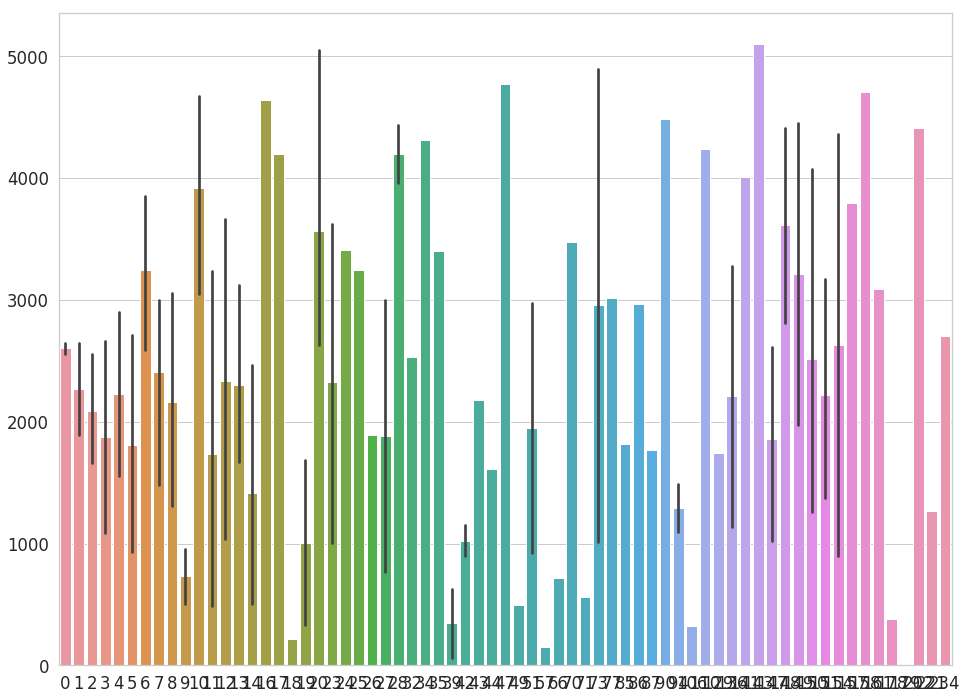

In [218]:
plt.figure(figsize=(16,12))
ax = sns.barplot(top_yt_url_counted_articles.values, top_yt_url_counted_articles.index)

In [222]:
article_x_yt_df

# articles  # articles with yt links  # articles without yt links  \
0   739         137                       602                           
1   562         77                        485                           
2   474         75                        399                           
3   368         69                        299                           
4   418         91                        327                           
5   315         44                        271                           
6   363         79                        284                           
7   229         74                        155                           
8   363         42                        321                           
9   224         77                        147                           
10  196         45                        151                           
11  193         29                        164                           
12  172         26                        146                           
13  191         35                        156                           
14  154         9                         145                           
15  73          40                        33                            
16  112         10                        102                           
17  91          14                        77                            
18  137         30                        107                           
19  143         13                        130                           

    % articles with yt links  mean top 10 links per article  \
0   18.538566                 22.3                            
1   13.701068                 20.3                            
2   15.822785                 7.4                             
3   18.750000                 19.9                            
4   21.770335                 3.5                             
5   13.968254                 9.2                             
6   21.763085                 4.8                             
7   32.314410                 10.0                            
8   11.570248                 1.0                             
9   34.375000                 11.4                            
10  22.959184                 7.8                             
11  15.025907                 7.0                             
12  15.116279                 3.5                             
13  18.324607                 0.6                             
14  5.844156                  0.0                             
15  54.794521                 17.1                            
16  8.928571                  2.9                             
17  15.384615                 9.8                             
18  21.897810                 5.1                             
19  9.090909                  6.0                             

    mean yt links per article                 publisher  
0   2.278755                   welt.de                   
1   1.519573                   spiegel.de                
2   1.476793                   focus.de                  
3   1.945652                   bild.de                   
4   1.705742                   faz.net                   
5   1.209524                   sueddeutsche.de           
6   1.622590                   zeit.de                   
7   2.663755                   tagesschau.de             
8   0.694215                   presseportal.de           
9   3.133929                   tagesspiegel.de           
10  1.000000                   heise.de                  
11  2.300518                   n-tv.de                   
12  1.459302                   epochtimes.de             
13  1.376963                   handelsblatt.com          
14  0.188312                   derstandard.at            
15  7.397260                   philosophia-perennis.com  
16  0.910714                   journalistenwatch.com     
17  3.582418                   tichyseinblick.de         
18  1.109489                   taz.de       